# Handling Imbalanced Data

### Loading libraries

In [1]:
# Date & Time
import time
from datetime import datetime

# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import plotly.io as pio
from plotly import tools
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Notebook Performance
from tqdm import tqdm

# OS
import gc
from dtype_diet import report_on_dataframe, optimize_dtypes

# Scikit-Learn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, average_precision_score, cohen_kappa_score, recall_score, f1_score, roc_auc_score, log_loss, brier_score_loss, matthews_corrcoef

# IMLearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours

# Categorical Boosting
from catboost import CatBoostClassifier

# Light Gradient Booster
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Extreme Gradient Booster - XGBoost
import xgboost as xgb

In [2]:
# Setting Visualization Style 
sns.set_style("whitegrid")

In [3]:
init_notebook_mode(connected=True)

In [4]:
pio.renderers.default = 'colab'

In [5]:
pd.set_option('display.max_columns', 100)

### Retrieving Data

In [6]:
data = pd.read_csv('/Users/joaquinromero/desktop/conformal_prediction/chap_11/creditcard.csv') 

In [7]:
print(f'Original df memory: {data.memory_usage(deep=True).sum()/1024/1024} MB')
proposed_df = report_on_dataframe(data, unit="MB")

data = optimize_dtypes(data, proposed_df)
print(f'Proposed df memory: {data.memory_usage(deep=True).sum()/1024/1024} MB')

Original df memory: 67.36017990112305 MB
Proposed df memory: 64.37243556976318 MB


/opt/anaconda3/envs/CP/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning:

overflow encountered in cast



In [8]:
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
# No Missing Data
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Exploratory Data Aanalysis (EDA)

In [11]:
# Data Description
data.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.867188  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47487.195312  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

                V10           V11           V12           V13           V14  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   2.239053e-15  1.673327e-15 -1.247012e-15  8.190001e-16  1.207294e-15   
std    1.088850e+00  1.020713e+00  9.992014e-01  9.952742e-01  9.585956e-01   
min   -2.458826e+01 -4.797473e+00 -1.868371e+01 -5.791881e+00 -1.921433e+01   
25%   -5.354257e-01 -7.624942e-01 -4.055715e-01 -6.485393e-01 -4.255740e-01   
50%   -9.291738e-02 -3.275735e-02  1.400326e-01 -1.356806e-02  5.060132e-02   
75%    4.539234e-01  7.395934e-01  6.182380e-01  6.625050e-01  4.931498e-01   
max    2.374514e+01  1.201891e+01  7.848392e+00  7.126883e+00  1.052677e+01   

                V15           V16           V17           V18           V19  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   4.887456e-15  1.437716e-15 -3.772171e-16  9.564149e-16  1.039917e-15   
std    9.153160e-01  8.762529e-01  8.493371e-01  8.381762e-01  8.140405e-01   
min   -4.498945e+00 -1.412985e+01 -2.516280e+01 -9.498746e+00 -7.213527e+00   
25%   -5.828843e-01 -4.680368e-01 -4.837483e-01 -4.988498e-01 -4.562989e-01   
50%    4.807155e-02  6.641332e-02 -6.567575e-02 -3.636312e-03  3.734823e-03   
75%    6.488208e-01  5.232963e-01  3.996750e-01  5.008067e-01  4.589494e-01   
max    8.877742e+00  1.731511e+01  9.253526e+00  5.041069e+00  5.591971e+00   

                V20           V21           V22           V23           V24  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   6.406204e-16  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    7.709250e-01  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min   -5.449772e+01 -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%   -2.117214e-01 -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%   -6.248109e-02 -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    1.330408e-01  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    3.942090e+01  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02

/var/folders/m3/3_zd43kn4nn3q52cpx_b38g00000gn/T/ipykernel_9050/30224424.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



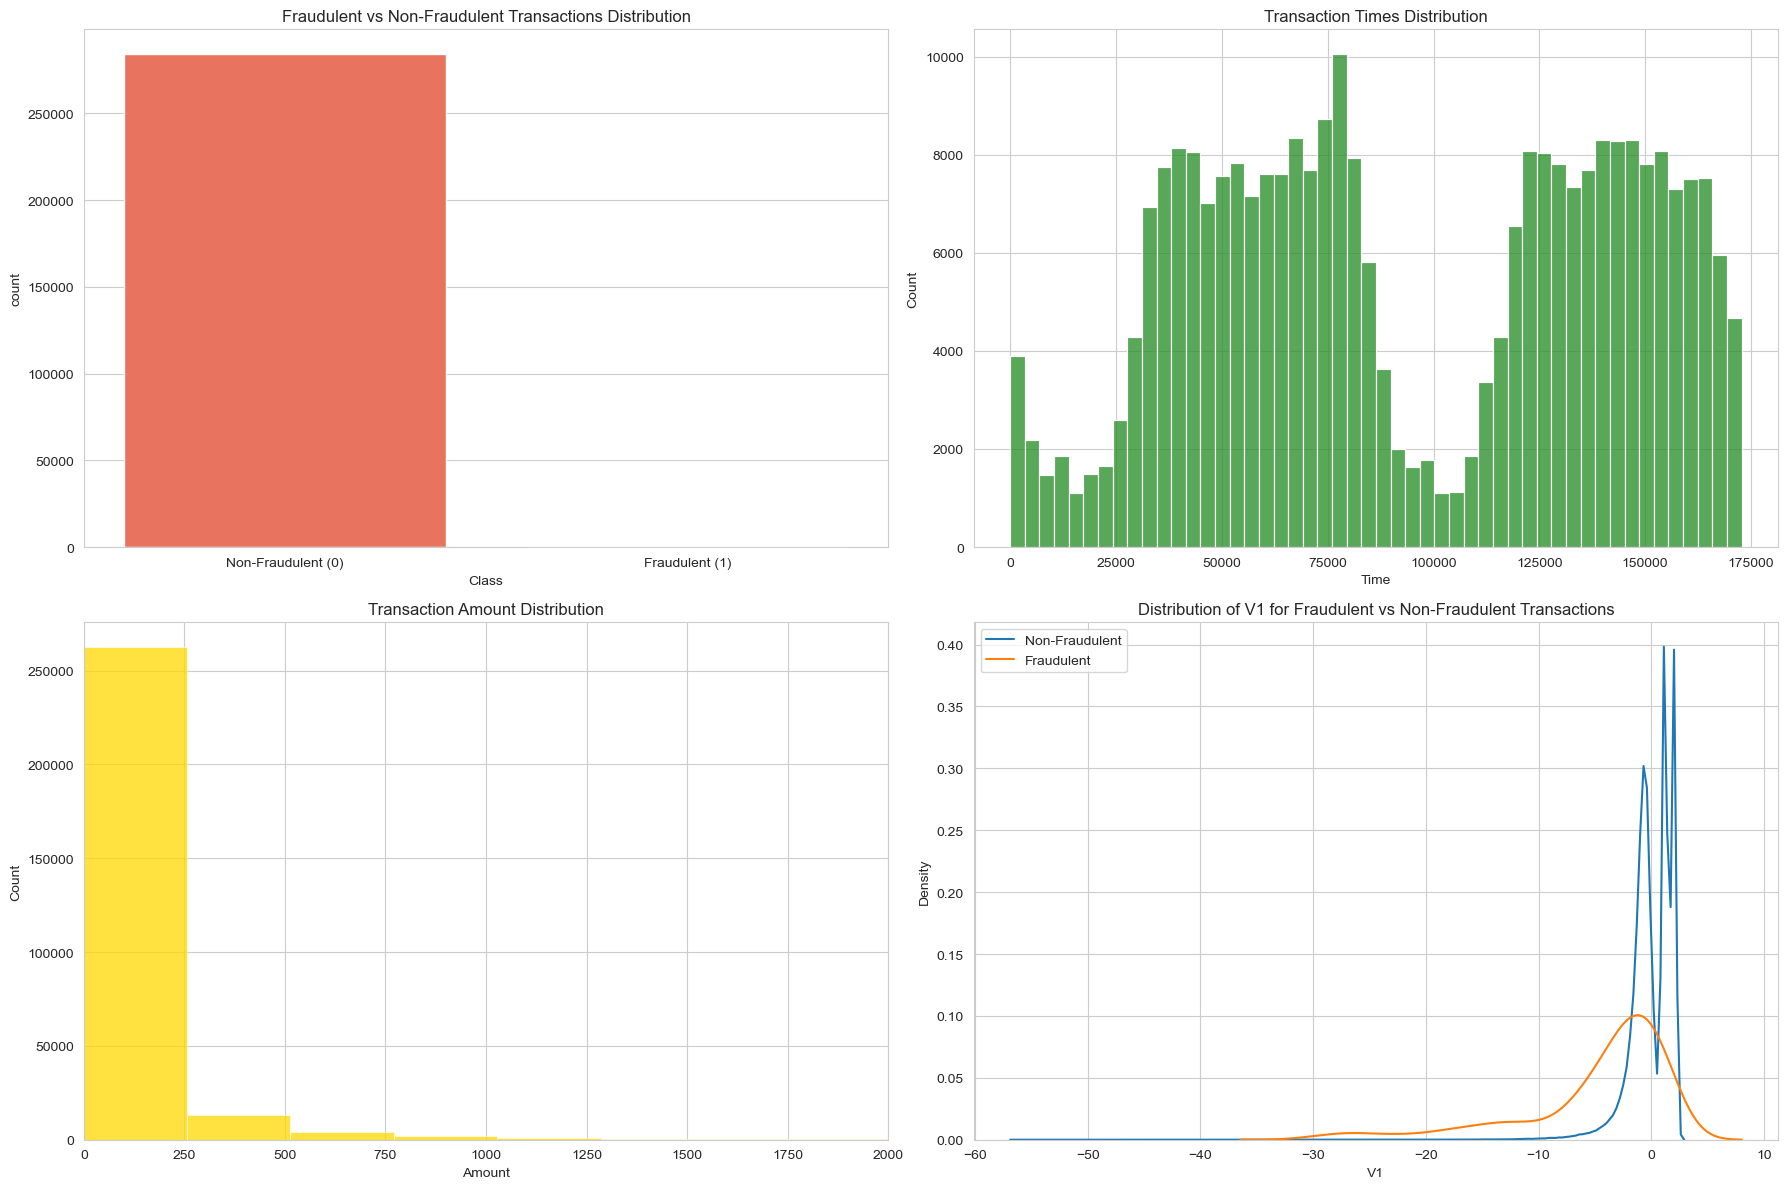

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# Variable Distribution - (Class)
sns.countplot(data=data, x='Class', ax=ax[0, 0], color='tomato')
ax[0, 0].set_title('Fraudulent vs Non-Fraudulent Transactions Distribution')
ax[0, 0].set_xticklabels(['Non-Fraudulent (0)', 'Fraudulent (1)'])

# Time Distribution 
sns.histplot(data['Time'], ax=ax[0, 1], bins=50, color='forestgreen')
ax[0, 1].set_title('Transaction Times Distribution')

# Amount Distribution 
sns.histplot(data['Amount'], ax=ax[1, 0], bins=100, color='gold')
ax[1, 0].set_title('Transaction Amount Distribution')
ax[1, 0].set_xlim([0, 2000])  

# PCA components Distribution (V1 as an example)
sns.kdeplot(data[data['Class'] == 0]['V1'], label='Non-Fraudulent', ax=ax[1, 1])
sns.kdeplot(data[data['Class'] == 1]['V1'], label='Fraudulent', ax=ax[1, 1])
ax[1, 1].set_title('Distribution of V1 for Fraudulent vs Non-Fraudulent Transactions')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

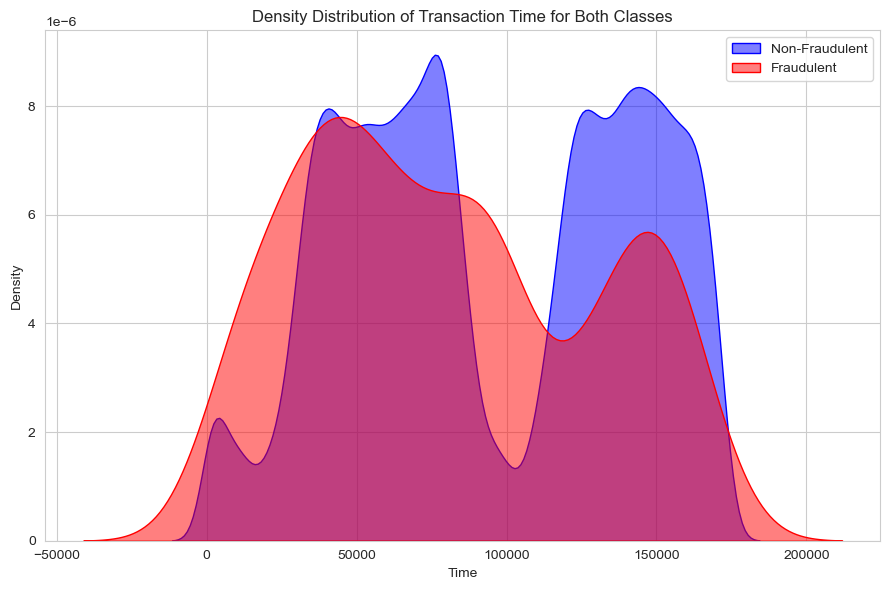

In [16]:
plt.figure(figsize=(9, 6))

# Density Distribution of 'Time' for non-fraudulent transactions 
sns.kdeplot(data[data['Class'] == 0]['Time'], color='blue', label='Non-Fraudulent', fill=True, alpha=0.5)

# Overlay Density Distribution of 'Time' for fraudulent transactions 
sns.kdeplot(data[data['Class'] == 1]['Time'], color='red', label='Fraudulent', fill=True, alpha=0.5)

plt.title('Density Distribution of Transaction Time for Both Classes')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Convert 'Time' from seconds to hours, without limiting to a single day's range
data['Hour'] = (data['Time'] / 3600).astype(int)

# Grouping data by 'Hour' and 'Class' to get count and sum of transactions for each class
grouped_data = data.groupby(['Hour', 'Class']).agg(Number_of_Transactions=('Time', 'count'), Total_Amount=('Amount', 'sum')).reset_index()

grouped_data.head()

Hour  Class  Number_of_Transactions  Total_Amount
0     0      0                    3961     256572.87
1     0      1                       2        529.00
2     1      0                    2215     145806.76
3     1      1                       2        298.93
4     2      0                    1555     106989.39

In [18]:
# Calculate daily totals for number of transactions and the total amount for each class
daily_totals_by_class = grouped_data.groupby(['Class']).agg(Daily_Total_Transactions=('Number_of_Transactions', 'sum'),
                                                            Daily_Total_Amount=('Total_Amount', 'sum')).reset_index()

# Merge Daily Totals with The Original Grouped Data
normalized_data = pd.merge(grouped_data, daily_totals_by_class, on='Class', how='left')

# Transactions Percentage & Amounts for each Hour based on Daily Totals for each Class
normalized_data['Percentage_Transactions'] = (normalized_data['Number_of_Transactions'] / normalized_data['Daily_Total_Transactions']) * 100
normalized_data['Percentage_Amount'] = (normalized_data['Total_Amount'] / normalized_data['Daily_Total_Amount']) * 100

normalized_data.head()

Hour  Class  Number_of_Transactions  Total_Amount  \
0     0      0                    3961     256572.87   
1     0      1                       2        529.00   
2     1      0                    2215     145806.76   
3     1      1                       2        298.93   
4     2      0                    1555     106989.39   

   Daily_Total_Transactions  Daily_Total_Amount  Percentage_Transactions  \
0                    284315         25102462.04                 1.393173   
1                       492            60127.97                 0.406504   
2                    284315         25102462.04                 0.779065   
3                       492            60127.97                 0.406504   
4                    284315         25102462.04                 0.546929   

   Percentage_Amount  
0           1.022102  
1           0.879790  
2           0.580846  
3           0.497156  
4           0.426211

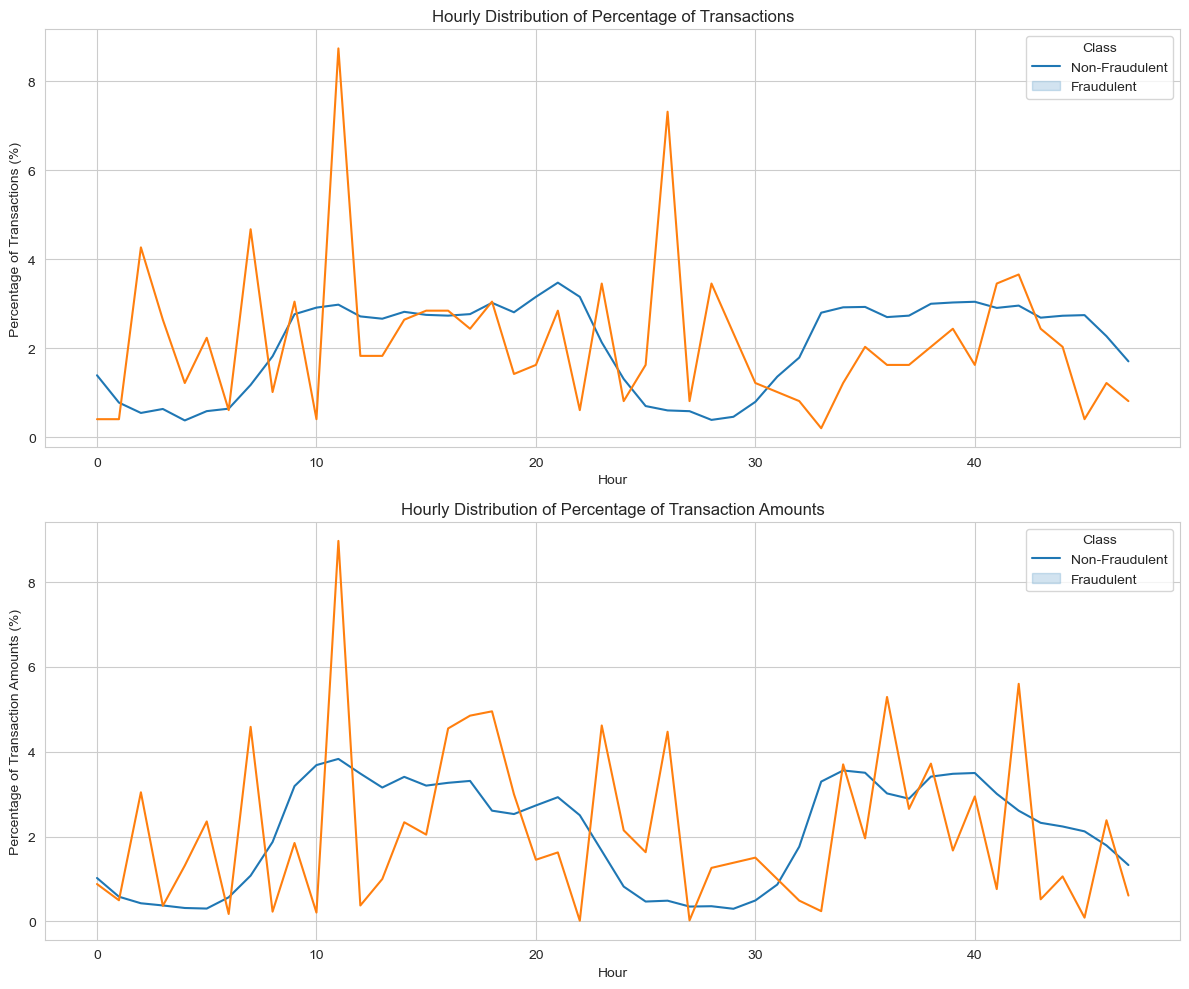

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Hourly Distribution of the Percentage of Transactions for both Classes
sns.lineplot(data=normalized_data, x='Hour', y='Percentage_Transactions', hue='Class', ax=ax[0], palette='tab10')
ax[0].set_title('Hourly Distribution of Percentage of Transactions')
ax[0].set_ylabel('Percentage of Transactions (%)')
ax[0].legend(title='Class', labels=['Non-Fraudulent', 'Fraudulent'])

# Hourly Distribution of the Percentage of Transaction Amounts for both Classes
sns.lineplot(data=normalized_data, x='Hour', y='Percentage_Amount', hue='Class', ax=ax[1], palette='tab10')
ax[1].set_title('Hourly Distribution of Percentage of Transaction Amounts')
ax[1].set_ylabel('Percentage of Transaction Amounts (%)')
ax[1].legend(title='Class', labels=['Non-Fraudulent', 'Fraudulent'])

plt.tight_layout()
plt.show()

In [20]:
fig1 = go.Figure()

# Add Traces for Non-Fraudulent & Fraudulent Transactions
fig1.add_trace(go.Scatter(x=normalized_data[normalized_data['Class'] == 0]['Hour'],
                          y=normalized_data[normalized_data['Class'] == 0]['Percentage_Transactions'],
                          mode='lines',
                          name='Non-Fraudulent'))
fig1.add_trace(go.Scatter(x=normalized_data[normalized_data['Class'] == 1]['Hour'],
                          y=normalized_data[normalized_data['Class'] == 1]['Percentage_Transactions'],
                          mode='lines',
                          name='Fraudulent'))

# Update Layout
fig1.update_layout(title='Hourly Distribution of Percentage of Transactions',
                   xaxis_title='Hour',
                   yaxis_title='Percentage of Transactions (%)')

# Create a Plotly Line Chart for hourly Distribution of the Percentage of Transaction Amounts for both Classes
fig2 = go.Figure()

# Add Traces for Non-Fraudulent and Fraudulent Transactions
fig2.add_trace(go.Scatter(x=normalized_data[normalized_data['Class'] == 0]['Hour'],
                          y=normalized_data[normalized_data['Class'] == 0]['Percentage_Amount'],
                          mode='lines',
                          name='Non-Fraudulent'))
fig2.add_trace(go.Scatter(x=normalized_data[normalized_data['Class'] == 1]['Hour'],
                          y=normalized_data[normalized_data['Class'] == 1]['Percentage_Amount'],
                          mode='lines',
                          name='Fraudulent'))

# Update layout
fig2.update_layout(title='Hourly Distribution of Percentage of Transaction Amounts',
                   xaxis_title='Hour',
                   yaxis_title='Percentage of Transaction Amounts (%)')

fig1.show()
fig2.show()

In [22]:
fig = go.Figure()

# Add Boxplots for Non-Fraudulent & Fraudulent Transaction Amounts
fig.add_trace(go.Box(y=data[data['Class'] == 0]['Amount'], name='Non-Fraudulent', marker_color='blue'))
fig.add_trace(go.Box(y=data[data['Class'] == 1]['Amount'], name='Fraudulent', marker_color='red'))

# Update Layout
fig.update_layout(title='Transaction Amounts Boxplot',
                  yaxis=dict(type='log', title='Transaction Amount ($)'),
                  xaxis_title='Class')

fig.show()

In [23]:
# Filtering out Fraudulent Transactions
fraudulent_data = data[data['Class'] == 1]

# Binned Time Intervals Histogram  
hist_data, bin_edges = np.histogram(fraudulent_data['Time'], bins=48) 

In [24]:
fig = go.Figure(data=go.Heatmap(z=[hist_data], x=bin_edges[:-1], colorscale='Viridis', showscale=True))

# Update Layout & Axis Titles
fig.update_layout(title='Fraudulent Transactions Over Time Heatmap',
                  xaxis_title='Time (in seconds)',
                  yaxis_title='Fraudulent Transactions',
                  yaxis_nticks=1)  

# Rotate X-axis Labels for Better Readability
fig.update_xaxes(tickangle=45)

fig.show()

In [25]:
# Correlation Matrix
correlation_matrix = data.corr()

# Plotly Heatmap
heatmap = go.Figure(data=go.Heatmap(z=correlation_matrix.values,
                                    x=correlation_matrix.columns,
                                    y=correlation_matrix.columns,
                                    colorscale='Viridis',
                                    zmin=-1, zmax=1))

# Update Layout for Better Readability
heatmap.update_layout(title='Correlation Heatmap of Features and Target',
                      xaxis_tickangle=-45)

heatmap.show()

In [26]:
# Recomputing Correlation Matrix
correlation_matrix = data.corr()

# Red-Green Correlation Matrix Display
cm_red_green = sns.diverging_palette(150, 10, as_cmap=True)
styled_correlation_red_green = correlation_matrix.style.background_gradient(cmap=cm_red_green)
styled_correlation_red_green

In [27]:
class_correlations = correlation_matrix["Class"].drop("Class")

# Figure Set-Up
fig = go.Figure(data=[go.Bar(x=class_correlations.index,
                             y=class_correlations.values,
                             marker=dict(color=class_correlations.values,
                                         colorscale="RdYlGn",
                                         colorbar=dict(title="Correlation Coefficient")))])

# Update Layout
fig.update_layout(title="Features with 'Class Correlation'",
                  xaxis_title="Features",
                  yaxis_title="Correlation Coefficient",
                  xaxis_tickangle=-45)

fig.show()

## Modeling

### `TRAIN - VALIDATION - TEST` SPLIT

In [28]:
# Simple validation using train_test_split
VALID_SIZE = 0.20 

# Test size using_train_test_split
TEST_SIZE = 0.20 

#Cross-Validation - KFolds
NUMBER_KFOLDS = 5 

RANDOM_STATE = 42

In [29]:
# Target
target = 'Class'

# Features
features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10','V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','Amount']
     

#### Splitting Data into: `Train, Validation, Test, and Calibration Sets`

In [31]:
train_calib_df, test_df = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)

train_df, calib_df = train_test_split(train_calib_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)

# Display the number of samples in each dataset
len(train_df), len(calib_df), len(test_df)  


(182276, 45569, 56962)

In [32]:
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  Hour  
0  149.62      0     0  
1    2.69      0     0  
2  378.66      0     0  
3  123.50      0     0  
4   69.99      0     0

In [33]:
data.drop('Hour',axis = 1, inplace = True)
     

In [34]:
train_df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  Hour  
0  149.62      0     0  
1    2.69      0     0  
2  378.66      0     0  
3  123.50      0     0  
4   69.99      0     0

In [35]:
# Training the StandardScaler on the training set
scaler_time = StandardScaler().fit(train_df['Time'].values.reshape(-1, 1))
scaler_amount = StandardScaler().fit(train_df['Amount'].values.reshape(-1, 1))

# Transforming the 'Time' & 'Amount' Columns in Train, Validation, Calibration, and Test sets
train_df['Time'] = scaler_time.transform(train_df['Time'].values.reshape(-1, 1))
train_df['Amount'] = scaler_amount.transform(train_df['Amount'].values.reshape(-1, 1))

calib_df['Time'] = scaler_time.transform(calib_df['Time'].values.reshape(-1, 1))
calib_df['Amount'] = scaler_amount.transform(calib_df['Amount'].values.reshape(-1, 1))

test_df['Time'] = scaler_time.transform(test_df['Time'].values.reshape(-1, 1))
test_df['Amount'] = scaler_amount.transform(test_df['Amount'].values.reshape(-1, 1))

# Display the transformed 'Time' & 'Amount' Columns for The Training Set as an example     
train_df[['Time', 'Amount']].head()  

Time    Amount
0 -2.107744  0.246850
1 -2.107744 -0.346675
2 -2.107711  1.172058
3 -2.107711  0.141338
4 -2.107679 -0.074816

In [36]:
# Checking for Overlapping Rows between The Training and Test Sets
overlapping_rows = train_df.merge(test_df, how='inner')
overlap_count = overlapping_rows.shape[0]

overlap = overlap_count > 0
overlap, overlap_count

(False, 0)

In [37]:
train_df.head()

Time        V1        V2        V3        V4        V5        V6  \
0 -2.107744 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1 -2.107744  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2 -2.107711 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3 -2.107711 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4 -2.107679 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9       V10       V11       V12       V13  \
0  0.239599  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390   
1 -0.078803  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095   
2  0.791461  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293   
3  0.237609  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757   
4  0.592941 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852   

        V14       V15       V16       V17       V18       V19       V20  \
0 -0.311169  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412   
1 -0.143772  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083   
2 -0.165946  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980   
3 -0.287924 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038   
4 -1.119670  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542   

        V21       V22       V23       V24       V25       V26       V27  \
0 -0.018307  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558   
1 -0.225775 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983   
2  0.247998  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353   
3 -0.108300  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723   
4 -0.009431  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422   

        V28    Amount  Class  Hour  
0 -0.021053  0.246850      0     0  
1  0.014724 -0.346675      0     0  
2 -0.059752  1.172058      0     0  
3  0.061458  0.141338      0     0  
4  0.215153 -0.074816      0     0

In [38]:
# Creating a DataFrame to record the performance of various models
models = ['Naive Classifier', 'Logistic Regression', 'Random Forest Classifier', 'AdaBoost Classifier', 'CatBoost Classifier', 'SVC', 'LGBM Classifier', 'XGBoost Classifier']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'ECE', 'Log Loss', 'Brier Loss']

performance_base_models_df = pd.DataFrame(index=models, columns=metrics)

performance_calibrated_models_df = pd.DataFrame(index=models, columns=metrics)

In [39]:
# Setting-Up a DataFrame to Record Execution Times
time_df = pd.DataFrame(index=models, columns=['Execution Time (s)'])

## Naïve Classifier

In [40]:
# Naive classifier: Predicting Majority Class (Class 0) for All Samples
naive_predictions = np.zeros(len(test_df))

# True labels for the test set
true_labels = test_df['Class'].values

# Compute Metrics
accuracy = accuracy_score(true_labels, naive_predictions)
precision = precision_score(true_labels, naive_predictions,zero_division=0)
recall = recall_score(true_labels, naive_predictions,zero_division=0)
f1 = f1_score(true_labels, naive_predictions)
roc_auc = roc_auc_score(true_labels, naive_predictions)
logloss = log_loss(true_labels, naive_predictions)
brier_loss = brier_score_loss(true_labels, naive_predictions)

# Compute Expected Calibration Error (ECE)
fraction_of_positives, mean_predicted_value = calibration_curve(true_labels, naive_predictions, n_bins=10)
ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value)) / len(mean_predicted_value)

# Populate the performance dataframe
performance_base_models_df.loc['Naive Classifier', :] = [accuracy, precision, recall, f1, roc_auc, ece, logloss, brier_loss]

In [41]:
performance_base_models_df

Accuracy Precision Recall   F1 ROC AUC       ECE  \
Naive Classifier          0.998683       0.0    0.0  0.0     0.5  0.001317   
Logistic Regression            NaN       NaN    NaN  NaN     NaN       NaN   
Random Forest Classifier       NaN       NaN    NaN  NaN     NaN       NaN   
AdaBoost Classifier            NaN       NaN    NaN  NaN     NaN       NaN   
CatBoost Classifier            NaN       NaN    NaN  NaN     NaN       NaN   
SVC                            NaN       NaN    NaN  NaN     NaN       NaN   
LGBM Classifier                NaN       NaN    NaN  NaN     NaN       NaN   
XGBoost Classifier             NaN       NaN    NaN  NaN     NaN       NaN   

                          Log Loss Brier Loss  
Naive Classifier          0.047457   0.001317  
Logistic Regression            NaN        NaN  
Random Forest Classifier       NaN        NaN  
AdaBoost Classifier            NaN        NaN  
CatBoost Classifier            NaN        NaN  
SVC                            NaN        NaN  
LGBM Classifier                NaN        NaN  
XGBoost Classifier             NaN        NaN

### Model Performance Evaluator

In [43]:
def evaluate_model_performance(model, model_name, true_labels=true_labels, performance_df=performance_base_models_df, verbose=False):
    """
    Evaluates model performance and updates the performance dataframe with metrics.

    Args:
    - predictions (array-like): Predicted values from the model.
    - model_name (str): Name of the model for which performance is being evaluated.
    - true_labels (array-like): Actual labels for comparison. Default is the true_labels of the test set.
    - performance_df (DataFrame): DataFrame to update with model performance metrics.

    Returns:
    - DataFrame with updated performance metrics for the given model.
    """

    start_time = time.time()  # Record start time

    # Train Logistic Regression
    model.fit(train_df.drop(columns='Class'), train_df['Class'])

    # Predict class score on the test set
    prob_pos = model.predict_proba(test_df.drop(columns='Class'))[:, 1]
    # Predict on the test set
    predictions = model.predict(test_df.drop(columns='Class'))

    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, prob_pos)
    logloss = log_loss(true_labels, prob_pos)
    brier_loss = brier_score_loss(true_labels, prob_pos)

    # Compute Expected Calibration Error (ECE)
    fraction_of_positives, mean_predicted_value = calibration_curve(true_labels, prob_pos, n_bins=10)
    ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value)) / len(mean_predicted_value)

    # Populate the performance dataframe
    performance_df.loc[model_name, :] = [accuracy, precision, recall, f1, roc_auc, ece, logloss, brier_loss]

    # Plot calibration curve and histogram if verbose is True
    if verbose:
        fig = plt.figure(figsize=(10, 10))
        gs = GridSpec(2, 1)
        ax_calibration_curve = fig.add_subplot(gs[0, :])
        ax_histogram = fig.add_subplot(gs[1, :])

        # Plot calibration curve
        CalibrationDisplay.from_estimator(
            model,
            test_df.drop(columns='Class'),
            true_labels,
            n_bins=10,
            name=model_name,
            ax=ax_calibration_curve
        )
        ax_calibration_curve.set_title(f"Calibration plot ({model_name})")

        # Plot histogram
        ax_histogram.hist(prob_pos, range=(0, 1), bins=10, label=model_name)
        ax_histogram.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")

        plt.tight_layout()
        plt.show()

    end_time = time.time()  # Record end time
    execution_time = end_time - start_time  # Calculate execution time in seconds

    # Record execution time in the time DataFrame
    time_df.loc[model_name, 'Execution Time (s)'] = execution_time

    return performance_df,model

In [44]:
time_df

Execution Time (s)
Naive Classifier                        NaN
Logistic Regression                     NaN
Random Forest Classifier                NaN
AdaBoost Classifier                     NaN
CatBoost Classifier                     NaN
SVC                                     NaN
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

## Dummy Classifier

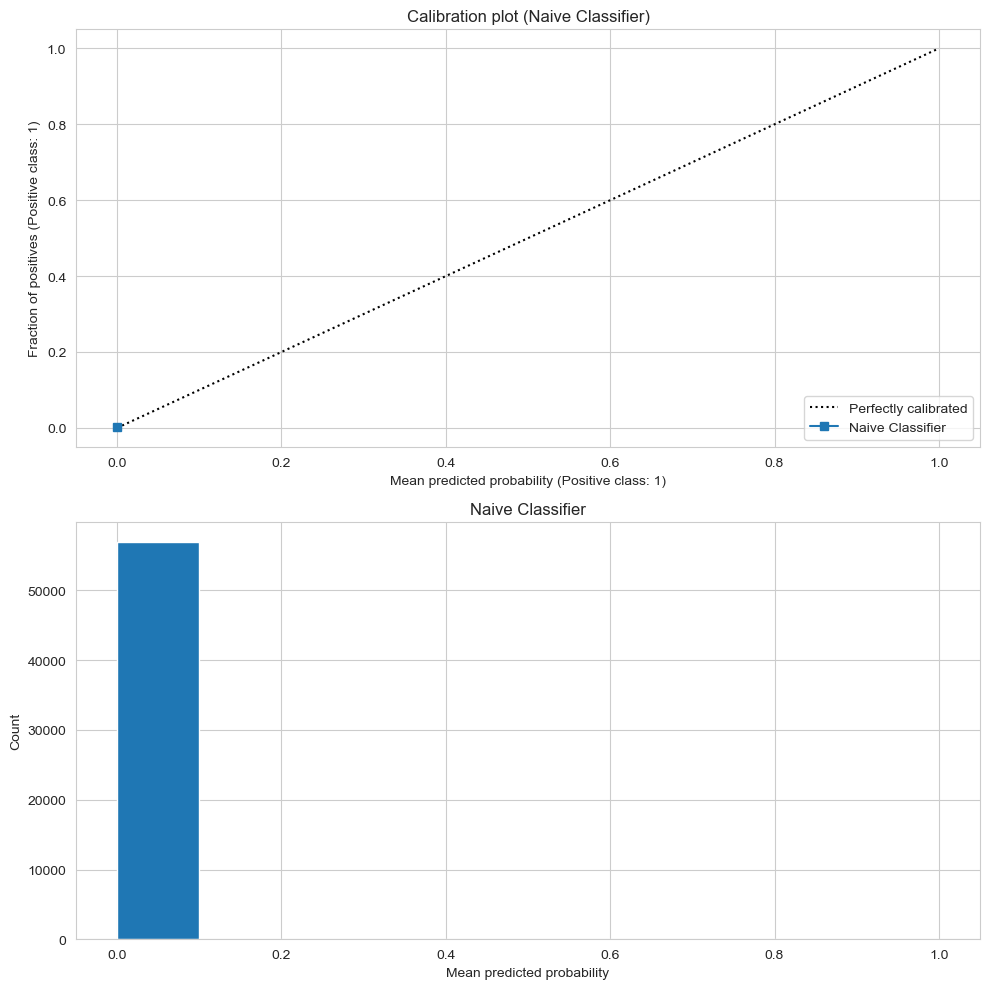

In [45]:
dummy_classifier_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE , constant=None)

performance_base_models_df, _ = evaluate_model_performance(dummy_classifier_model,'Naive Classifier', verbose=True)

In [46]:
performance_base_models_df

Accuracy Precision Recall   F1 ROC AUC       ECE  \
Naive Classifier          0.998683       0.0    0.0  0.0     0.5  0.001317   
Logistic Regression            NaN       NaN    NaN  NaN     NaN       NaN   
Random Forest Classifier       NaN       NaN    NaN  NaN     NaN       NaN   
AdaBoost Classifier            NaN       NaN    NaN  NaN     NaN       NaN   
CatBoost Classifier            NaN       NaN    NaN  NaN     NaN       NaN   
SVC                            NaN       NaN    NaN  NaN     NaN       NaN   
LGBM Classifier                NaN       NaN    NaN  NaN     NaN       NaN   
XGBoost Classifier             NaN       NaN    NaN  NaN     NaN       NaN   

                          Log Loss Brier Loss  
Naive Classifier          0.047457   0.001317  
Logistic Regression            NaN        NaN  
Random Forest Classifier       NaN        NaN  
AdaBoost Classifier            NaN        NaN  
CatBoost Classifier            NaN        NaN  
SVC                            NaN        NaN  
LGBM Classifier                NaN        NaN  
XGBoost Classifier             NaN        NaN

In [48]:
time_df

Execution Time (s)
Naive Classifier                   0.161237
Logistic Regression                     NaN
Random Forest Classifier                NaN
AdaBoost Classifier                     NaN
CatBoost Classifier                     NaN
SVC                                     NaN
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

## Logistic Regression

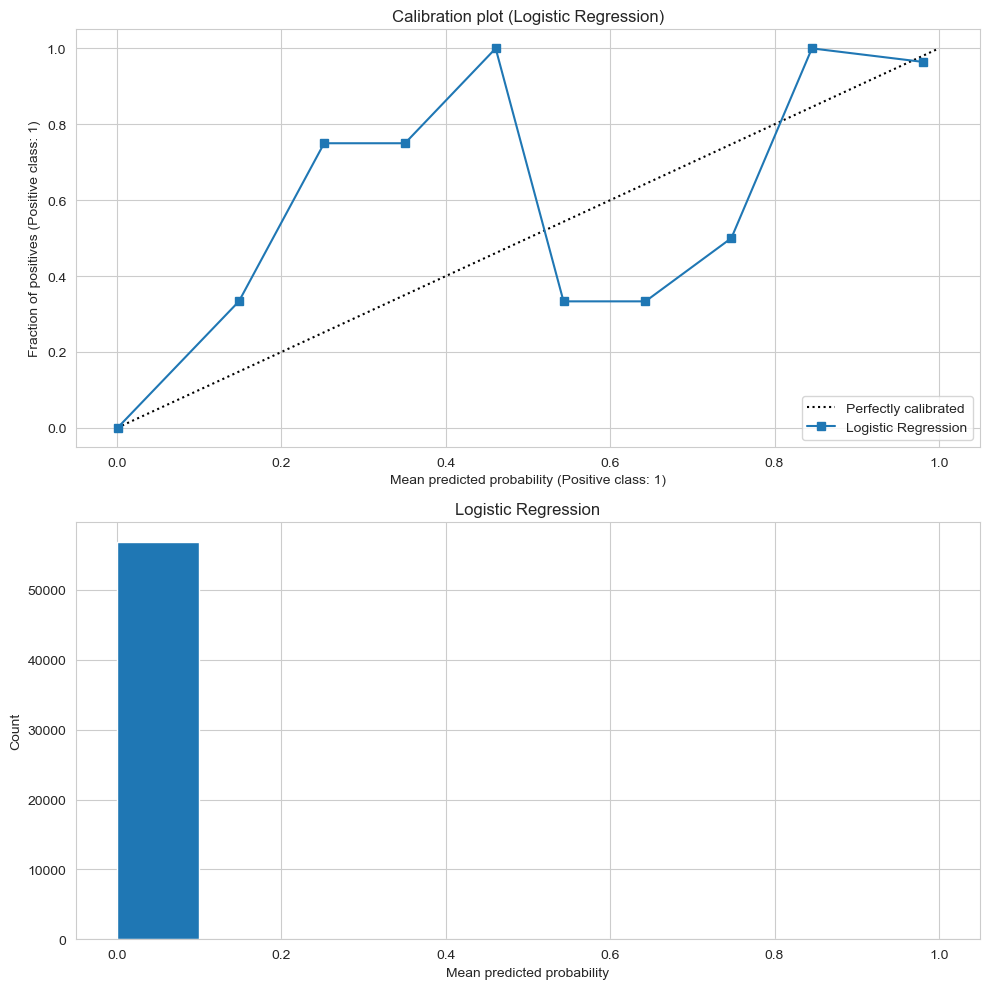

In [49]:
# Train Logistic Regression
logistic_regression_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

performance_base_models_df,_ = evaluate_model_performance(logistic_regression_model,'Logistic Regression', verbose=True)

In [50]:
performance_base_models_df

Accuracy Precision Recall        F1  ROC AUC  \
Naive Classifier          0.998683       0.0    0.0       0.0      0.5   
Logistic Regression       0.999122  0.735849   0.52  0.609375  0.97512   
Random Forest Classifier       NaN       NaN    NaN       NaN      NaN   
AdaBoost Classifier            NaN       NaN    NaN       NaN      NaN   
CatBoost Classifier            NaN       NaN    NaN       NaN      NaN   
SVC                            NaN       NaN    NaN       NaN      NaN   
LGBM Classifier                NaN       NaN    NaN       NaN      NaN   
XGBoost Classifier             NaN       NaN    NaN       NaN      NaN   

                               ECE  Log Loss Brier Loss  
Naive Classifier          0.001317  0.047457   0.001317  
Logistic Regression       0.256053  0.003402   0.000636  
Random Forest Classifier       NaN       NaN        NaN  
AdaBoost Classifier            NaN       NaN        NaN  
CatBoost Classifier            NaN       NaN        NaN  
SVC                            NaN       NaN        NaN  
LGBM Classifier                NaN       NaN        NaN  
XGBoost Classifier             NaN       NaN        NaN

In [51]:
time_df

Execution Time (s)
Naive Classifier                   0.161237
Logistic Regression                2.786396
Random Forest Classifier                NaN
AdaBoost Classifier                     NaN
CatBoost Classifier                     NaN
SVC                                     NaN
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

## Random Forest

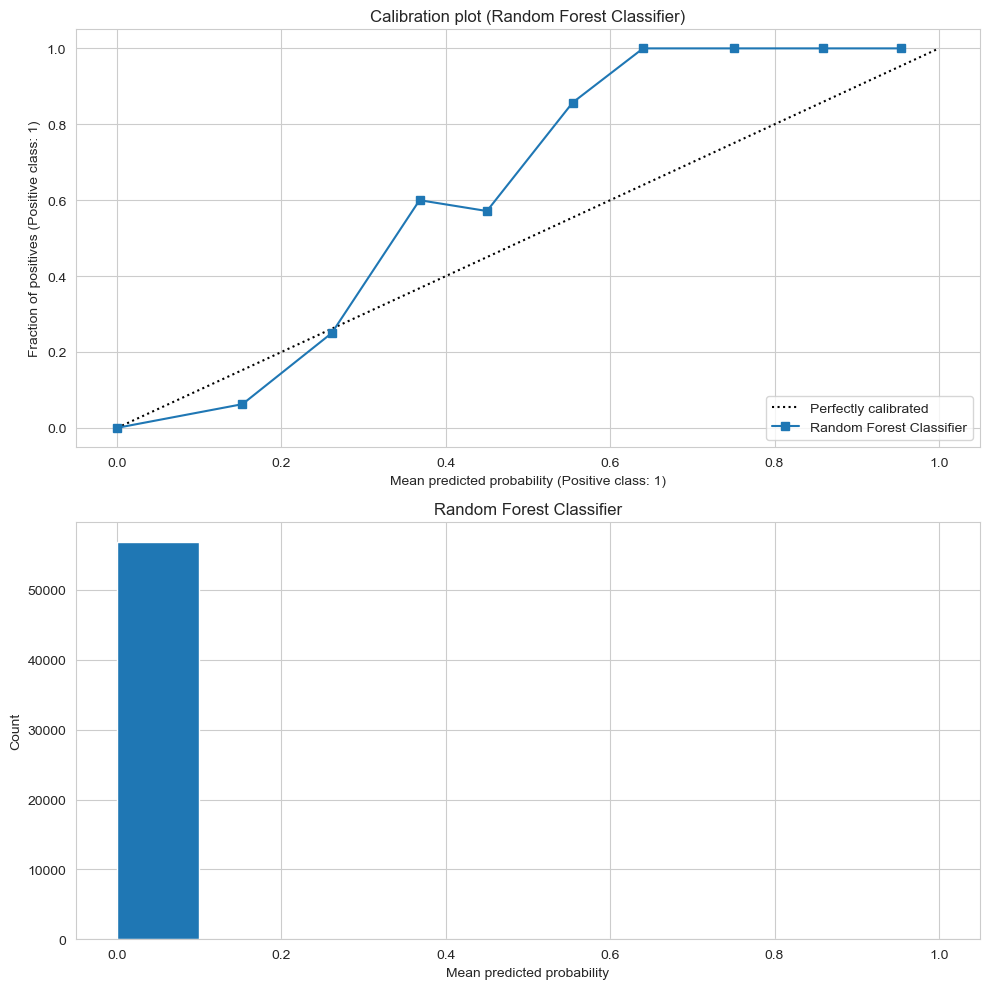

In [52]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

performance_base_models_df, rf_trained_model = evaluate_model_performance(rf_model,'Random Forest Classifier', verbose=True)

In [53]:
performance_base_models_df

Accuracy Precision Recall        F1   ROC AUC  \
Naive Classifier          0.998683       0.0    0.0       0.0       0.5   
Logistic Regression       0.999122  0.735849   0.52  0.609375   0.97512   
Random Forest Classifier  0.999508  0.979592   0.64  0.774194  0.950738   
AdaBoost Classifier            NaN       NaN    NaN       NaN       NaN   
CatBoost Classifier            NaN       NaN    NaN       NaN       NaN   
SVC                            NaN       NaN    NaN       NaN       NaN   
LGBM Classifier                NaN       NaN    NaN       NaN       NaN   
XGBoost Classifier             NaN       NaN    NaN       NaN       NaN   

                               ECE  Log Loss Brier Loss  
Naive Classifier          0.001317  0.047457   0.001317  
Logistic Regression       0.256053  0.003402   0.000636  
Random Forest Classifier  0.155291  0.006108    0.00046  
AdaBoost Classifier            NaN       NaN        NaN  
CatBoost Classifier            NaN       NaN        NaN  
SVC                            NaN       NaN        NaN  
LGBM Classifier                NaN       NaN        NaN  
XGBoost Classifier             NaN       NaN        NaN

In [54]:
time_df

Execution Time (s)
Naive Classifier                   0.161237
Logistic Regression                2.786396
Random Forest Classifier           8.430789
AdaBoost Classifier                     NaN
CatBoost Classifier                     NaN
SVC                                     NaN
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

In [56]:
pio.renderers.default = 'colab'

# Extract feature importances from the Random Forest model
feature_importances = rf_trained_model.feature_importances_

# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': train_df.drop(columns='Class').columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting using Plotly
fig = go.Figure(data=[
    go.Bar(x=features_df['Feature'], y=features_df['Importance'], marker_color='rgba(55, 128, 191, 0.7)')
])

fig.update_layout(title='Feature Importances from Random Forest',
                  xaxis_title='Features',
                  yaxis_title='Importance',
                  xaxis_tickangle=-45)

fig.show()

## AdaBoost Classifier

/opt/anaconda3/envs/CP/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



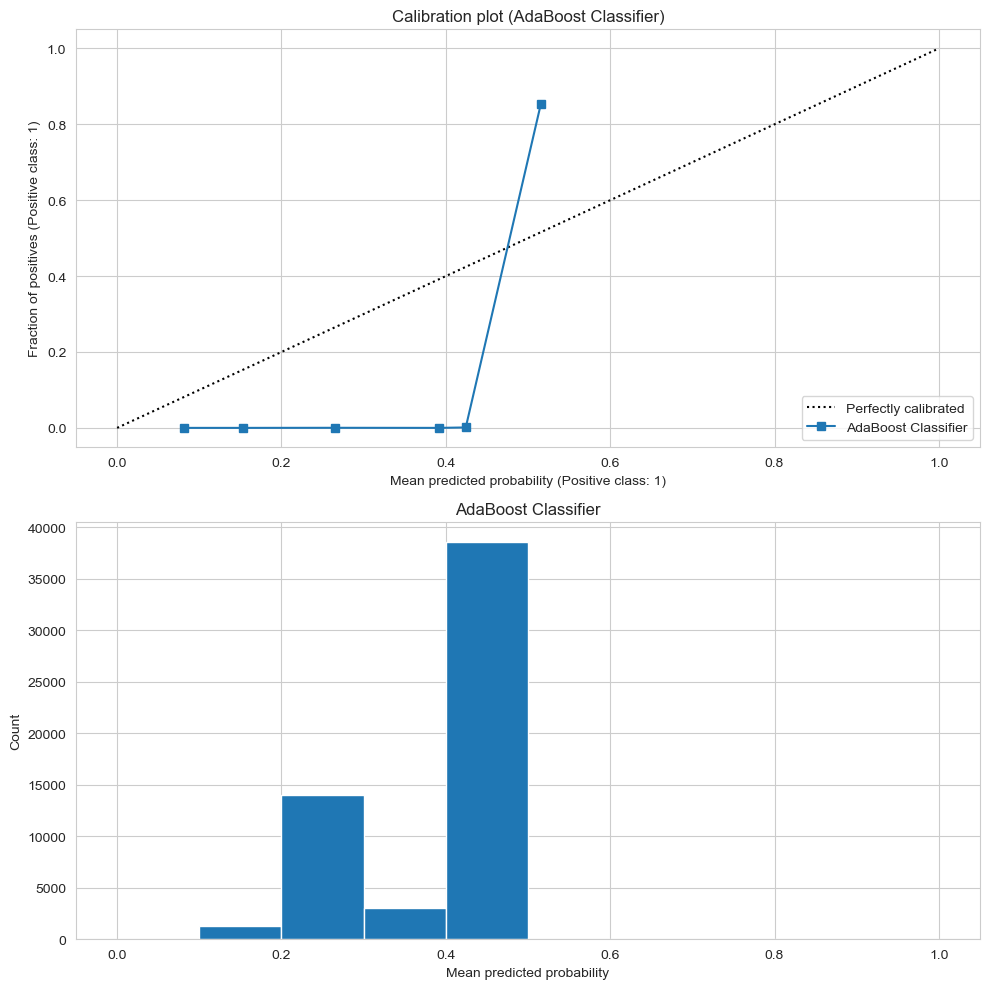

In [57]:
# Train AdaBoost classifier
ada_model = AdaBoostClassifier(random_state=RANDOM_STATE)

performance_base_models_df, ada_trained_model = evaluate_model_performance(ada_model ,'AdaBoost Classifier', verbose=True)

In [58]:
performance_base_models_df

Accuracy Precision    Recall        F1   ROC AUC  \
Naive Classifier          0.998683       0.0       0.0       0.0       0.5   
Logistic Regression       0.999122  0.735849      0.52  0.609375   0.97512   
Random Forest Classifier  0.999508  0.979592      0.64  0.774194  0.950738   
AdaBoost Classifier       0.999105  0.852941  0.386667   0.53211  0.955459   
CatBoost Classifier            NaN       NaN       NaN       NaN       NaN   
SVC                            NaN       NaN       NaN       NaN       NaN   
LGBM Classifier                NaN       NaN       NaN       NaN       NaN   
XGBoost Classifier             NaN       NaN       NaN       NaN       NaN   

                               ECE  Log Loss Brier Loss  
Naive Classifier          0.001317  0.047457   0.001317  
Logistic Regression       0.256053  0.003402   0.000636  
Random Forest Classifier  0.155291  0.006108    0.00046  
AdaBoost Classifier       0.275029  0.480356   0.148149  
CatBoost Classifier            NaN       NaN        NaN  
SVC                            NaN       NaN        NaN  
LGBM Classifier                NaN       NaN        NaN  
XGBoost Classifier             NaN       NaN        NaN

In [59]:
time_df

Execution Time (s)
Naive Classifier                   0.161237
Logistic Regression                2.786396
Random Forest Classifier           8.430789
AdaBoost Classifier               26.203363
CatBoost Classifier                     NaN
SVC                                     NaN
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

In [60]:
pio.renderers.default = 'colab'

# Extract feature importances from the Random Forest model
feature_importances = ada_trained_model.feature_importances_

# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': train_df.drop(columns='Class').columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting using Plotly
fig = go.Figure(data=[
    go.Bar(x=features_df['Feature'], y=features_df['Importance'], marker_color='rgba(55, 128, 191, 0.7)')
])

fig.update_layout(title='Feature Importances from Ada Boost',
                  xaxis_title='Features',
                  yaxis_title='Importance',
                  xaxis_tickangle=-45)

fig.show()

## CatBoost Classifier

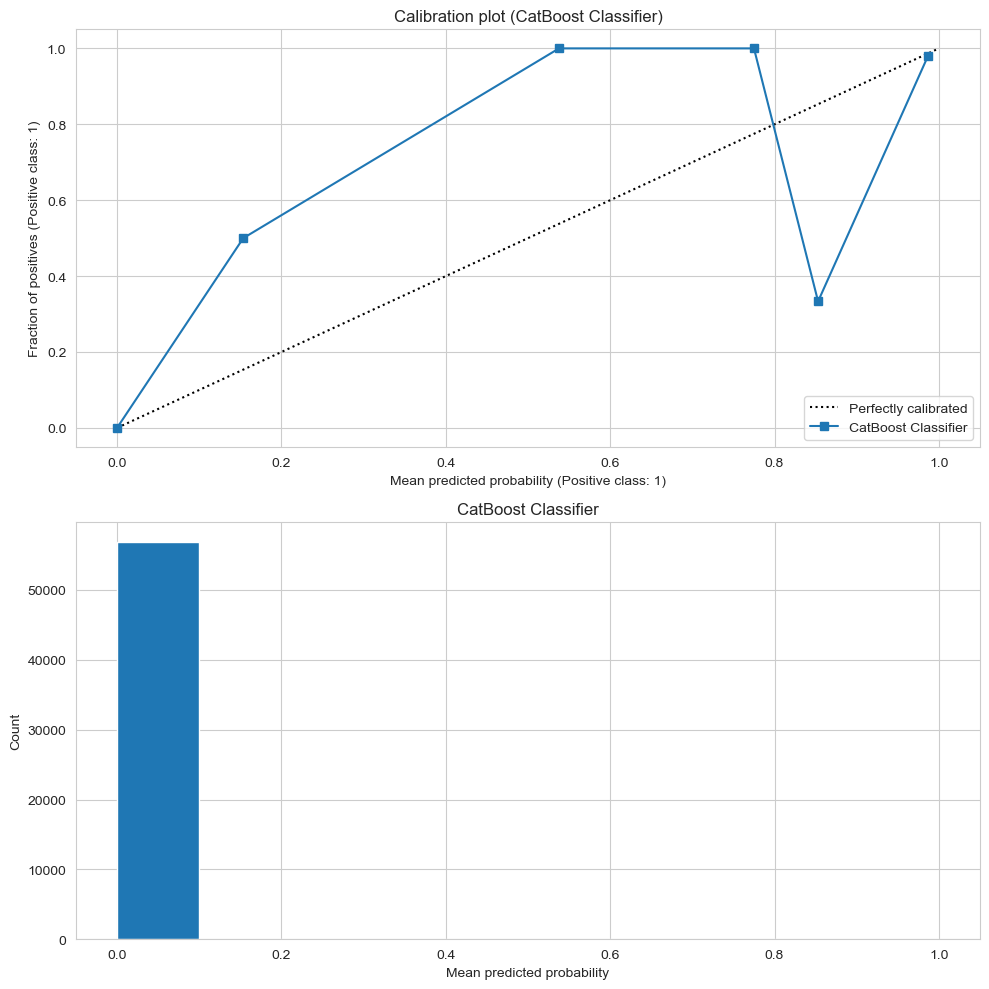

In [61]:
# Train CatBoost Classifier
catboost_model  = CatBoostClassifier(
    task_type="CPU",       
    thread_count=-1,       
    verbose=0,
    random_state=RANDOM_STATE
)

performance_base_models_df, catboost_trained_model = evaluate_model_performance(catboost_model,'CatBoost Classifier', verbose=True)

In [62]:
performance_base_models_df

Accuracy Precision    Recall        F1   ROC AUC  \
Naive Classifier          0.998683       0.0       0.0       0.0       0.5   
Logistic Regression       0.999122  0.735849      0.52  0.609375   0.97512   
Random Forest Classifier  0.999508  0.979592      0.64  0.774194  0.950738   
AdaBoost Classifier       0.999105  0.852941  0.386667   0.53211  0.955459   
CatBoost Classifier       0.999579  0.947368      0.72  0.818182  0.977466   
SVC                            NaN       NaN       NaN       NaN       NaN   
LGBM Classifier                NaN       NaN       NaN       NaN       NaN   
XGBoost Classifier             NaN       NaN       NaN       NaN       NaN   

                               ECE  Log Loss Brier Loss  
Naive Classifier          0.001317  0.047457   0.001317  
Logistic Regression       0.256053  0.003402   0.000636  
Random Forest Classifier  0.155291  0.006108    0.00046  
AdaBoost Classifier       0.275029  0.480356   0.148149  
CatBoost Classifier        0.26019  0.003322   0.000417  
SVC                            NaN       NaN        NaN  
LGBM Classifier                NaN       NaN        NaN  
XGBoost Classifier             NaN       NaN        NaN

In [63]:
time_df

Execution Time (s)
Naive Classifier                   0.161237
Logistic Regression                2.786396
Random Forest Classifier           8.430789
AdaBoost Classifier               26.203363
CatBoost Classifier                6.666082
SVC                                     NaN
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

In [64]:
pio.renderers.default = 'colab'

# Extract feature importances
feature_importances = catboost_trained_model.get_feature_importance()

# Sort feature importances
sorted_indices = feature_importances.argsort()[::-1]  # Sort in descending order

# Sort feature names based on importance order
sorted_features = train_df.drop(columns='Class').columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot sorted feature importances using Plotly
fig = go.Figure(data=[
    go.Bar(x=sorted_features,
           y=sorted_importances,
           marker_color='indianred')
])

fig.update_layout(title='Feature Importances from CatBoost Classifier (Sorted)',
                 xaxis=dict(title='Features'),
                 yaxis=dict(title='Importance'),
                 xaxis_tickangle=-45)

fig.show()

## Support Vector Machines Classifier

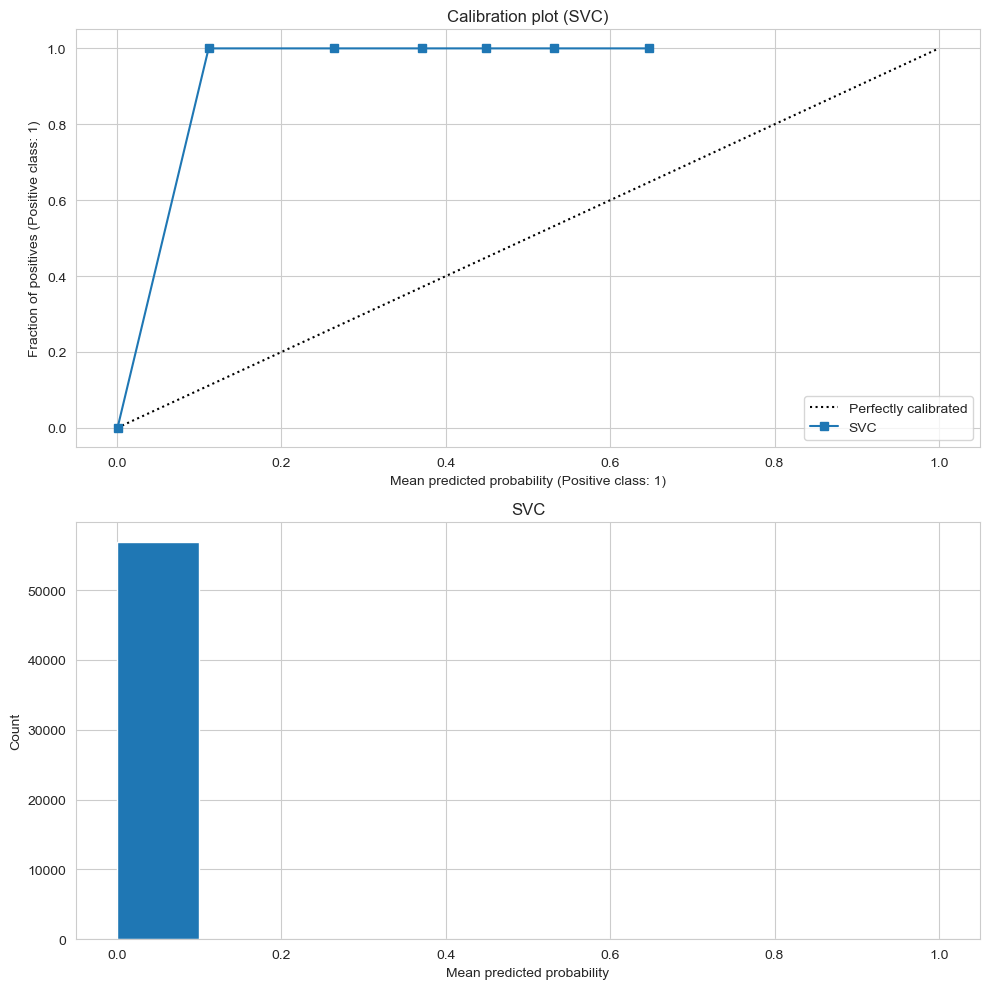

In [65]:
# Training SVC model
svc_model = SVC(probability=True, random_state=RANDOM_STATE)

performance_base_models_df,_ = evaluate_model_performance(svc_model ,'SVC', verbose=True)

In [66]:
performance_base_models_df

Accuracy Precision    Recall        F1   ROC AUC  \
Naive Classifier          0.998683       0.0       0.0       0.0       0.5   
Logistic Regression       0.999122  0.735849      0.52  0.609375   0.97512   
Random Forest Classifier  0.999508  0.979592      0.64  0.774194  0.950738   
AdaBoost Classifier       0.999105  0.852941  0.386667   0.53211  0.955459   
CatBoost Classifier       0.999579  0.947368      0.72  0.818182  0.977466   
SVC                       0.999333       1.0  0.493333  0.660714  0.886845   
LGBM Classifier                NaN       NaN       NaN       NaN       NaN   
XGBoost Classifier             NaN       NaN       NaN       NaN       NaN   

                               ECE  Log Loss Brier Loss  
Naive Classifier          0.001317  0.047457   0.001317  
Logistic Regression       0.256053  0.003402   0.000636  
Random Forest Classifier  0.155291  0.006108    0.00046  
AdaBoost Classifier       0.275029  0.480356   0.148149  
CatBoost Classifier        0.26019  0.003322   0.000417  
SVC                       0.518006   0.00486    0.00089  
LGBM Classifier                NaN       NaN        NaN  
XGBoost Classifier             NaN       NaN        NaN

In [67]:
time_df

Execution Time (s)
Naive Classifier                   0.161237
Logistic Regression                2.786396
Random Forest Classifier           8.430789
AdaBoost Classifier               26.203363
CatBoost Classifier                6.666082
SVC                                28.05077
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

## LGBM Classifier

[LightGBM] [Info] Number of positive: 365, number of negative: 181911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7685
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002002 -> initscore=-6.211375
[LightGBM] [Info] Start training from score -6.211375


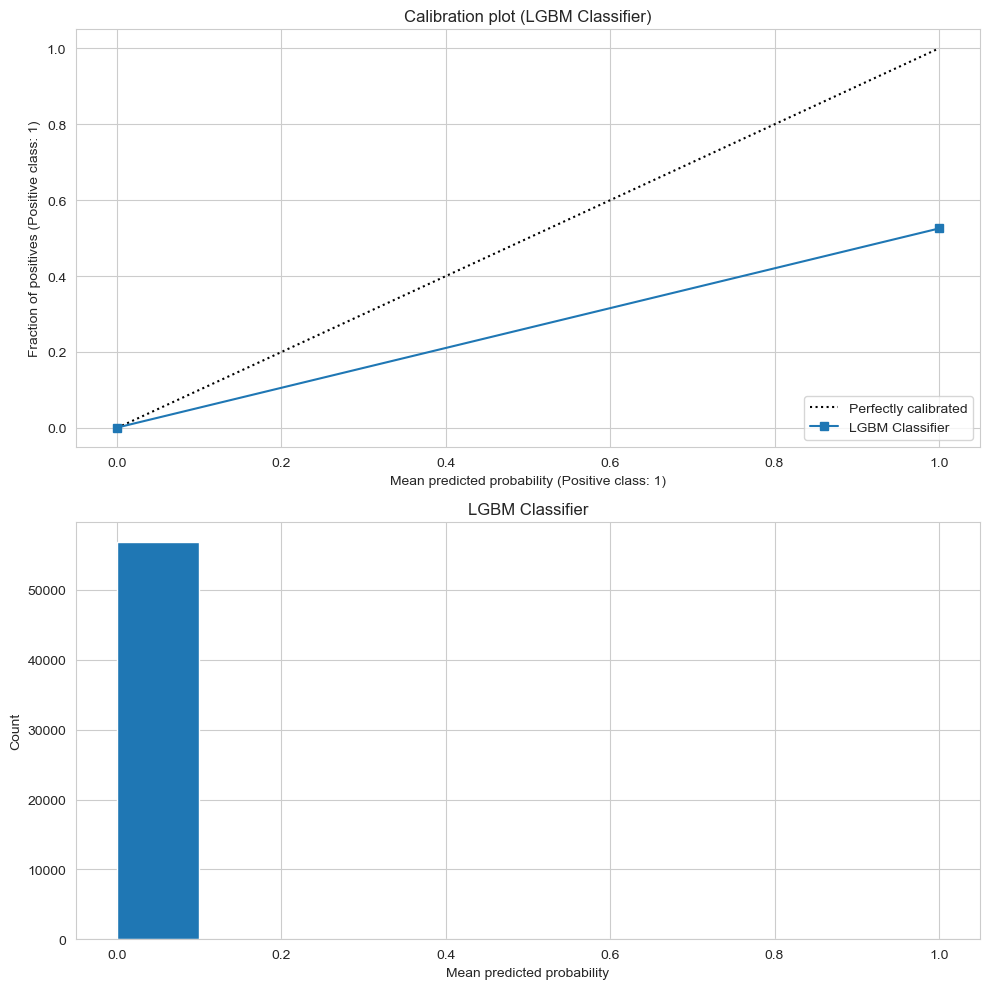

In [68]:
lgb_model = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)

performance_base_models_df,lgb_trained_model = evaluate_model_performance(lgb_model,'LGBM Classifier', verbose=True)

In [69]:
performance_base_models_df

Accuracy Precision    Recall        F1   ROC AUC  \
Naive Classifier          0.998683       0.0       0.0       0.0       0.5   
Logistic Regression       0.999122  0.735849      0.52  0.609375   0.97512   
Random Forest Classifier  0.999508  0.979592      0.64  0.774194  0.950738   
AdaBoost Classifier       0.999105  0.852941  0.386667   0.53211  0.955459   
CatBoost Classifier       0.999579  0.947368      0.72  0.818182  0.977466   
SVC                       0.999333       1.0  0.493333  0.660714  0.886845   
LGBM Classifier           0.998736  0.525424  0.413333  0.462687  0.669268   
XGBoost Classifier             NaN       NaN       NaN       NaN       NaN   

                               ECE  Log Loss Brier Loss  
Naive Classifier          0.001317  0.047457   0.001317  
Logistic Regression       0.256053  0.003402   0.000636  
Random Forest Classifier  0.155291  0.006108    0.00046  
AdaBoost Classifier       0.275029  0.480356   0.148149  
CatBoost Classifier        0.26019  0.003322   0.000417  
SVC                       0.518006   0.00486    0.00089  
LGBM Classifier           0.237674  0.044192   0.001264  
XGBoost Classifier             NaN       NaN        NaN

In [70]:
time_df

Execution Time (s)
Naive Classifier                   0.161237
Logistic Regression                2.786396
Random Forest Classifier           8.430789
AdaBoost Classifier               26.203363
CatBoost Classifier                6.666082
SVC                                28.05077
LGBM Classifier                    0.694168
XGBoost Classifier                      NaN

In [71]:
pio.renderers.default = 'colab'

# Extract feature importances from the Random Forest model
feature_importances = lgb_trained_model.feature_importances_
# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': train_df.drop(columns='Class').columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting using Plotly
fig = go.Figure(data=[
    go.Bar(x=features_df['Feature'], y=features_df['Importance'], marker_color='rgba(55, 128, 191, 0.7)')
])

fig.update_layout(title='Feature Importances from Ada Boost',
                  xaxis_title='Features',
                  yaxis_title='Importance',
                  xaxis_tickangle=-45)

fig.show()

In [ ]:
## XGBoost Classifier

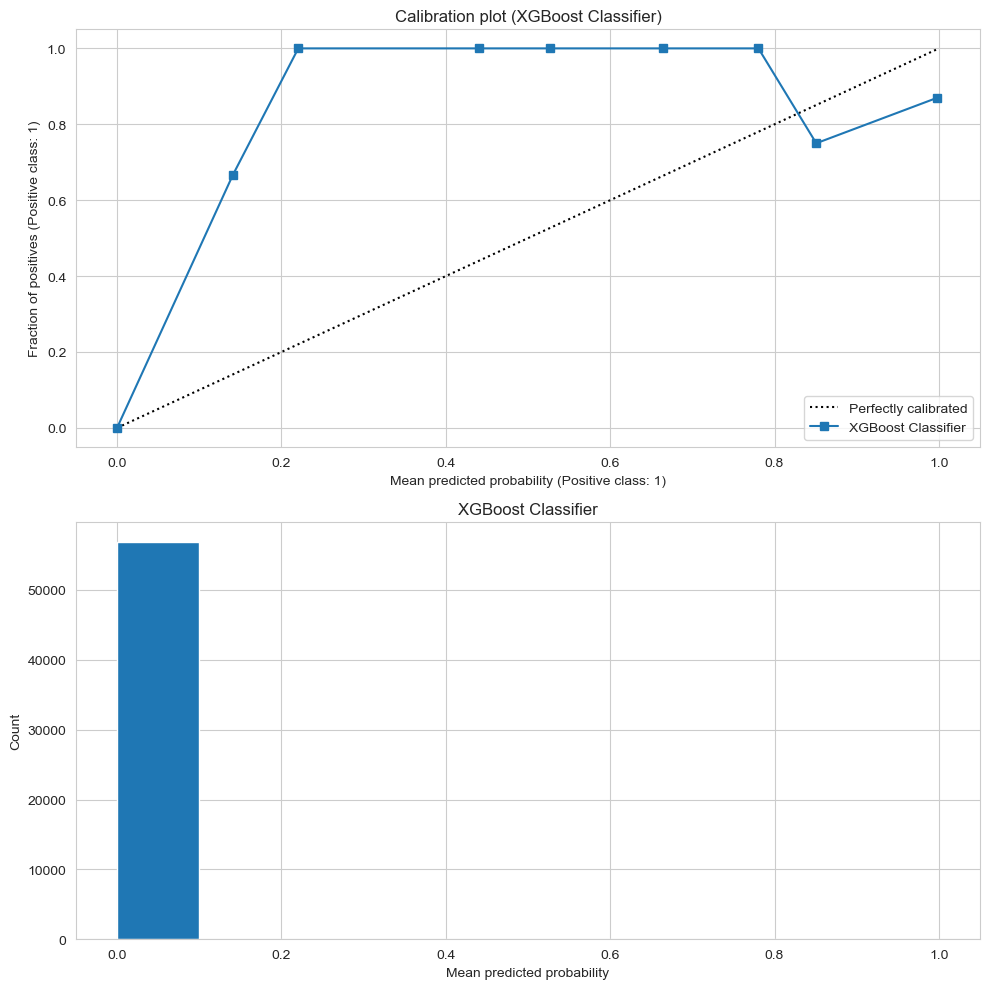

In [72]:
# # Train the XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_jobs=-1)

performance_base_models_df,xgb_trained_model = evaluate_model_performance(xgb_model,'XGBoost Classifier', verbose=True)

In [73]:
pio.renderers.default = 'colab'

# Extract feature importances from the Random Forest model
feature_importances = xgb_trained_model.feature_importances_
# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': train_df.drop(columns='Class').columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting using Plotly
fig = go.Figure(data=[
    go.Bar(x=features_df['Feature'], y=features_df['Importance'], marker_color='rgba(55, 128, 191, 0.7)')
])

fig.update_layout(title='Feature Importances from Ada Boost',
                  xaxis_title='Features',
                  yaxis_title='Importance',
                  xaxis_tickangle=-45)

fig.show()
     

In [74]:
performance_base_models_df

Accuracy Precision    Recall        F1   ROC AUC  \
Naive Classifier          0.998683       0.0       0.0       0.0       0.5   
Logistic Regression       0.999122  0.735849      0.52  0.609375   0.97512   
Random Forest Classifier  0.999508  0.979592      0.64  0.774194  0.950738   
AdaBoost Classifier       0.999105  0.852941  0.386667   0.53211  0.955459   
CatBoost Classifier       0.999579  0.947368      0.72  0.818182  0.977466   
SVC                       0.999333       1.0  0.493333  0.660714  0.886845   
LGBM Classifier           0.998736  0.525424  0.413333  0.462687  0.669268   
XGBoost Classifier        0.999368  0.867925  0.613333   0.71875  0.901388   

                               ECE  Log Loss Brier Loss  
Naive Classifier          0.001317  0.047457   0.001317  
Logistic Regression       0.256053  0.003402   0.000636  
Random Forest Classifier  0.155291  0.006108    0.00046  
AdaBoost Classifier       0.275029  0.480356   0.148149  
CatBoost Classifier        0.26019  0.003322   0.000417  
SVC                       0.518006   0.00486    0.00089  
LGBM Classifier           0.237674  0.044192   0.001264  
XGBoost Classifier         0.34704  0.006973   0.000601

In [75]:
time_df

Execution Time (s)
Naive Classifier                   0.161237
Logistic Regression                2.786396
Random Forest Classifier           8.430789
AdaBoost Classifier               26.203363
CatBoost Classifier                6.666082
SVC                                28.05077
LGBM Classifier                    0.694168
XGBoost Classifier                  0.50189

In [76]:
performance_base_models_df.to_csv('performance_base_models.csv')

In [77]:
performance_base_models_df.sort_values(['Log Loss',	'Brier Loss'], ascending = [True, True])

Accuracy Precision    Recall        F1   ROC AUC  \
CatBoost Classifier       0.999579  0.947368      0.72  0.818182  0.977466   
Logistic Regression       0.999122  0.735849      0.52  0.609375   0.97512   
SVC                       0.999333       1.0  0.493333  0.660714  0.886845   
Random Forest Classifier  0.999508  0.979592      0.64  0.774194  0.950738   
XGBoost Classifier        0.999368  0.867925  0.613333   0.71875  0.901388   
LGBM Classifier           0.998736  0.525424  0.413333  0.462687  0.669268   
Naive Classifier          0.998683       0.0       0.0       0.0       0.5   
AdaBoost Classifier       0.999105  0.852941  0.386667   0.53211  0.955459   

                               ECE  Log Loss Brier Loss  
CatBoost Classifier        0.26019  0.003322   0.000417  
Logistic Regression       0.256053  0.003402   0.000636  
SVC                       0.518006   0.00486    0.00089  
Random Forest Classifier  0.155291  0.006108    0.00046  
XGBoost Classifier         0.34704  0.006973   0.000601  
LGBM Classifier           0.237674  0.044192   0.001264  
Naive Classifier          0.001317  0.047457   0.001317  
AdaBoost Classifier       0.275029  0.480356   0.148149

In [78]:
performance_base_models_df.sort_values(['ECE'], ascending = True)

Accuracy Precision    Recall        F1   ROC AUC  \
Naive Classifier          0.998683       0.0       0.0       0.0       0.5   
Random Forest Classifier  0.999508  0.979592      0.64  0.774194  0.950738   
LGBM Classifier           0.998736  0.525424  0.413333  0.462687  0.669268   
Logistic Regression       0.999122  0.735849      0.52  0.609375   0.97512   
CatBoost Classifier       0.999579  0.947368      0.72  0.818182  0.977466   
AdaBoost Classifier       0.999105  0.852941  0.386667   0.53211  0.955459   
XGBoost Classifier        0.999368  0.867925  0.613333   0.71875  0.901388   
SVC                       0.999333       1.0  0.493333  0.660714  0.886845   

                               ECE  Log Loss Brier Loss  
Naive Classifier          0.001317  0.047457   0.001317  
Random Forest Classifier  0.155291  0.006108    0.00046  
LGBM Classifier           0.237674  0.044192   0.001264  
Logistic Regression       0.256053  0.003402   0.000636  
CatBoost Classifier        0.26019  0.003322   0.000417  
AdaBoost Classifier       0.275029  0.480356   0.148149  
XGBoost Classifier         0.34704  0.006973   0.000601  
SVC                       0.518006   0.00486    0.00089

In [79]:
performance_base_models_df.sort_values(['Log Loss', "Brier Loss"])

Accuracy Precision    Recall        F1   ROC AUC  \
CatBoost Classifier       0.999579  0.947368      0.72  0.818182  0.977466   
Logistic Regression       0.999122  0.735849      0.52  0.609375   0.97512   
SVC                       0.999333       1.0  0.493333  0.660714  0.886845   
Random Forest Classifier  0.999508  0.979592      0.64  0.774194  0.950738   
XGBoost Classifier        0.999368  0.867925  0.613333   0.71875  0.901388   
LGBM Classifier           0.998736  0.525424  0.413333  0.462687  0.669268   
Naive Classifier          0.998683       0.0       0.0       0.0       0.5   
AdaBoost Classifier       0.999105  0.852941  0.386667   0.53211  0.955459   

                               ECE  Log Loss Brier Loss  
CatBoost Classifier        0.26019  0.003322   0.000417  
Logistic Regression       0.256053  0.003402   0.000636  
SVC                       0.518006   0.00486    0.00089  
Random Forest Classifier  0.155291  0.006108    0.00046  
XGBoost Classifier         0.34704  0.006973   0.000601  
LGBM Classifier           0.237674  0.044192   0.001264  
Naive Classifier          0.001317  0.047457   0.001317  
AdaBoost Classifier       0.275029  0.480356   0.148149

In [80]:
time_df.columns

Index(['Execution Time (s)'], dtype='object')

In [81]:
time_df.sort_values('Execution Time (s)', ascending = True)

Execution Time (s)
Naive Classifier                   0.161237
XGBoost Classifier                  0.50189
LGBM Classifier                    0.694168
Logistic Regression                2.786396
CatBoost Classifier                6.666082
Random Forest Classifier           8.430789
AdaBoost Classifier               26.203363
SVC                                28.05077

## Investigate Resampling Techniques

In [82]:
resampled_time_df = pd.DataFrame(index = time_df.index, columns = time_df.columns)

resampled_time_df

Execution Time (s)
Naive Classifier                        NaN
Logistic Regression                     NaN
Random Forest Classifier                NaN
AdaBoost Classifier                     NaN
CatBoost Classifier                     NaN
SVC                                     NaN
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

In [83]:
performance_resampling_methods_df = pd.DataFrame(index = metrics, columns = ['RandomOverSampler','SMOTE', 'ADASYN', 'RandomUnderSampler', 'NearMiss', 'TomekLinks', 'EditedNearestNeighbours'])

In [84]:
def evaluate_resampled_model_performance(model, model_name, sampler, true_labels=true_labels, performance_df=performance_resampling_methods_df, verbose=False):
    """
    Evaluates model performance and updates the performance dataframe with metrics.

    Args:
    - predictions (array-like): Predicted values from the model.
    - model_name (str): Name of the model for which performance is being evaluated.
    - true_labels (array-like): Actual labels for comparison. Default is the true_labels of the test set.
    - performance_df (DataFrame): DataFrame to update with model performance metrics.

    Returns:
    - DataFrame with updated performance metrics for the given model.
    """

    start_time = time.time()  # Record start time

    technique = sampler.__class__.__name__

    X_resampled, y_resampled = sampler.fit_resample(train_df.drop(columns='Class'), train_df['Class'])

    # Train Logistic Regression
    model.fit(X_resampled, y_resampled)

    # Predict class score on the test set
    prob_pos = model.predict_proba(test_df.drop(columns='Class'))[:, 1]
    # Predict on the test set
    predictions = model.predict(test_df.drop(columns='Class'))

    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, prob_pos)
    logloss = log_loss(true_labels, prob_pos)
    brier_loss = brier_score_loss(true_labels, prob_pos)

    # Compute Expected Calibration Error (ECE)
    fraction_of_positives, mean_predicted_value = calibration_curve(true_labels, prob_pos, n_bins=10)
    ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value)) / len(mean_predicted_value)

    # Populate the performance dataframe
    performance_resampling_methods_df[technique] = [accuracy, precision, recall, f1, roc_auc, ece, logloss, brier_loss]

    # Plot calibration curve and histogram if verbose is True
    if verbose:
        fig = plt.figure(figsize=(10, 10))
        gs = GridSpec(2, 1)
        ax_calibration_curve = fig.add_subplot(gs[0, :])
        ax_histogram = fig.add_subplot(gs[1, :])

        # Plot calibration curve
        CalibrationDisplay.from_estimator(
            model,
            test_df.drop(columns='Class'),
            true_labels,
            n_bins=10,
            name=model_name,
            ax=ax_calibration_curve
        )
        ax_calibration_curve.set_title(f"Calibration plot ({model_name})")

        # Plot histogram
        ax_histogram.hist(prob_pos, range=(0, 1), bins=10, label=model_name)
        ax_histogram.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")

        plt.tight_layout()
        plt.show()

    end_time = time.time()  # Record end time
    execution_time = end_time - start_time  # Calculate execution time in seconds

    # Record execution time in the time DataFrame
    resampled_time_df.loc[model_name, 'Execution Time (s)'] = execution_time

    return performance_df,model

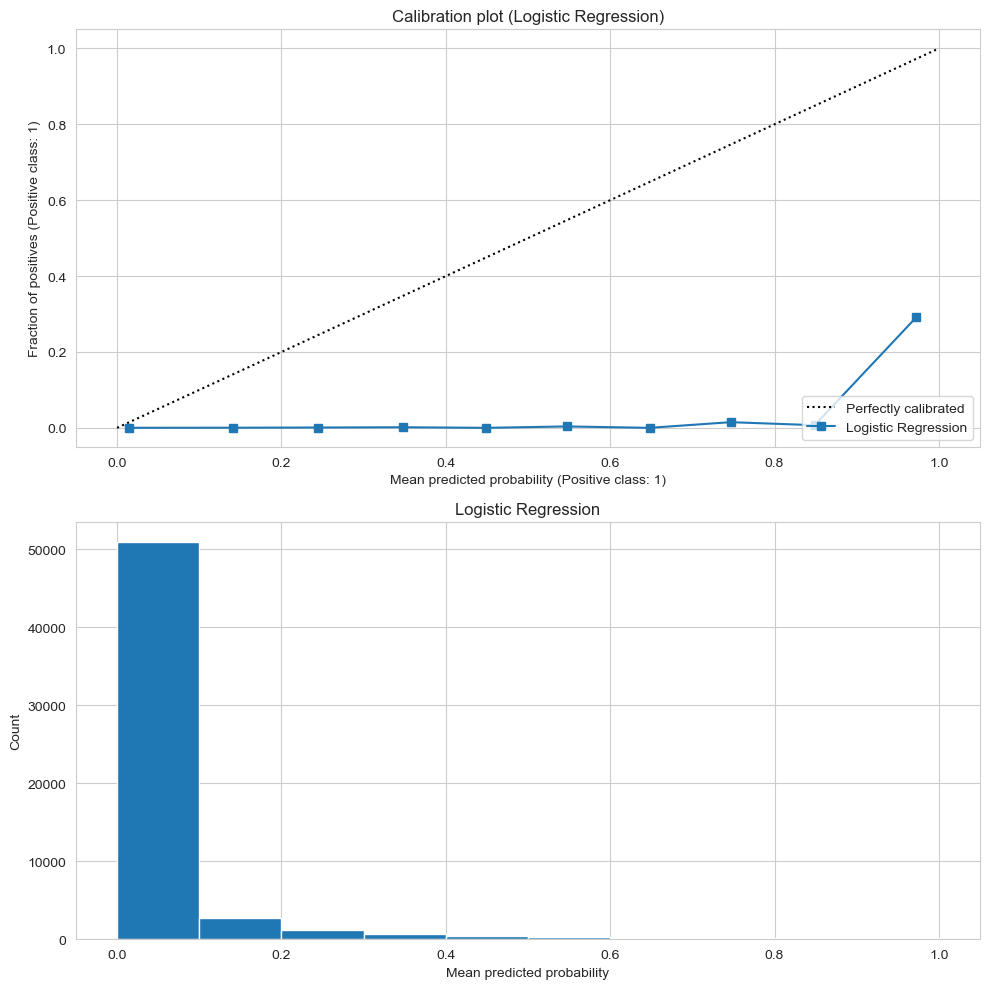

In [85]:
# Train Logistic Regression
logistic_regression_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

performance_resampling_methods_df,_ = evaluate_resampled_model_performance(logistic_regression_model,'Logistic Regression', sampler = SMOTE(), verbose=True)

In [86]:
performance_resampling_methods_df

RandomOverSampler     SMOTE ADASYN RandomUnderSampler NearMiss  \
Accuracy                 NaN  0.984095    NaN                NaN      NaN   
Precision                NaN  0.068536    NaN                NaN      NaN   
Recall                   NaN  0.880000    NaN                NaN      NaN   
F1                       NaN  0.127168    NaN                NaN      NaN   
ROC AUC                  NaN  0.977937    NaN                NaN      NaN   
ECE                      NaN  0.463956    NaN                NaN      NaN   
Log Loss                 NaN  0.063396    NaN                NaN      NaN   
Brier Loss               NaN  0.014283    NaN                NaN      NaN   

           TomekLinks EditedNearestNeighbours  
Accuracy          NaN                     NaN  
Precision         NaN                     NaN  
Recall            NaN                     NaN  
F1                NaN                     NaN  
ROC AUC           NaN                     NaN  
ECE               NaN                     NaN  
Log Loss          NaN                     NaN  
Brier Loss        NaN                     NaN

## Logistic Regression with Resampling Methods

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Technique: RandomOverSampler


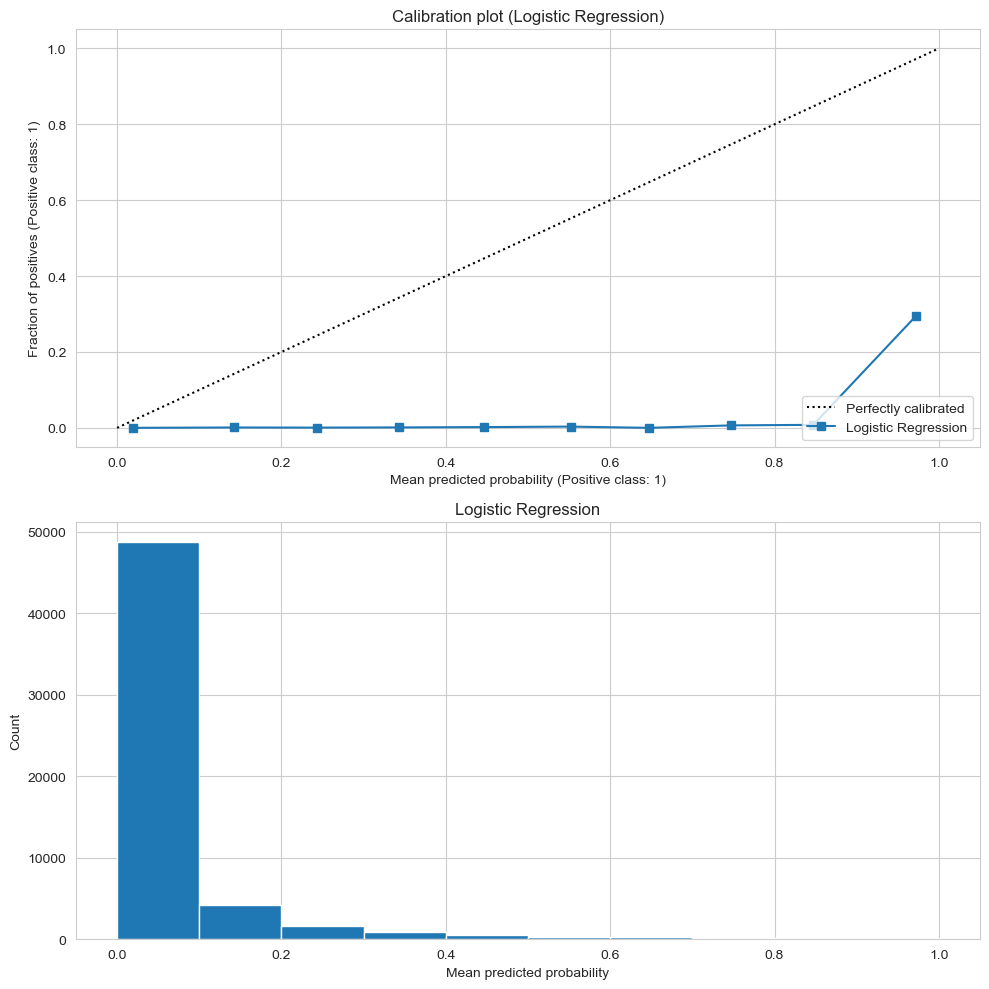

 14%|██████▍                                      | 1/7 [00:07<00:46,  7.81s/it]

Technique: SMOTE


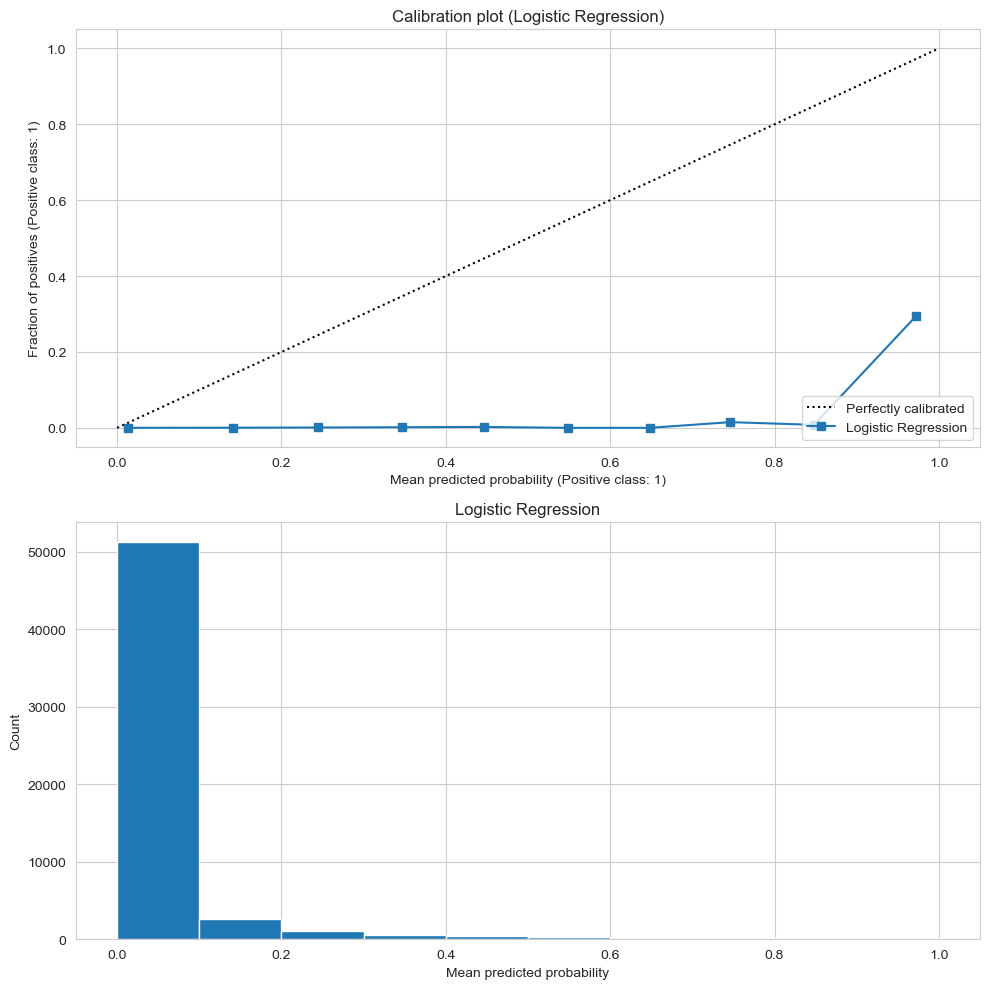

 29%|████████████▊                                | 2/7 [00:34<01:34, 18.87s/it]

Technique: ADASYN


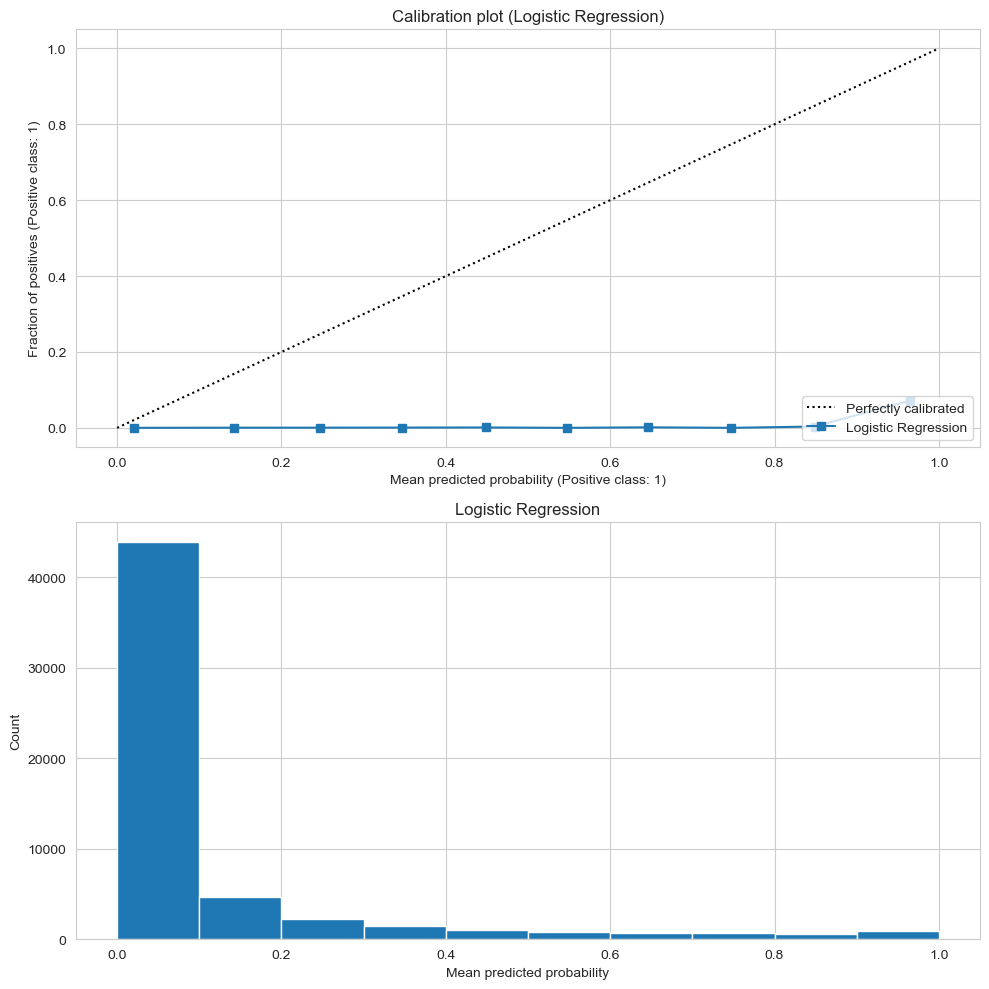

 43%|███████████████████▎                         | 3/7 [01:16<01:57, 29.41s/it]

Technique: RandomUnderSampler


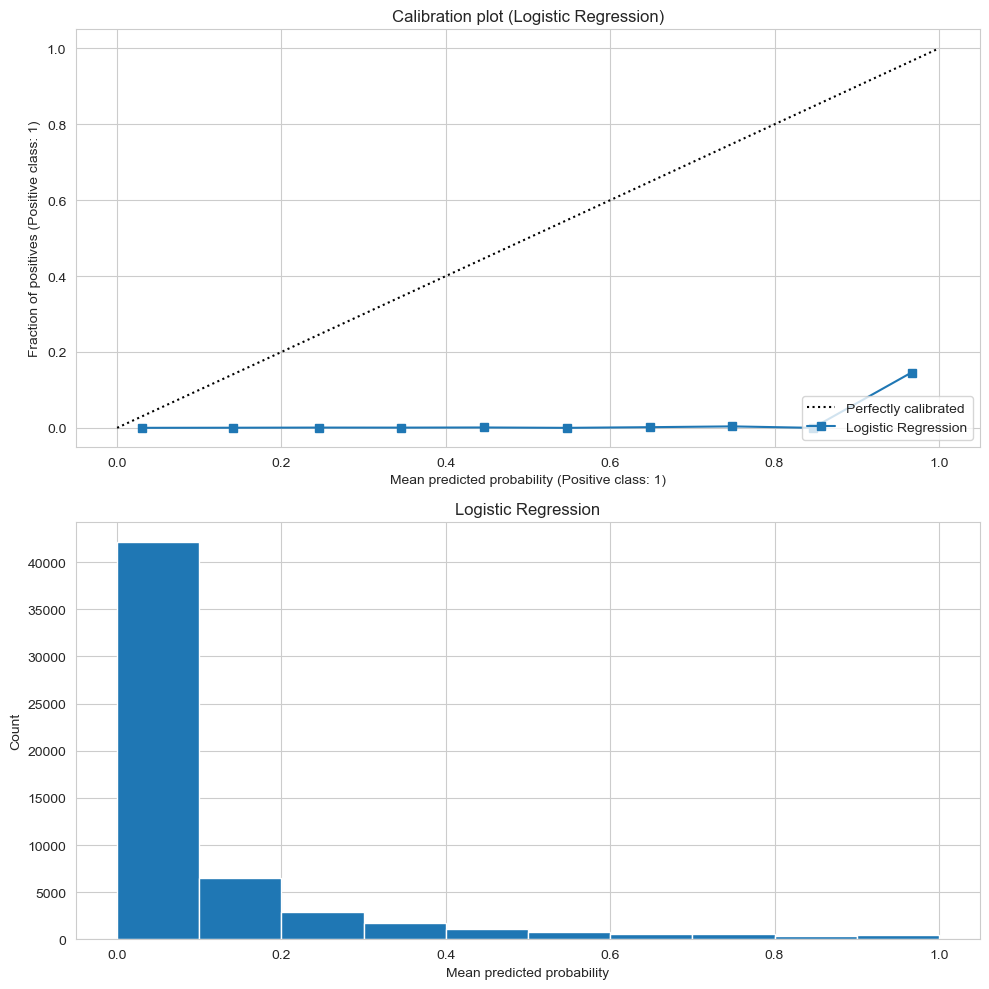

 57%|█████████████████████████▋                   | 4/7 [01:22<01:00, 20.26s/it]

Technique: NearMiss


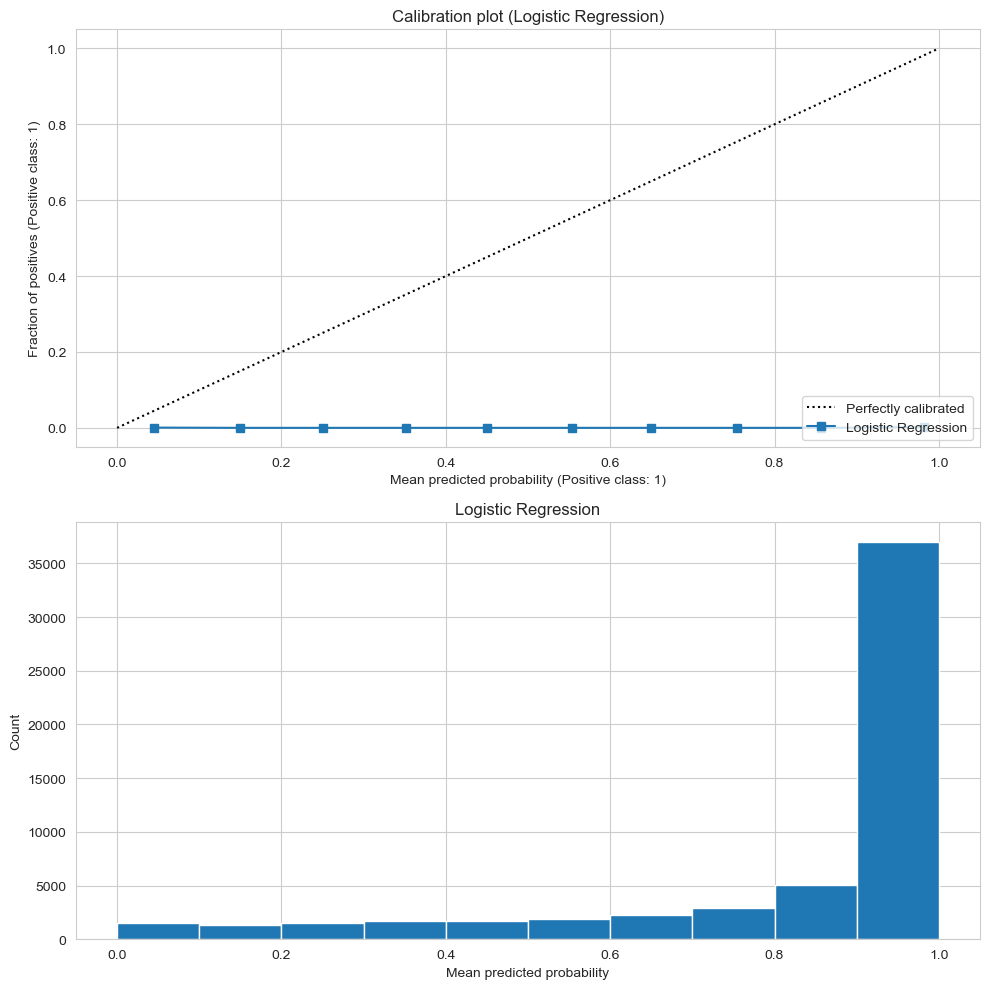

 71%|████████████████████████████████▏            | 5/7 [01:32<00:32, 16.45s/it]

Technique: TomekLinks


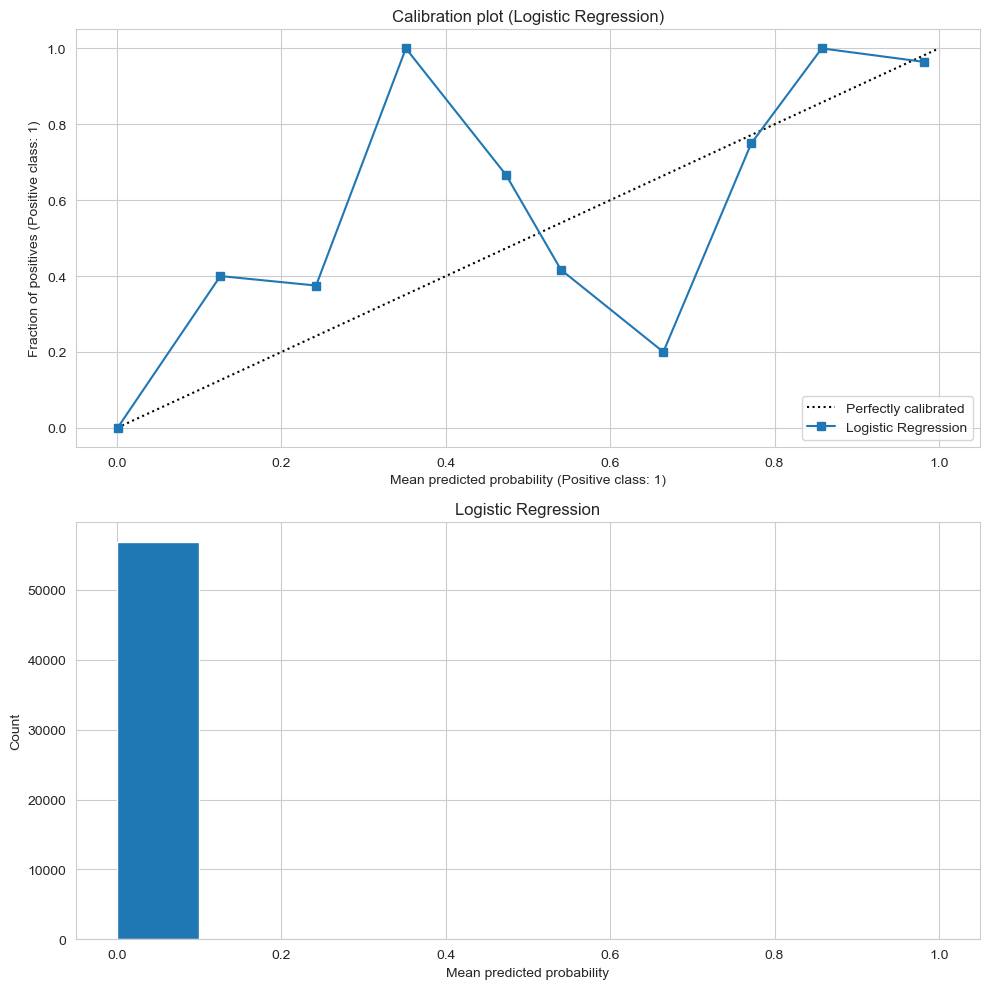

 86%|██████████████████████████████████████▌      | 6/7 [01:45<00:15, 15.41s/it]

Technique: EditedNearestNeighbours


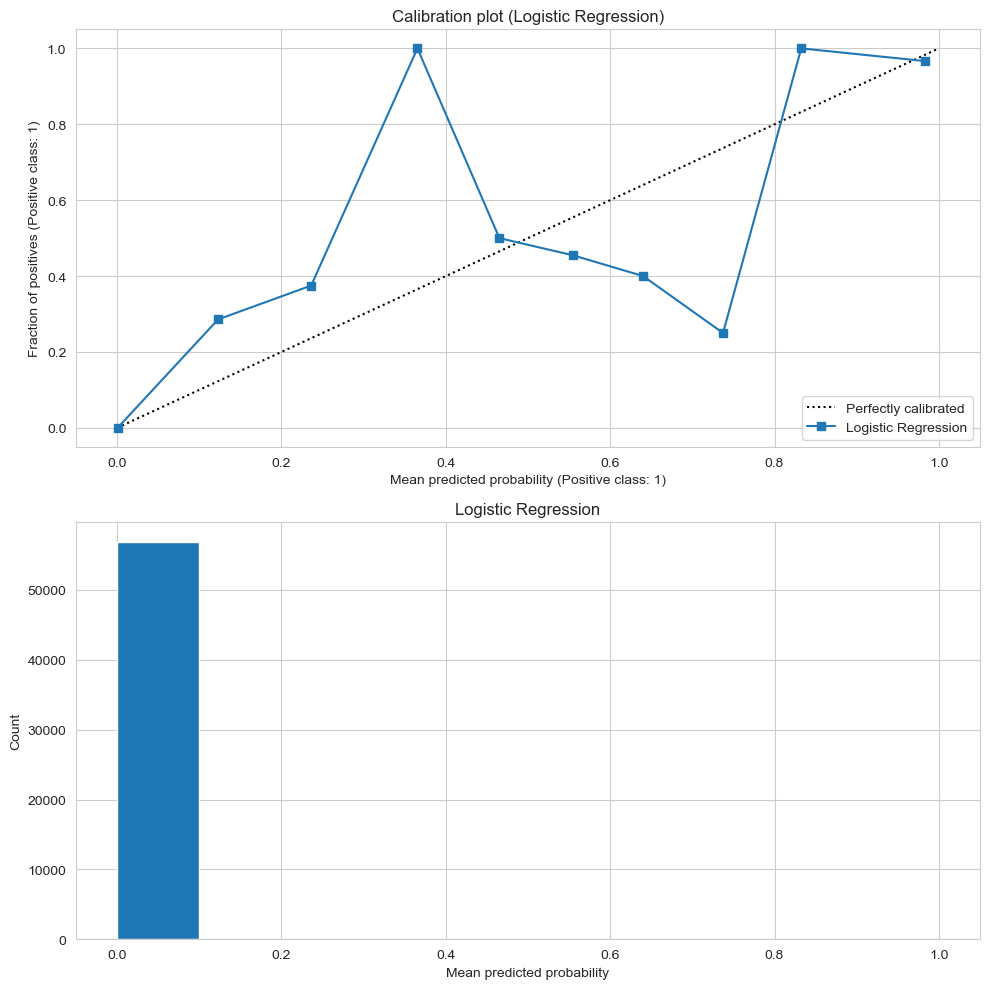

100%|█████████████████████████████████████████████| 7/7 [01:57<00:00, 16.85s/it]


In [87]:
techniques = [RandomOverSampler(), SMOTE(), ADASYN(), RandomUnderSampler(), NearMiss(version=1), TomekLinks(), EditedNearestNeighbours()]

for sampler in tqdm(techniques):
    technique = sampler.__class__.__name__
    print(f'Technique: {technique}')
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    performance_resampling_methods_df,_ = evaluate_resampled_model_performance(logistic_regression_model,'Logistic Regression',
                                                                               sampler = sampler,
                                                                               verbose=True)

In [88]:
performance_resampling_methods_df

RandomOverSampler     SMOTE    ADASYN  RandomUnderSampler  \
Accuracy             0.982989  0.984902  0.936800            0.954970   
Precision            0.064327  0.071038  0.018574            0.025534   
Recall               0.880000  0.866667  0.906667            0.893333   
F1                   0.119891  0.131313  0.036403            0.049648   
ROC AUC              0.984104  0.978494  0.981285            0.980822   
ECE                  0.464081  0.463167  0.488033            0.481243   
Log Loss             0.077184  0.060401  0.184049            0.154395   
Brier Loss           0.016541  0.013514  0.048645            0.037683   

            NearMiss  TomekLinks  EditedNearestNeighbours  
Accuracy    0.138355    0.999157                 0.999192  
Precision   0.001505    0.754717                 0.763636  
Recall      0.986667    0.533333                 0.560000  
F1          0.003006    0.625000                 0.646154  
ROC AUC     0.886840    0.975006                 0.976378  
ECE         0.503872    0.202023                 0.198272  
Log Loss    4.423928    0.003368                 0.003309  
Brier Loss  0.758439    0.000626                 0.000608

## Logistic Regression with Resampling Methods

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Technique: RandomOverSampler


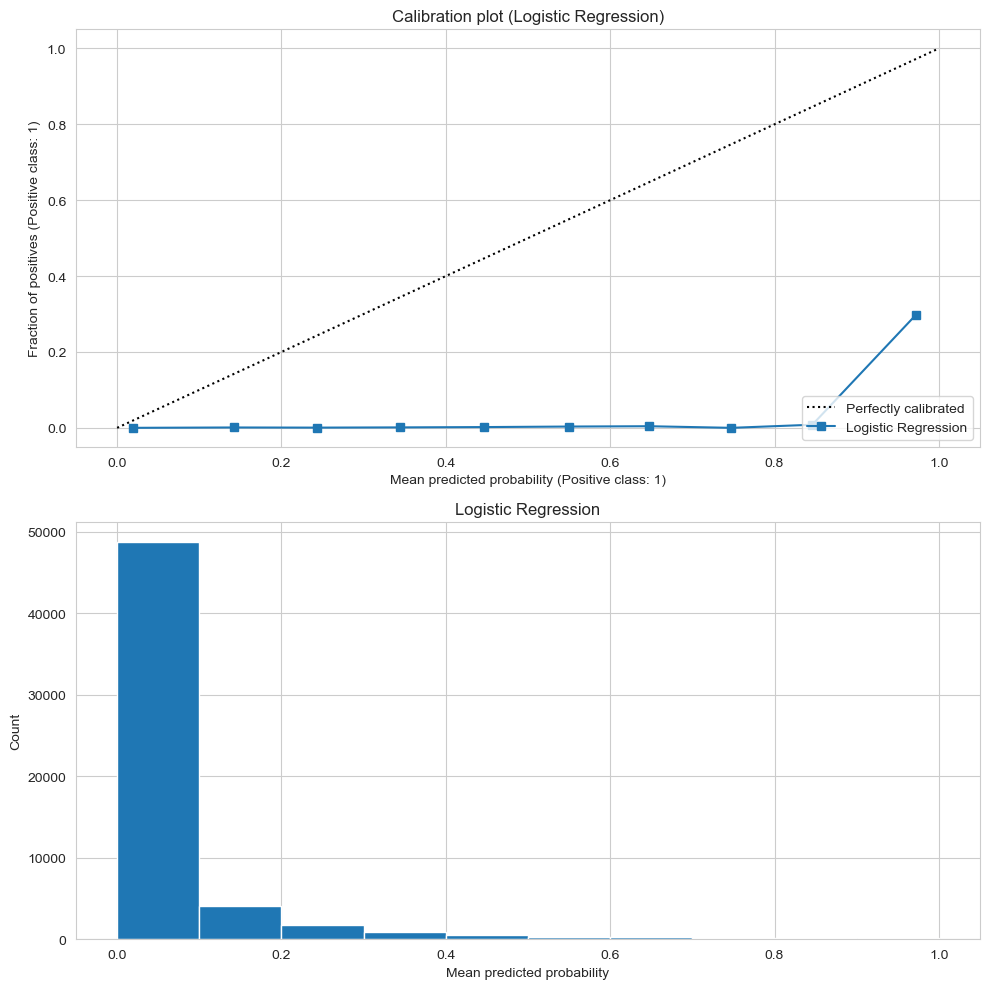

 14%|██████▍                                      | 1/7 [00:07<00:44,  7.39s/it]

Technique: SMOTE


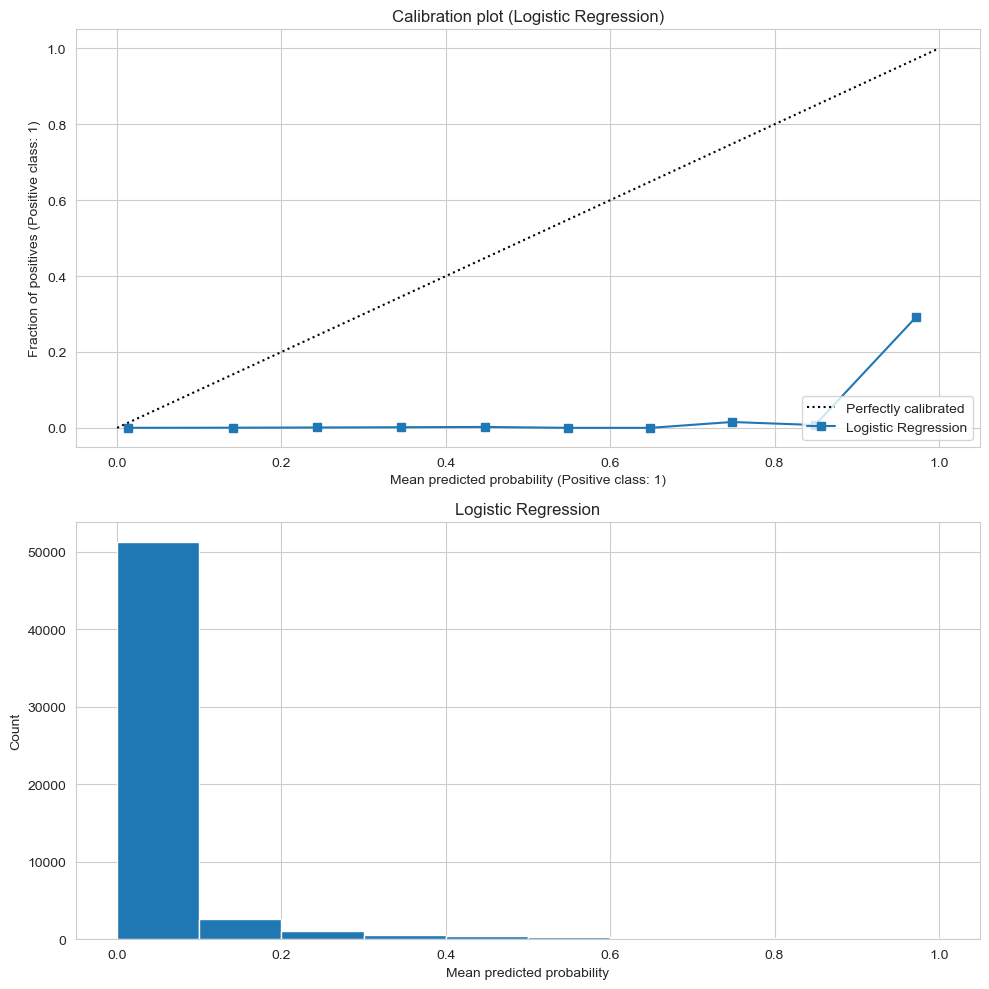

 29%|████████████▊                                | 2/7 [00:34<01:35, 19.00s/it]

Technique: ADASYN


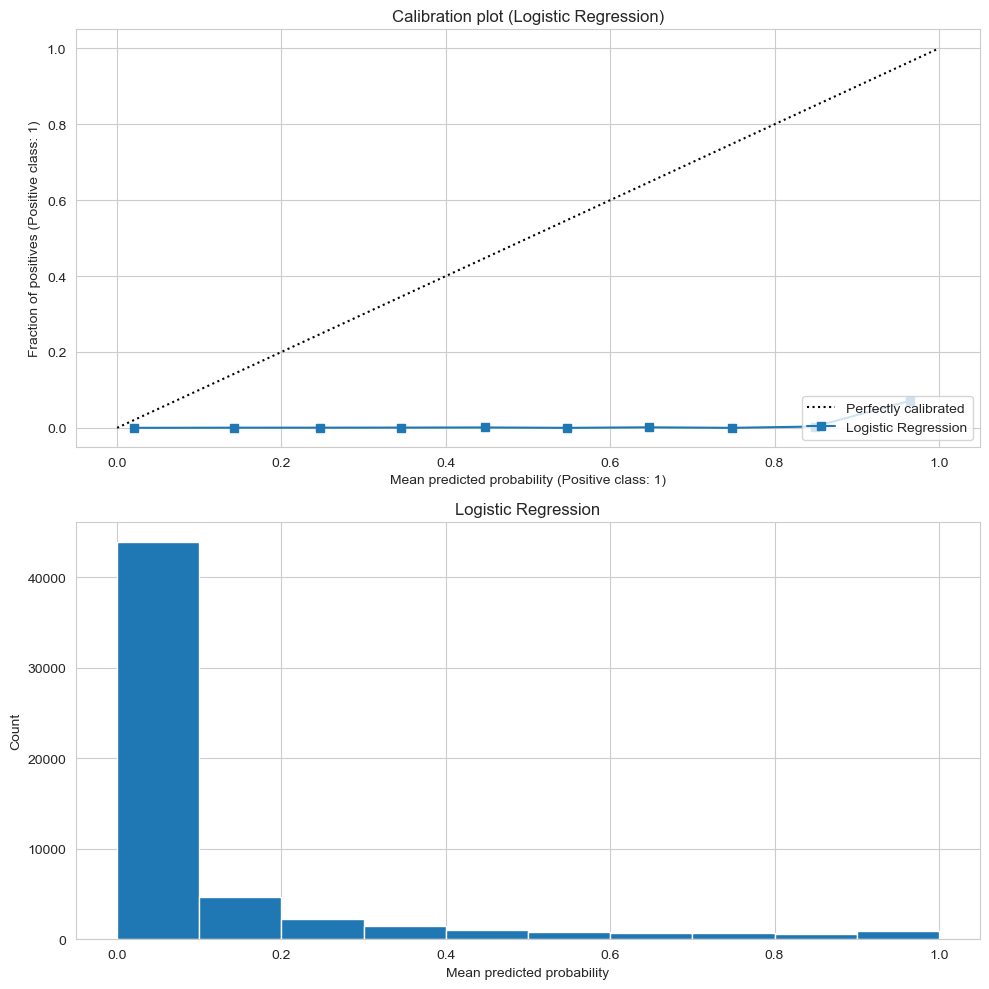

 43%|███████████████████▎                         | 3/7 [01:23<02:11, 32.92s/it]

Technique: RandomUnderSampler


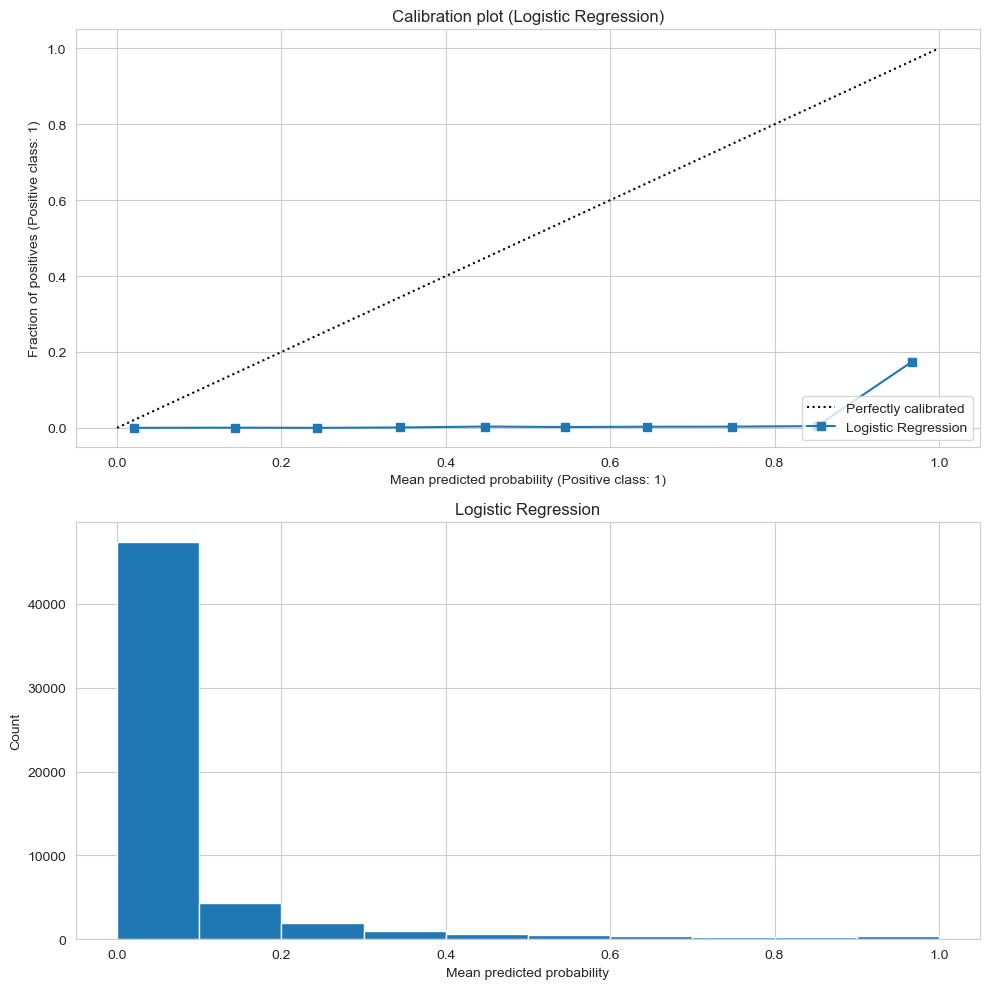

 57%|█████████████████████████▋                   | 4/7 [01:35<01:12, 24.28s/it]

Technique: NearMiss


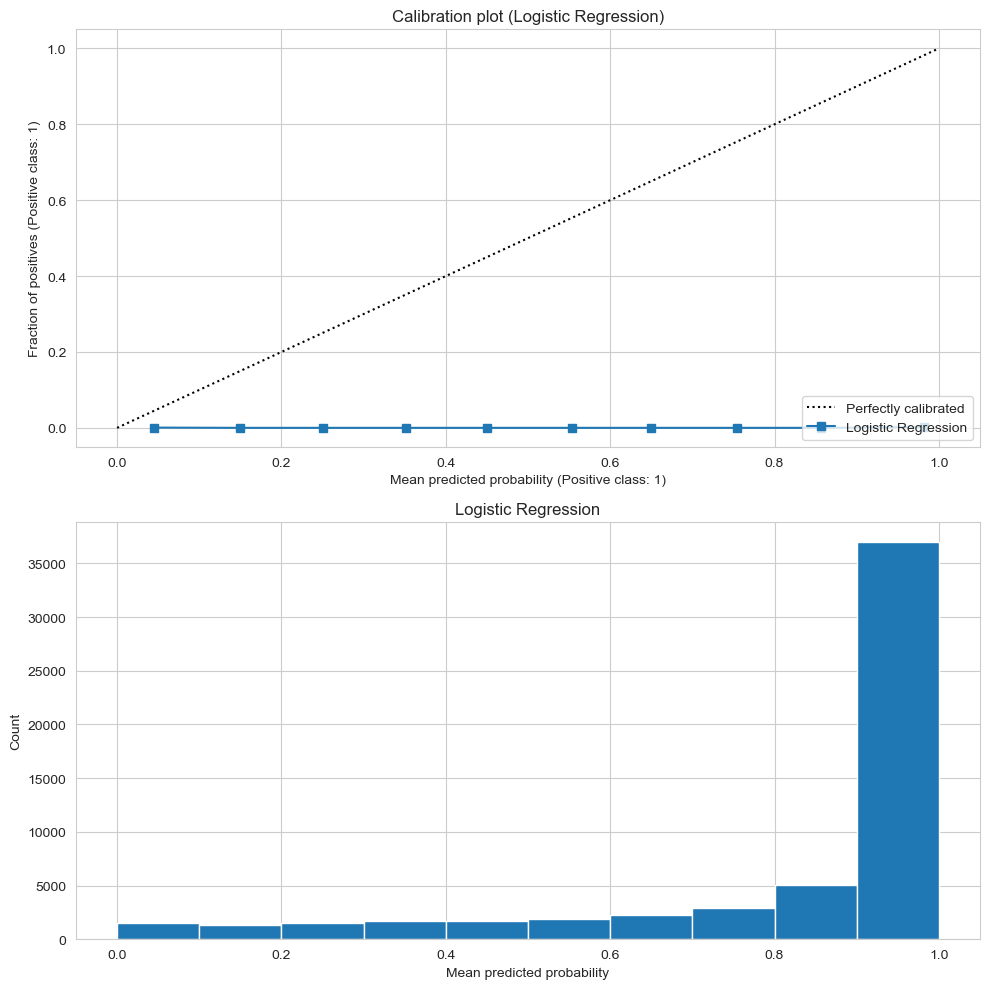

 71%|████████████████████████████████▏            | 5/7 [01:45<00:38, 19.23s/it]

Technique: TomekLinks


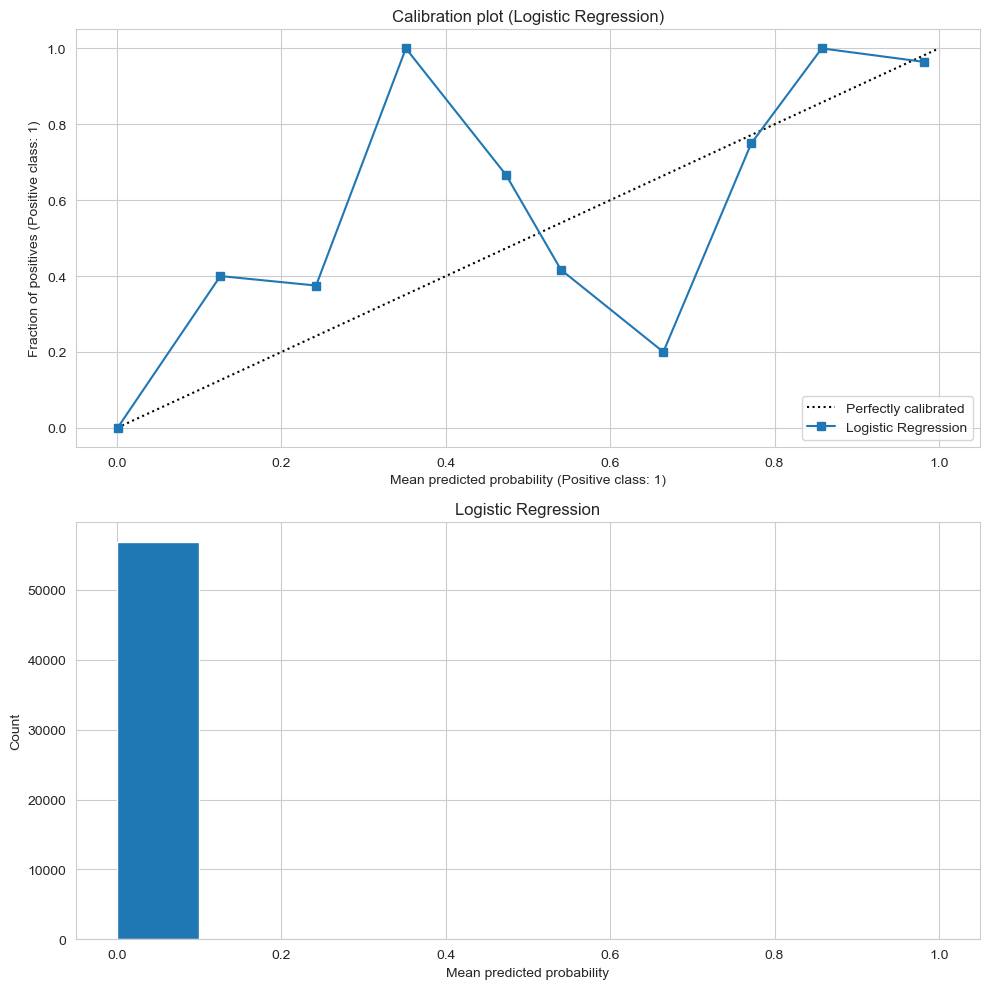

 86%|██████████████████████████████████████▌      | 6/7 [01:58<00:17, 17.18s/it]

Technique: EditedNearestNeighbours


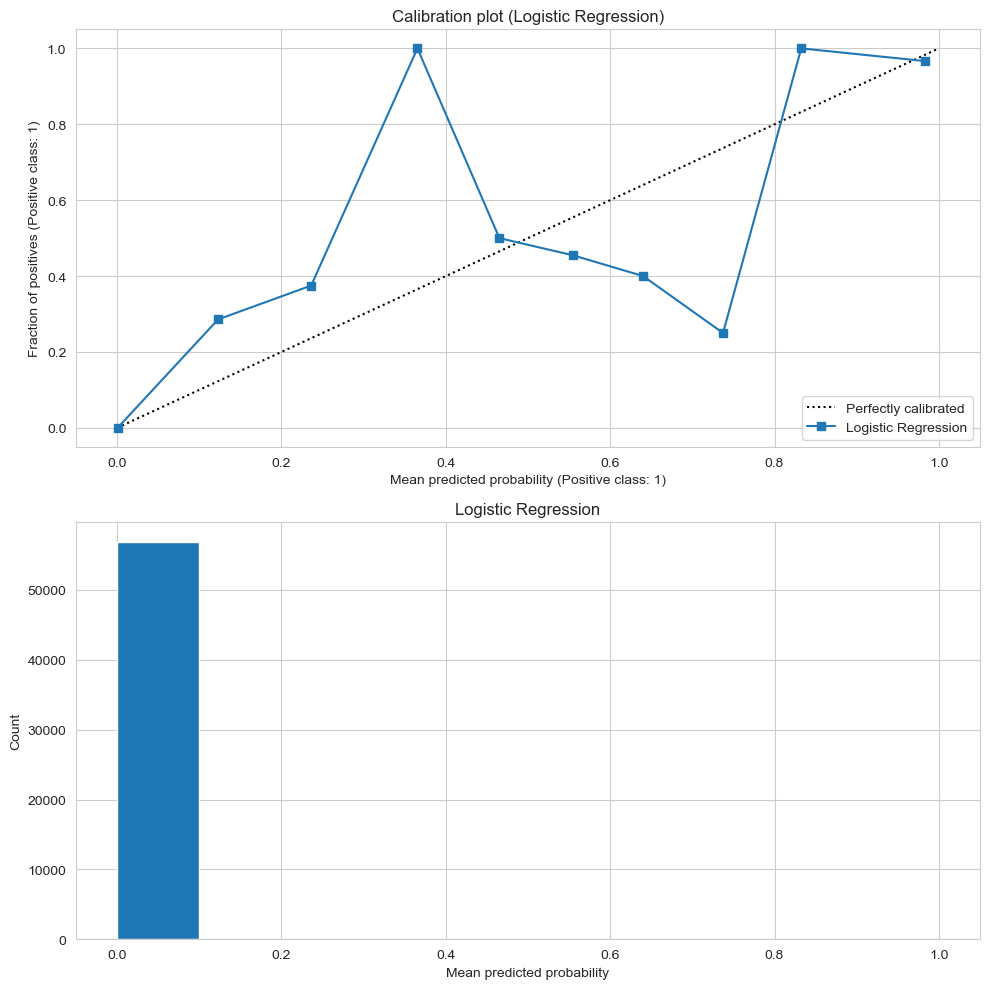

100%|█████████████████████████████████████████████| 7/7 [02:11<00:00, 18.79s/it]


In [89]:
techniques = [RandomOverSampler(), SMOTE(), ADASYN(), RandomUnderSampler(), NearMiss(version=1), TomekLinks(), EditedNearestNeighbours()]

for sampler in tqdm(techniques):
    technique = sampler.__class__.__name__
    print(f'Technique: {technique}')
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    performance_resampling_methods_df,_ = evaluate_resampled_model_performance(logistic_regression_model,'Logistic Regression',
                                                                               sampler = sampler,
                                                                               verbose=True)

In [90]:
resampled_time_df

Execution Time (s)
Naive Classifier                        NaN
Logistic Regression               13.038276
Random Forest Classifier                NaN
AdaBoost Classifier                     NaN
CatBoost Classifier                     NaN
SVC                                     NaN
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

In [91]:
performance_resampling_methods_df

RandomOverSampler     SMOTE    ADASYN  RandomUnderSampler  \
Accuracy             0.983129  0.984656  0.936537            0.971191   
Precision            0.064833  0.069968  0.018498            0.038869   
Recall               0.880000  0.866667  0.906667            0.880000   
F1                   0.120769  0.129482  0.036257            0.074450   
ROC AUC              0.984095  0.978421  0.981401            0.977814   
ECE                  0.463956  0.463821  0.487991            0.476472   
Log Loss             0.076463  0.061140  0.184337            0.108838   
Brier Loss           0.016383  0.013756  0.048685            0.024351   

            NearMiss  TomekLinks  EditedNearestNeighbours  
Accuracy    0.138355    0.999157                 0.999192  
Precision   0.001505    0.754717                 0.763636  
Recall      0.986667    0.533333                 0.560000  
F1          0.003006    0.625000                 0.646154  
ROC AUC     0.886840    0.975006                 0.976378  
ECE         0.503872    0.202023                 0.198272  
Log Loss    4.423928    0.003368                 0.003309  
Brier Loss  0.758439    0.000626                 0.000608

In [92]:
lr_performance_resampling_methods_df = performance_resampling_methods_df.copy()

performance_resampling_methods_df[:] = np.nan

In [93]:
lr_performance_resampling_methods_df.to_csv('lr_performance_resampling_methods.csv')

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Technique: RandomOverSampler


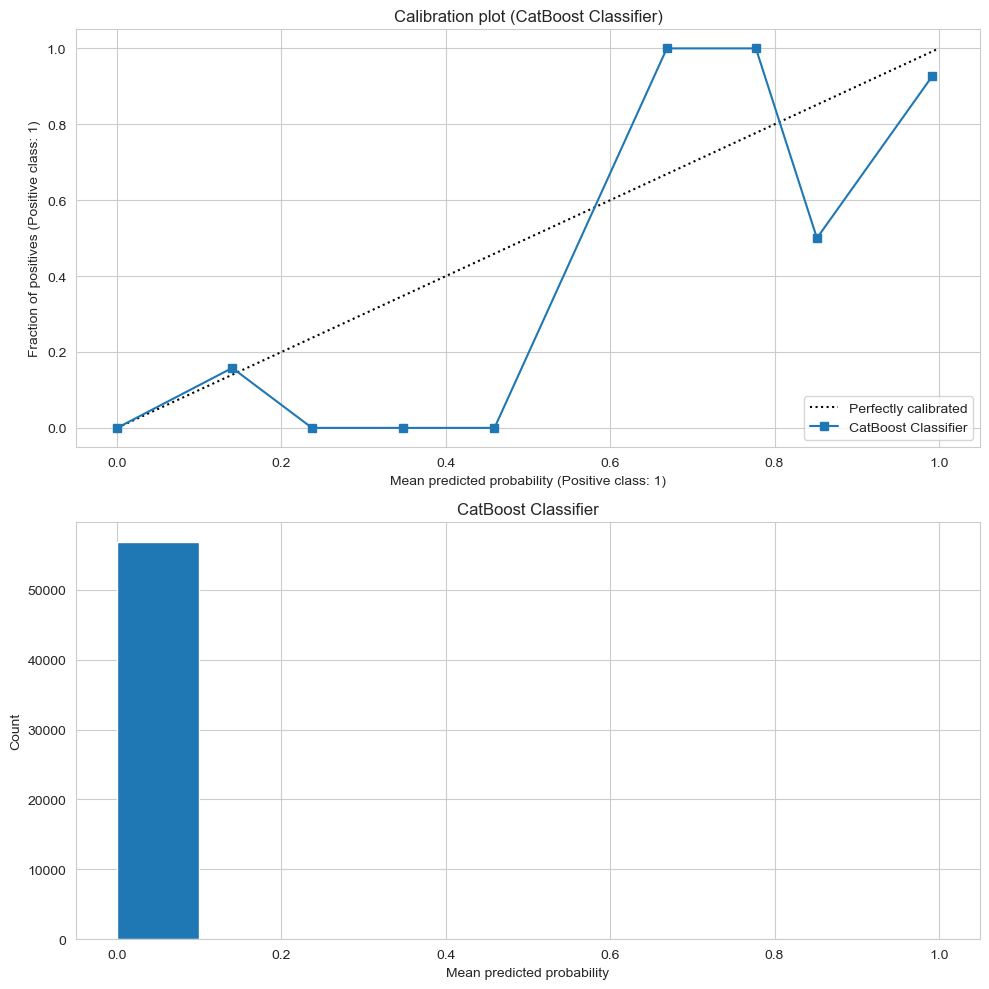

 14%|██████▍                                      | 1/7 [00:08<00:52,  8.80s/it]

Technique: SMOTE


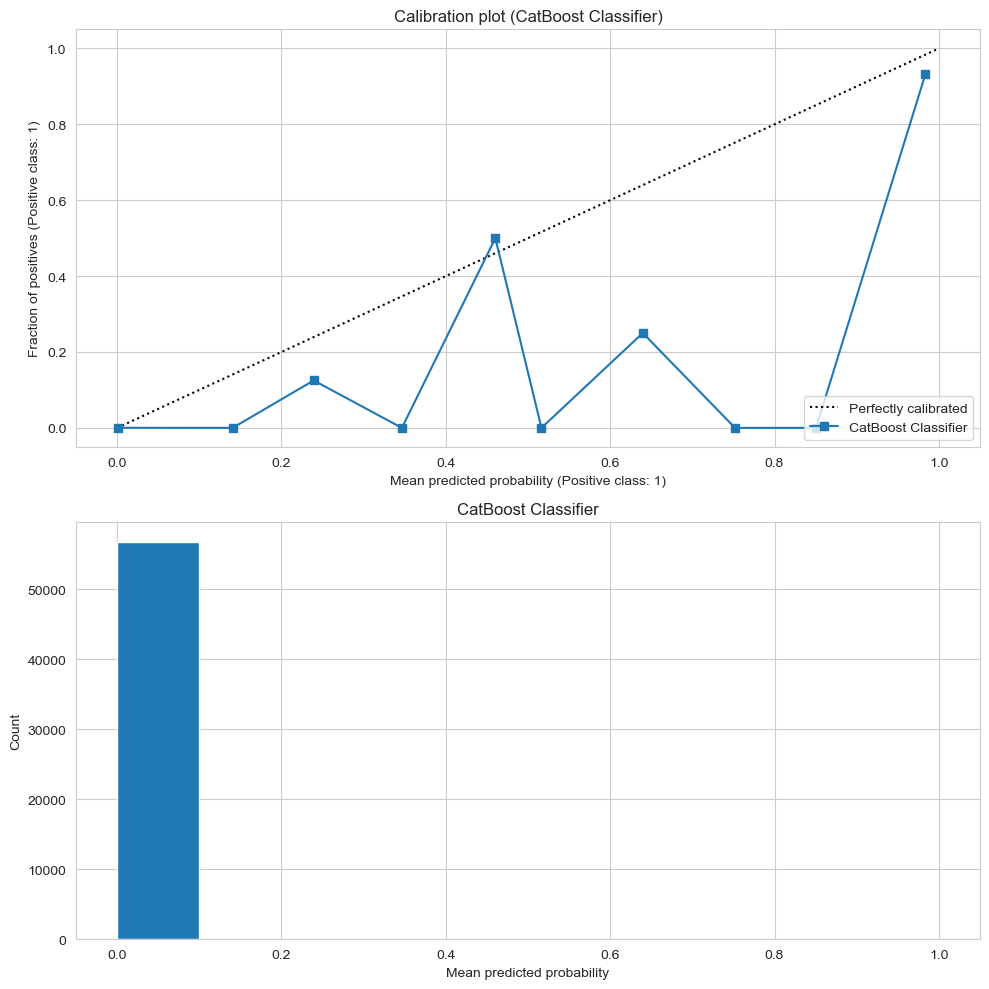

 29%|████████████▊                                | 2/7 [00:17<00:43,  8.65s/it]

Technique: ADASYN


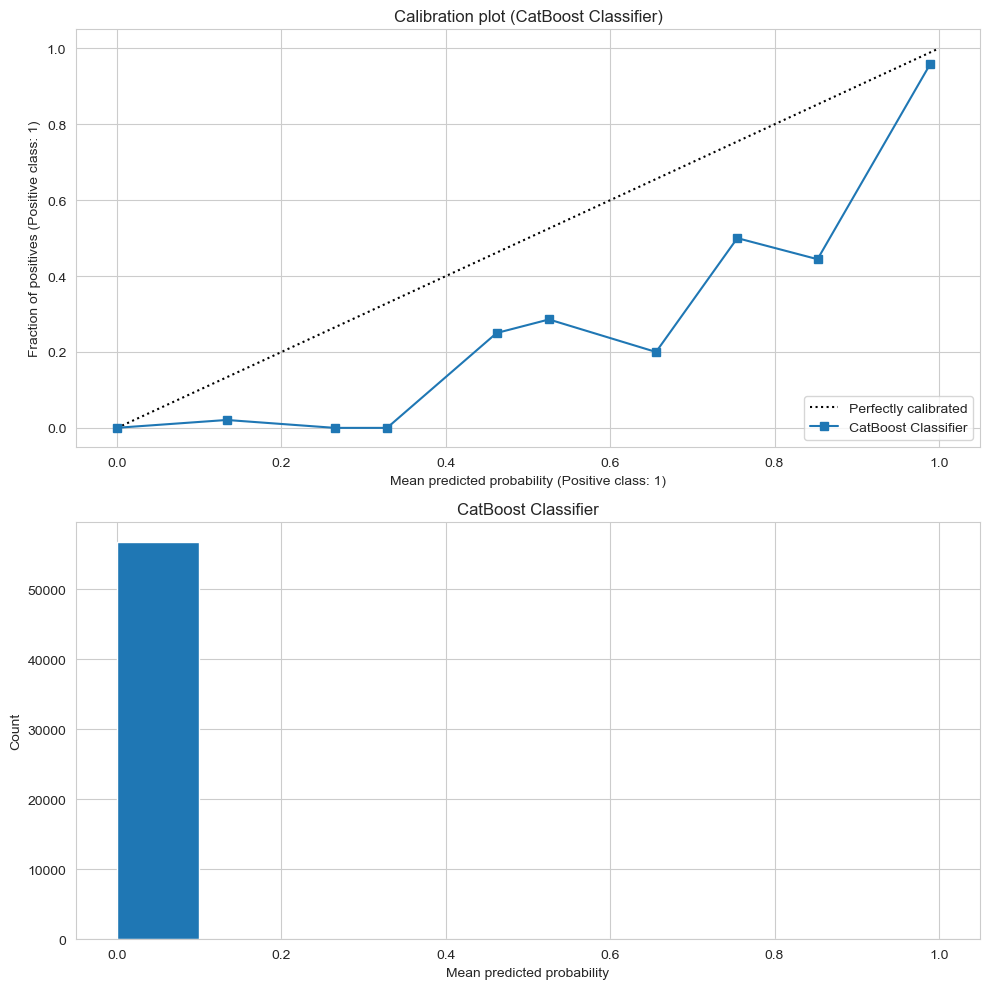

 43%|███████████████████▎                         | 3/7 [00:26<00:35,  8.96s/it]

Technique: RandomUnderSampler


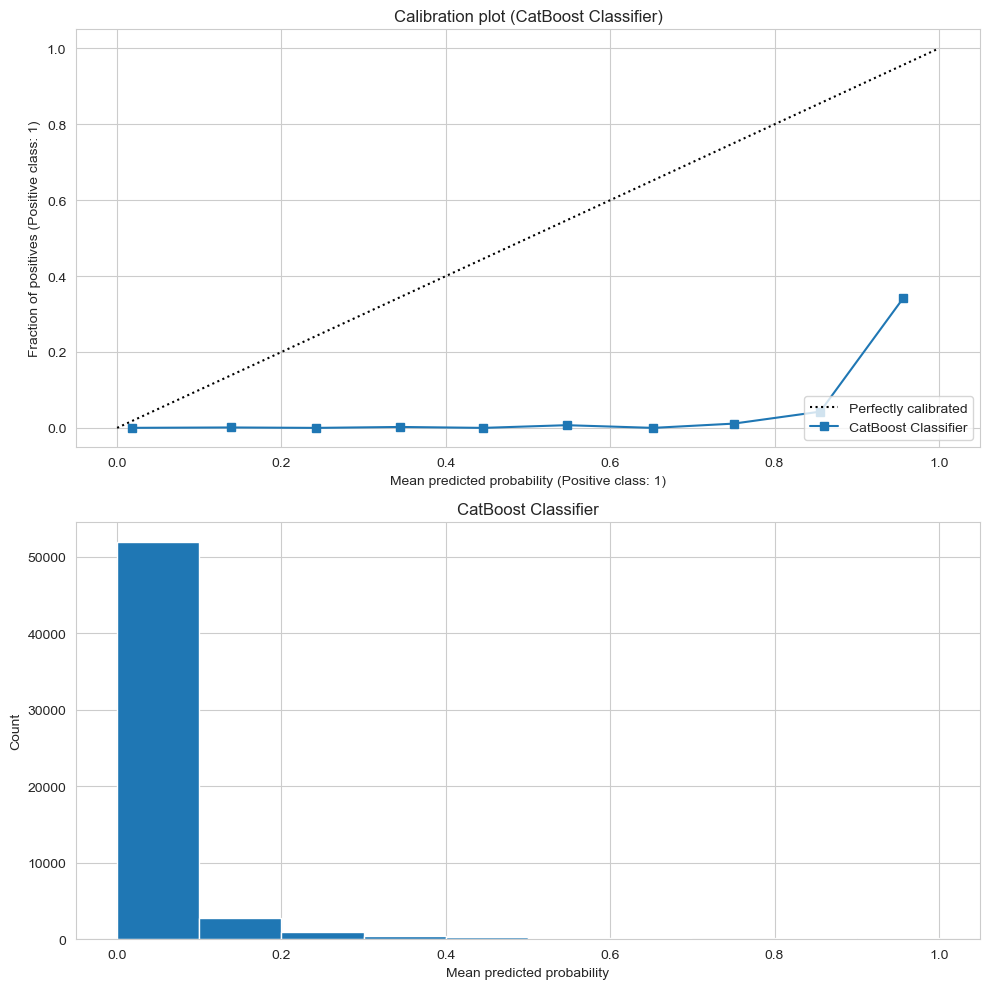

 57%|█████████████████████████▋                   | 4/7 [00:27<00:17,  5.85s/it]

Technique: NearMiss


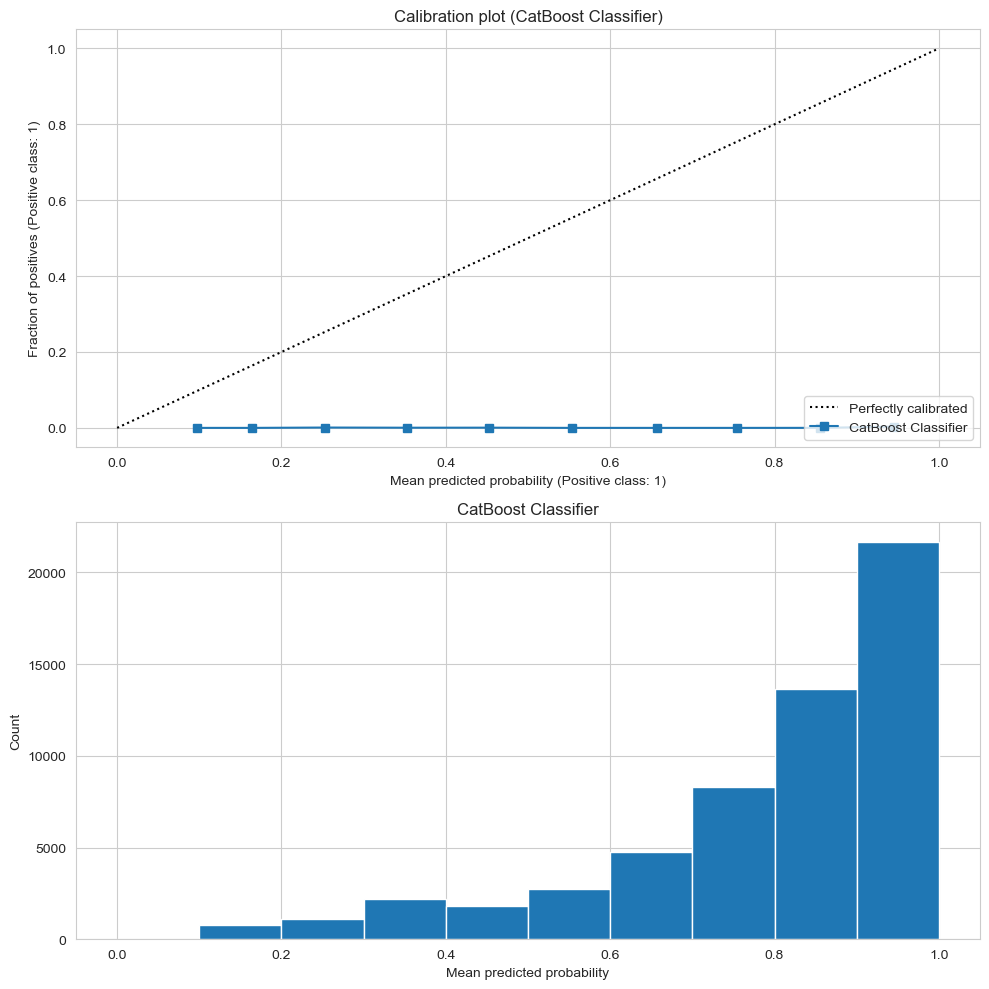

 71%|████████████████████████████████▏            | 5/7 [00:28<00:08,  4.14s/it]

Technique: TomekLinks


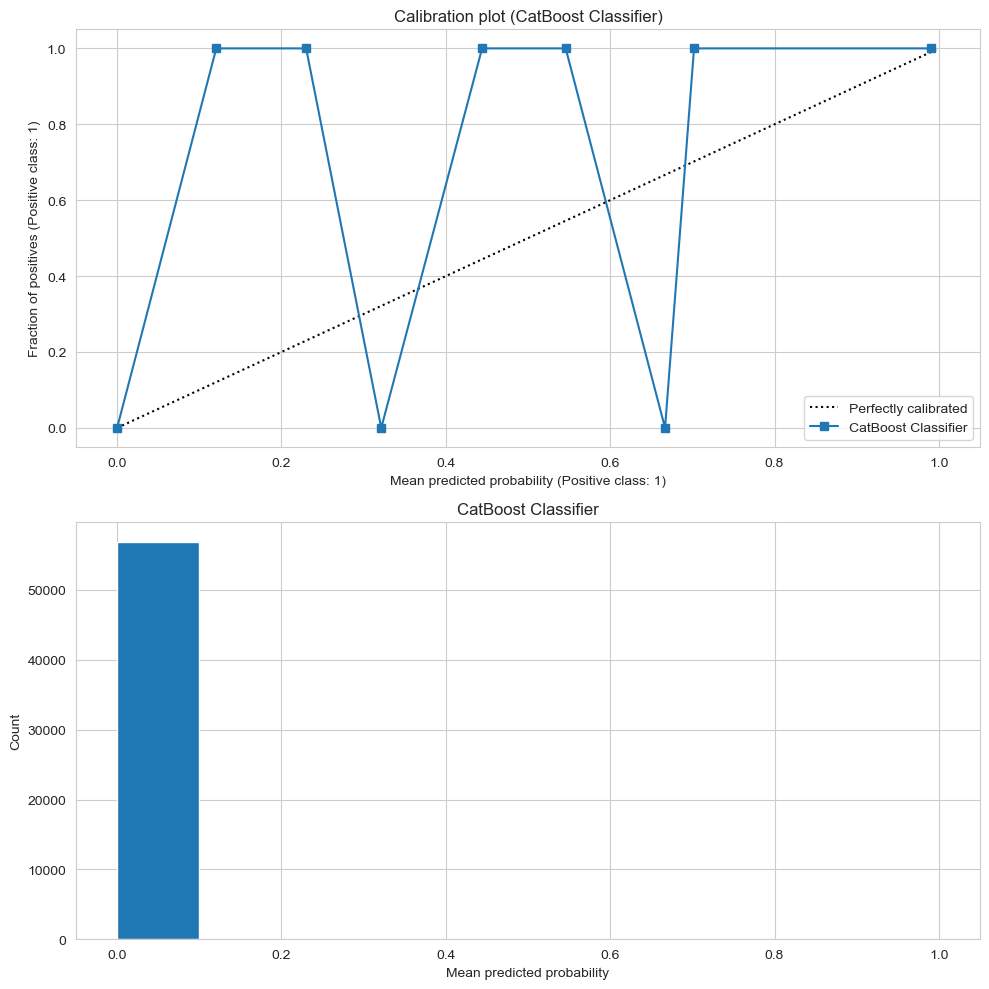

 86%|██████████████████████████████████████▌      | 6/7 [00:46<00:08,  8.72s/it]

Technique: EditedNearestNeighbours


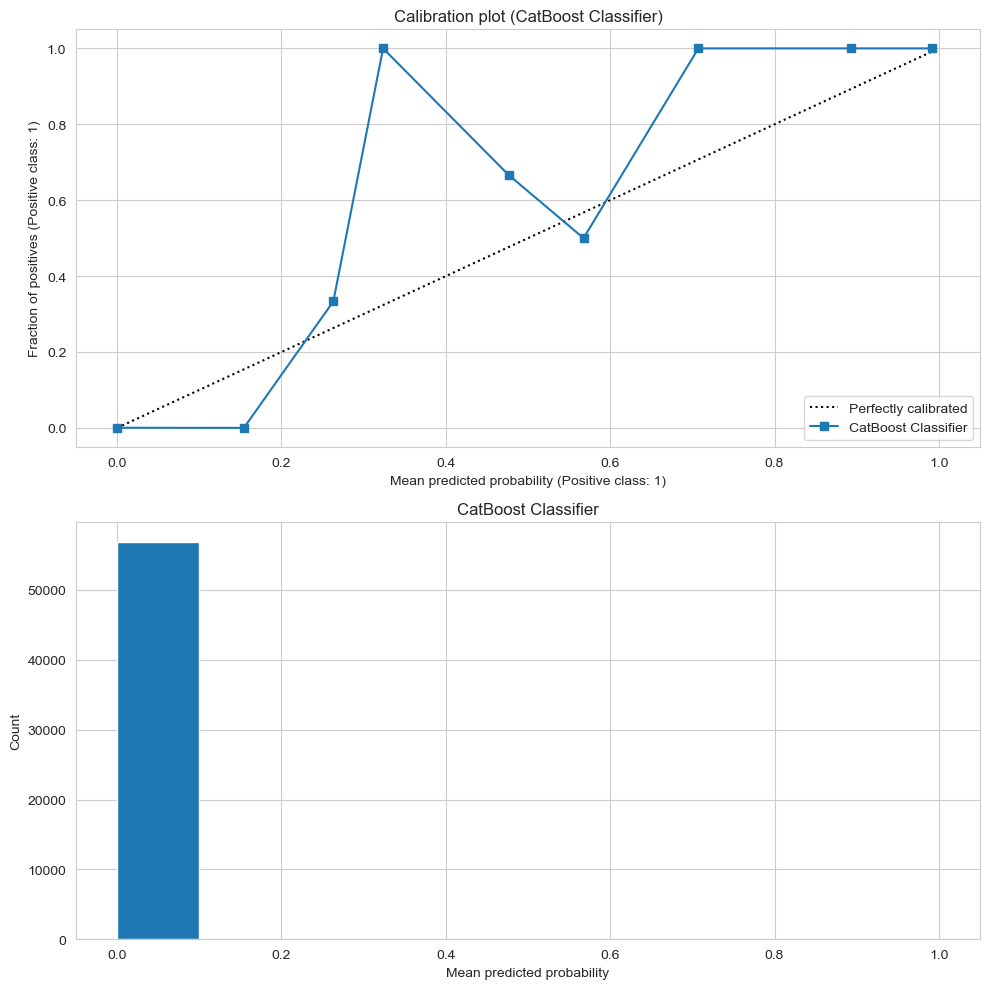

100%|█████████████████████████████████████████████| 7/7 [01:04<00:00,  9.16s/it]


In [94]:
for sampler in tqdm(techniques):
    technique = sampler.__class__.__name__

    print(f'Technique: {technique}')

    catboost_model  = CatBoostClassifier(
    task_type="CPU",       # You can change this to "GPU" if you have a GPU.
    thread_count=-1,       # Use all available CPU cores
    verbose=0,
    random_state=RANDOM_STATE
    )
    performance_resampling_methods_df,_ = evaluate_resampled_model_performance(catboost_model,'CatBoost Classifier', sampler = sampler, verbose=True)
     


## CatBoost with Resampling Methods

In [95]:
catboost_performance_resampling_methods_df = performance_resampling_methods_df.copy()

performance_resampling_methods_df[:] = np.nan

In [96]:
catboost_performance_resampling_methods_df

RandomOverSampler     SMOTE    ADASYN  RandomUnderSampler  \
Accuracy             0.999544  0.999280  0.999350            0.989783   
Precision            0.888889  0.717949  0.756757            0.102041   
Recall               0.746667  0.746667  0.746667            0.866667   
F1                   0.811594  0.732026  0.751678            0.182584   
ROC AUC              0.958781  0.955473  0.956895            0.986646   
ECE                  0.225779  0.320113  0.230638            0.454456   
Log Loss             0.003066  0.003658  0.003404            0.050320   
Brier Loss           0.000470  0.000604  0.000549            0.010174   

            NearMiss  TomekLinks  EditedNearestNeighbours  
Accuracy    0.104754    0.999544                 0.999579  
Precision   0.001410    0.980392                 0.981132  
Recall      0.960000    0.666667                 0.693333  
F1          0.002816    0.793651                 0.812500  
ROC AUC     0.931923    0.976085                 0.973874  
ECE         0.508011    0.439467                 0.174129  
Log Loss    1.990298    0.003472                 0.003263  
Brier Loss  0.660675    0.000424                 0.000376

In [97]:
resampled_time_df

Execution Time (s)
Naive Classifier                        NaN
Logistic Regression               13.038276
Random Forest Classifier                NaN
AdaBoost Classifier                     NaN
CatBoost Classifier               17.614595
SVC                                     NaN
LGBM Classifier                         NaN
XGBoost Classifier                      NaN

In [98]:
catboost_performance_resampling_methods_df.to_csv('catboost_performance_resampling_methods.csv')

## Calibration with Venn-ABERS

In [99]:
!rm -r '/content/VennABERS'

rm: /content/VennABERS: No such file or directory


In [100]:
CLONE_URL = f"https://github.com/ptocca/VennABERS"
!git clone https://github.com/ptocca/VennABERS
get_ipython().system(f"git clone {CLONE_URL}")

import sys
sys.path.append("VennABERS")

Cloning into 'VennABERS'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 64 (delta 22), reused 31 (delta 11), pack-reused 12 (from 1)
Receiving objects: 100% (64/64), 70.66 KiB | 1.04 MiB/s, done.
Resolving deltas: 100% (23/23), done.
fatal: destination path 'VennABERS' already exists and is not an empty directory.


In [101]:
%cd VennABERS

/Users/joaquinromero/Desktop/conformal_prediction/chap_11/VennABERS


/opt/anaconda3/envs/CP/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning:

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.



In [102]:
import VennABERS

??VennABERS.ScoresToMultiProbs

Signature: VennABERS.ScoresToMultiProbs(calibrPoints, testObjects)
Docstring: <no docstring>
Source:   
def ScoresToMultiProbs(calibrPoints,testObjects):
    # sort the points, transform into unique objects, with weights and updated values
    yPrime,yCsd,xPrime,ptsUnique = prepareData(calibrPoints)
    
    # compute the F0 and F1 functions from the CSD
    F0,F1 = computeF(xPrime,yCsd)
    
    # compute the values for the given test objects
    p0,p1 = getFVal(F0,F1,ptsUnique,testObjects)
                    
    return p0,p1
File:      ~/Desktop/conformal_prediction/chap_11/VennABERS/VennABERS.py
Type:      function

In [103]:
%pwd

'/Users/joaquinromero/Desktop/conformal_prediction/chap_11/VennABERS'

In [104]:
%cd '../'

/Users/joaquinromero/Desktop/conformal_prediction/chap_11


## Calibrate Logistic Regression

In [105]:
calibrated_performance_df = performance_resampling_methods_df.copy()

calibrated_performance_df[:] = np.nan

In [106]:
# Ground Truth Calibration Labels
y_cal = calib_df['Class']

In [107]:
def evaluate_resampled_calibrated_model_performance(model, model_name, sampler, true_labels=true_labels, performance_df=calibrated_performance_df, verbose=False):
    """
    Evaluates model performance and updates the performance dataframe with metrics.

    Args:
    - predictions (array-like): Predicted values from the model.
    - model_name (str): Name of the model for which performance is being evaluated.
    - true_labels (array-like): Actual labels for comparison. Default is the true_labels of the test set.
    - performance_df (DataFrame): DataFrame to update with model performance metrics.

    Returns:
    - DataFrame with updated performance metrics for the given model.
    """

    start_time = time.time()  # Record start time

    technique = sampler.__class__.__name__

    X_resampled, y_resampled = sampler.fit_resample(train_df.drop(columns='Class'), train_df['Class'])

    # Train Logistic Regression
    model.fit(X_resampled, y_resampled)

    # use trained machnine learning model to predict on the calibration set
    y_hat_cal_scores = model.predict_proba(calib_df.drop(columns='Class'))[:, 1]

    # Predict class score on the test set
    prob_pos = model.predict_proba(test_df.drop(columns='Class'))[:, 1]
    testScores =prob_pos

    # Predict on the test set
    predictions = model.predict(test_df.drop(columns='Class'))

    # calibrate using Venn-ABERS
    #calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples. The score is a float and the label is an integer meant to take values 0 or 1.
    calibrPts = zip(list(y_hat_cal_scores),list(y_cal))

    # Conformal Prediciton VennABERS calibration model learns calibration
    # on the calibration dataset by comparing scores output by underlying machine
    # learning model and comparing them with class labels on the calibration set
    p0,p1 = VennABERS.ScoresToMultiProbs(calibrPts,testScores)

    prob_pos_calibrated = p1/(1-p0+p1)
    calibrated_predictions = prob_pos_calibrated > 0.5

    # Compute metrics
    accuracy = accuracy_score(true_labels, calibrated_predictions)
    precision = precision_score(true_labels, calibrated_predictions, zero_division=0)
    recall = recall_score(true_labels, calibrated_predictions)
    f1 = f1_score(true_labels, calibrated_predictions)
    roc_auc = roc_auc_score(true_labels, prob_pos_calibrated)
    logloss = log_loss(true_labels, prob_pos_calibrated)
    brier_loss = brier_score_loss(true_labels, prob_pos_calibrated)

    # Compute Expected Calibration Error (ECE)
    fraction_of_positives, mean_predicted_value = calibration_curve(true_labels, prob_pos_calibrated, n_bins=10)
    ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value)) / len(mean_predicted_value)

    # Populate the performance dataframe
    calibrated_performance_df[technique] = [accuracy, precision, recall, f1, roc_auc, ece, logloss, brier_loss]

    # Plot calibration curve and histogram if verbose is True
    if verbose:
        fig = plt.figure(figsize=(10, 10))
        gs = GridSpec(2, 1)
        ax_calibration_curve = fig.add_subplot(gs[0, :])
        ax_histogram = fig.add_subplot(gs[1, :])

        # Plot calibration curve
        CalibrationDisplay.from_estimator(
            model,
            test_df.drop(columns='Class'),
            true_labels,
            n_bins=10,
            name=model_name,
            ax=ax_calibration_curve
        )
        ax_calibration_curve.set_title(f"Calibration plot ({model_name})")

        # Plot histogram
        ax_histogram.hist(prob_pos, range=(0, 1), bins=10, label=model_name)
        ax_histogram.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")

        plt.tight_layout()
        plt.show()

    end_time = time.time()  # Record end time
    execution_time = end_time - start_time  # Calculate execution time in seconds

    # Record execution time in the time DataFrame
    resampled_time_df.loc[model_name, 'Execution Time (s)'] = execution_time

    return calibrated_performance_df,model

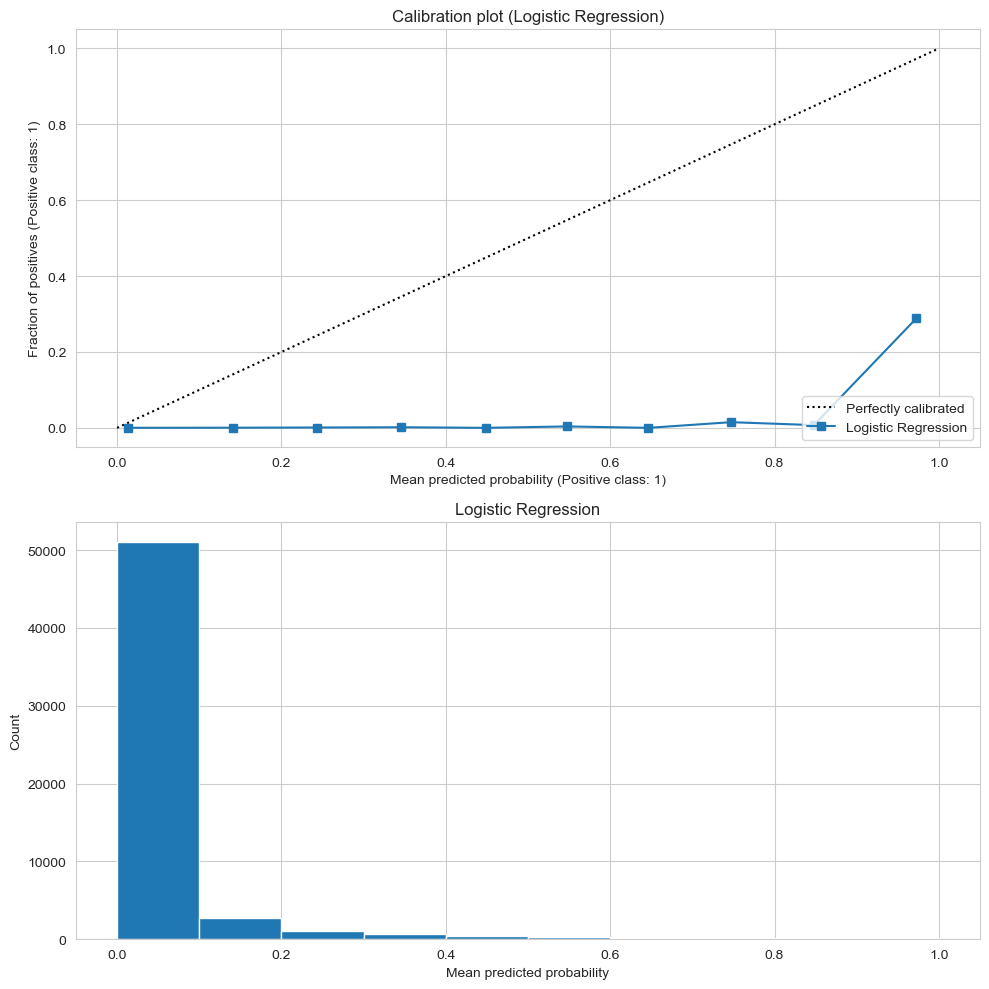

In [108]:
# Train Logistic Regression
logistic_regression_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
calibrated_performance_df,_ = evaluate_resampled_calibrated_model_performance(logistic_regression_model,'Logistic Regression',
                                                                              sampler = SMOTE(),
                                                                              verbose=True)


In [109]:
calibrated_performance_df

RandomOverSampler     SMOTE  ADASYN  RandomUnderSampler  NearMiss  \
Accuracy                  NaN  0.999473     NaN                 NaN       NaN   
Precision                 NaN  0.924528     NaN                 NaN       NaN   
Recall                    NaN  0.653333     NaN                 NaN       NaN   
F1                        NaN  0.765625     NaN                 NaN       NaN   
ROC AUC                   NaN  0.978612     NaN                 NaN       NaN   
ECE                       NaN  0.176795     NaN                 NaN       NaN   
Log Loss                  NaN  0.002813     NaN                 NaN       NaN   
Brier Loss                NaN  0.000472     NaN                 NaN       NaN   

            TomekLinks  EditedNearestNeighbours  
Accuracy           NaN                      NaN  
Precision          NaN                      NaN  
Recall             NaN                      NaN  
F1                 NaN                      NaN  
ROC AUC            NaN                      NaN  
ECE                NaN                      NaN  
Log Loss           NaN                      NaN  
Brier Loss         NaN                      NaN

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Technique: RandomOverSampler


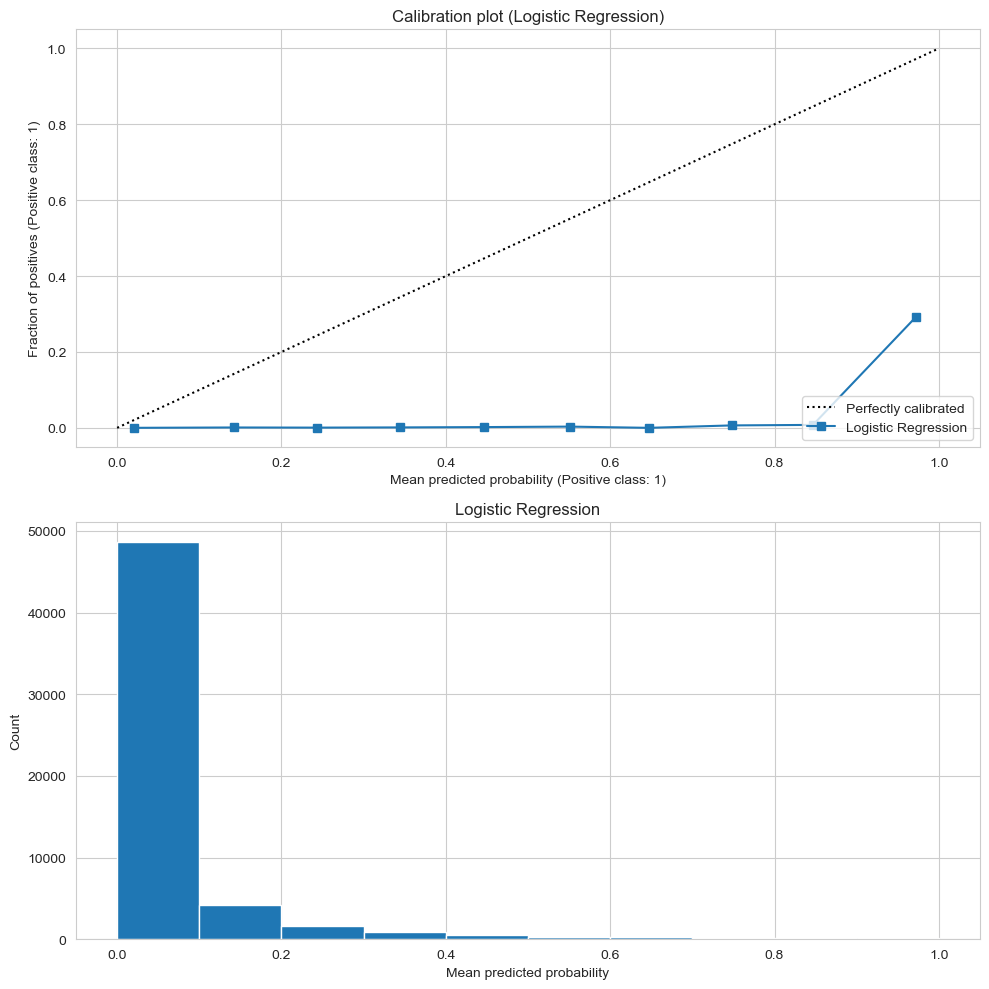

 14%|██████▍                                      | 1/7 [00:08<00:53,  8.87s/it]

Technique: SMOTE


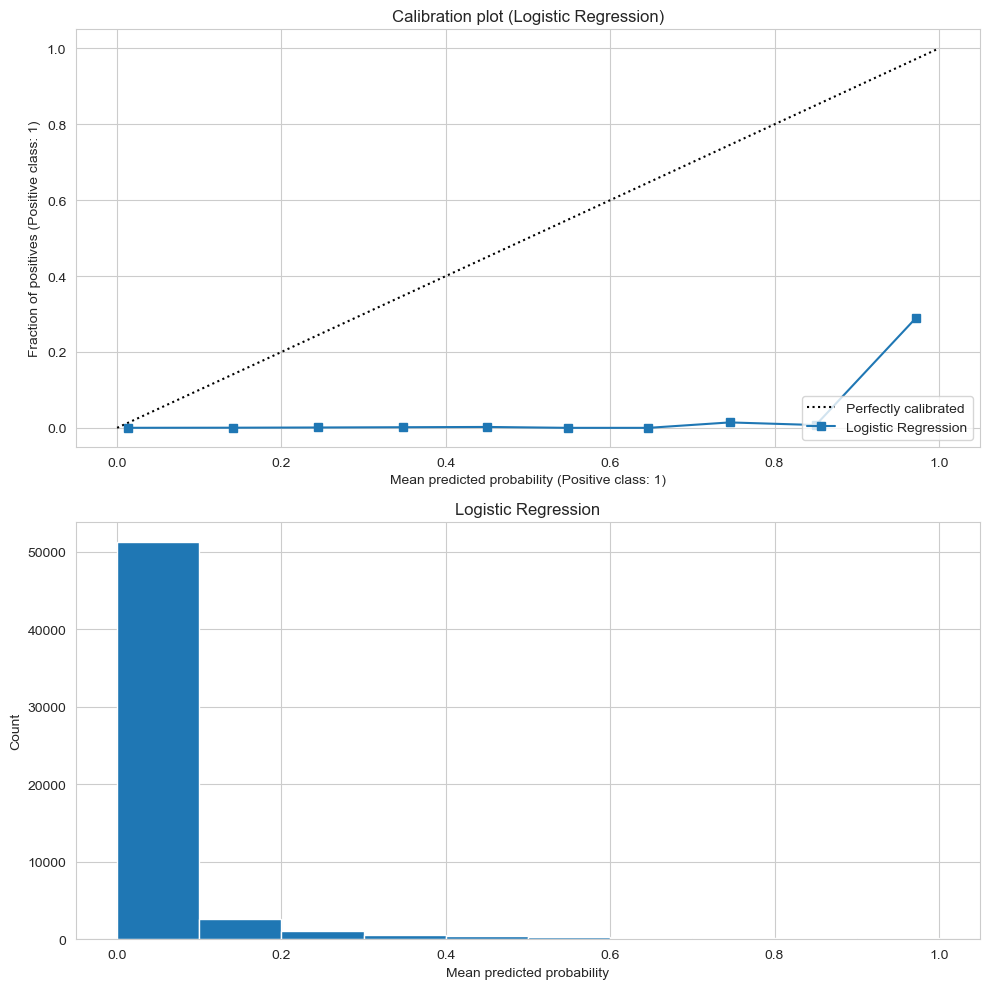

 29%|████████████▊                                | 2/7 [00:32<01:28, 17.73s/it]

Technique: ADASYN


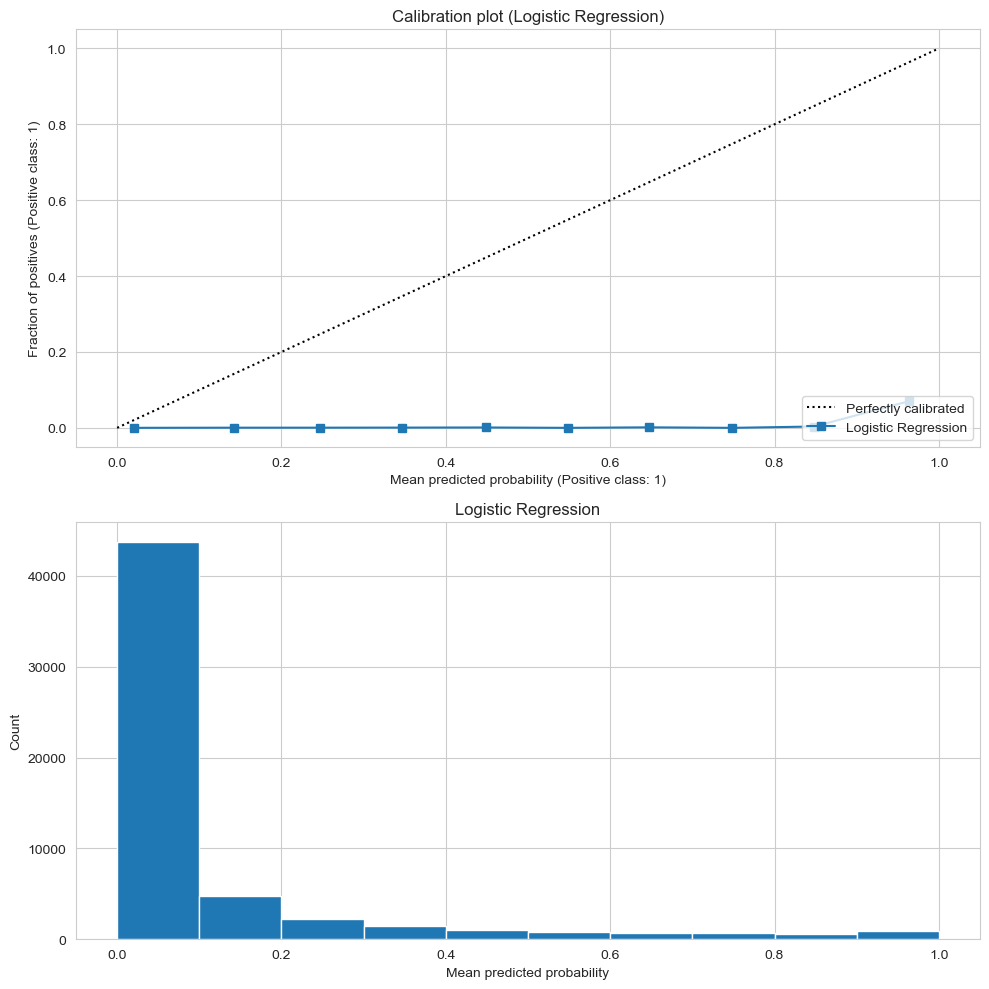

 43%|███████████████████▎                         | 3/7 [01:14<01:54, 28.68s/it]

Technique: RandomUnderSampler


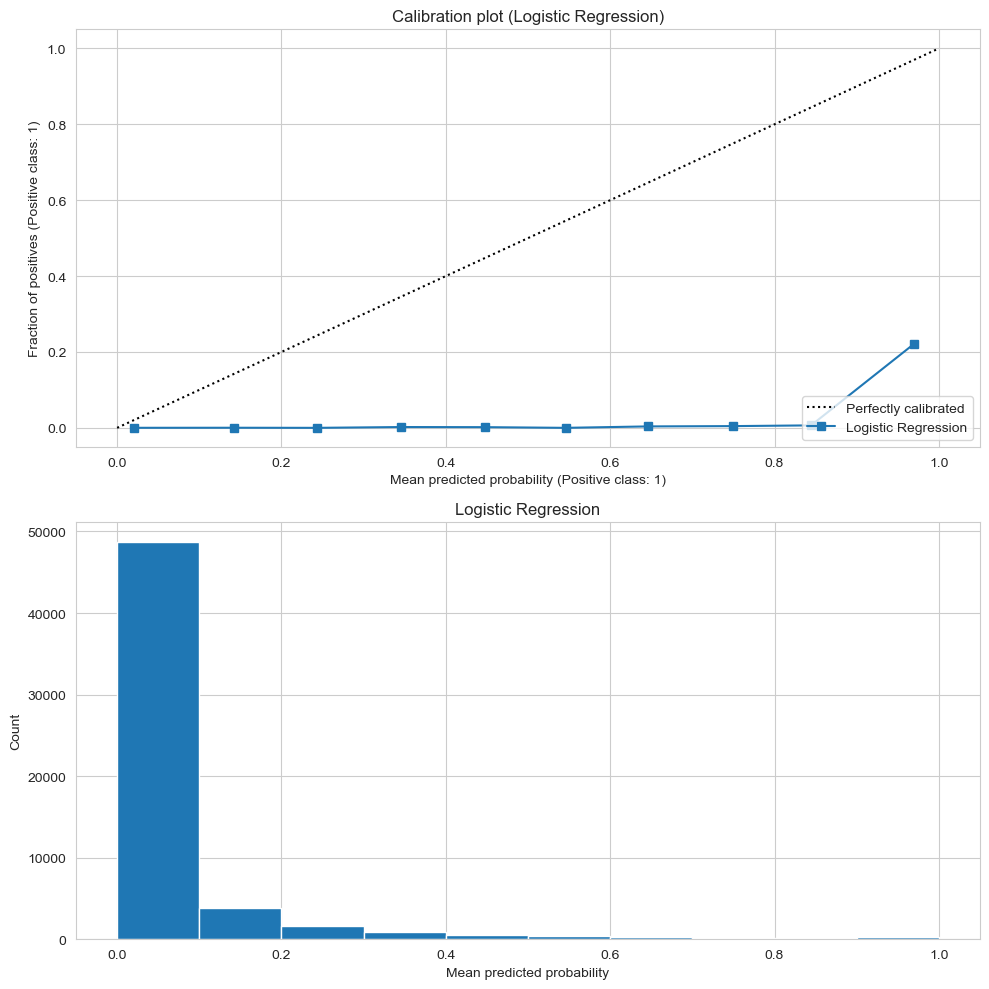

 57%|█████████████████████████▋                   | 4/7 [01:21<00:59, 19.99s/it]

Technique: NearMiss


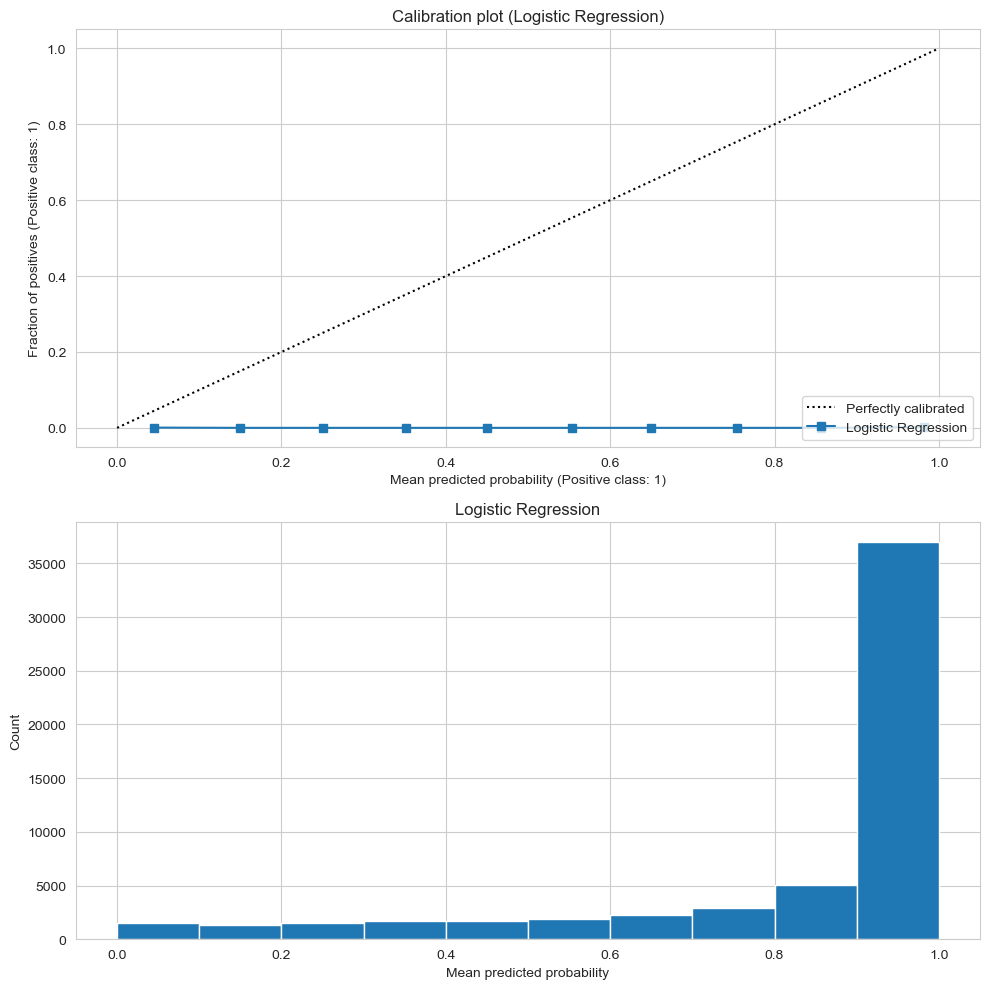

 71%|████████████████████████████████▏            | 5/7 [01:30<00:32, 16.25s/it]

Technique: TomekLinks


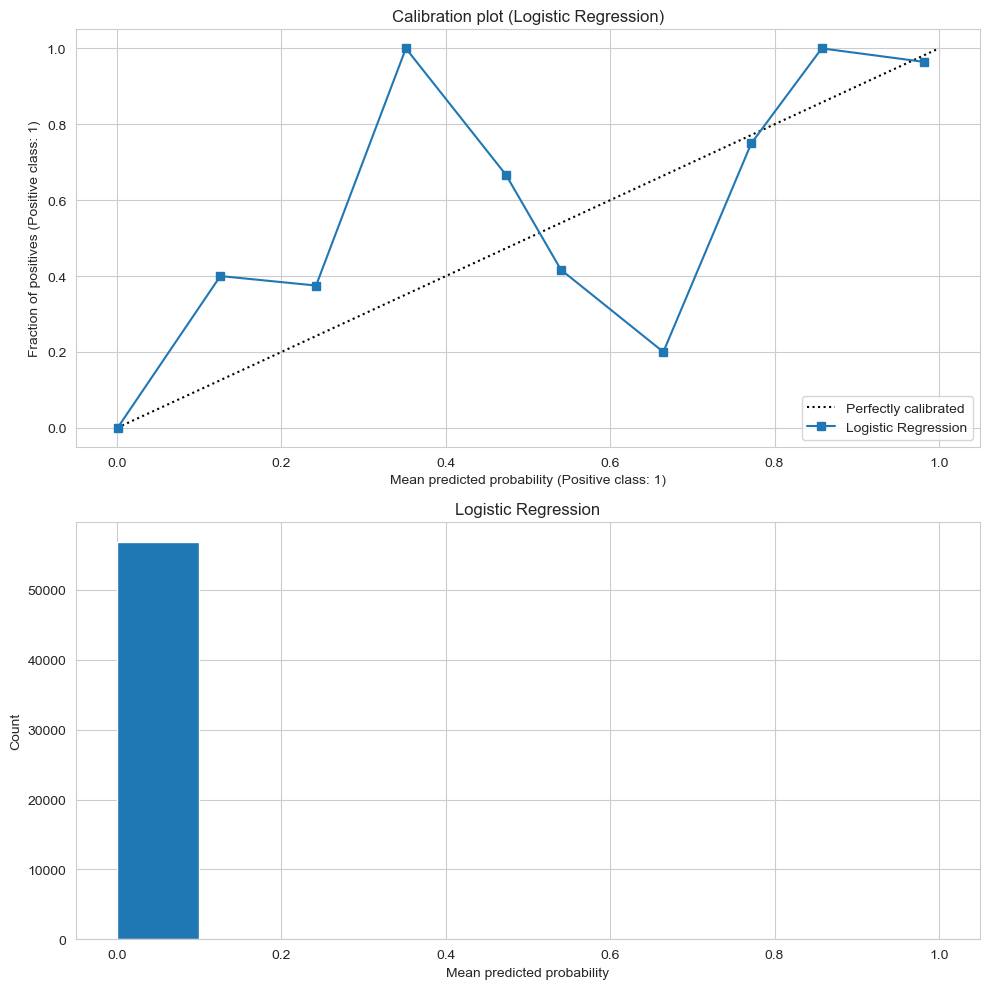

 86%|██████████████████████████████████████▌      | 6/7 [01:45<00:15, 15.81s/it]

Technique: EditedNearestNeighbours


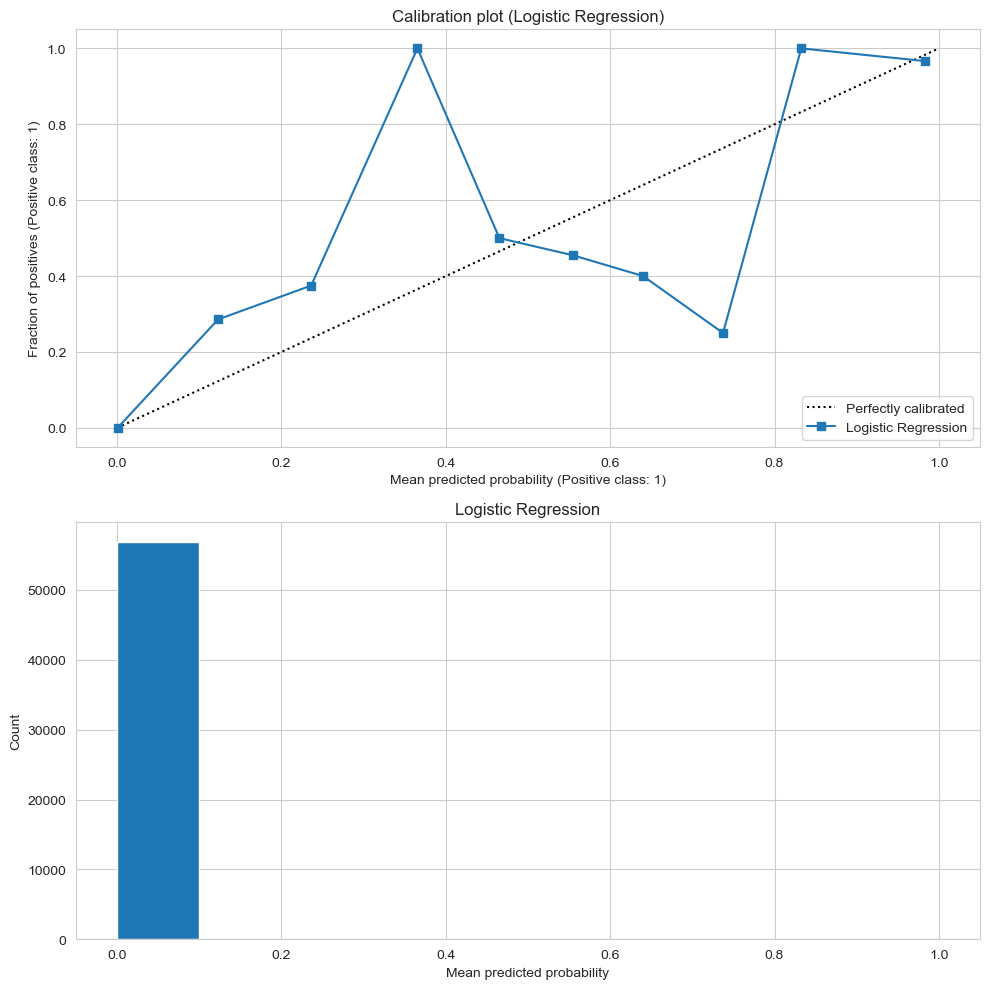

100%|█████████████████████████████████████████████| 7/7 [01:59<00:00, 17.02s/it]


In [110]:
techniques = [RandomOverSampler(), SMOTE(), ADASYN(), RandomUnderSampler(), NearMiss(version=1), TomekLinks(), EditedNearestNeighbours()]

for sampler in tqdm(techniques):
    technique = sampler.__class__.__name__
    print(f'Technique: {technique}')
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    calibrated_performance_df,_ = evaluate_resampled_calibrated_model_performance(logistic_regression_model,'Logistic Regression',
                                                                                  sampler = sampler,
                                                                                  verbose=True)

In [111]:
lr_calibrated_resampling_performance_df = calibrated_performance_df.copy()

lr_calibrated_resampling_performance_df.to_csv('lr_calibrated_resampling_performance.csv')

## Calibrate CatBoost

In [112]:
calibrated_performance_df[:] = np.nan

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Technique: RandomOverSampler


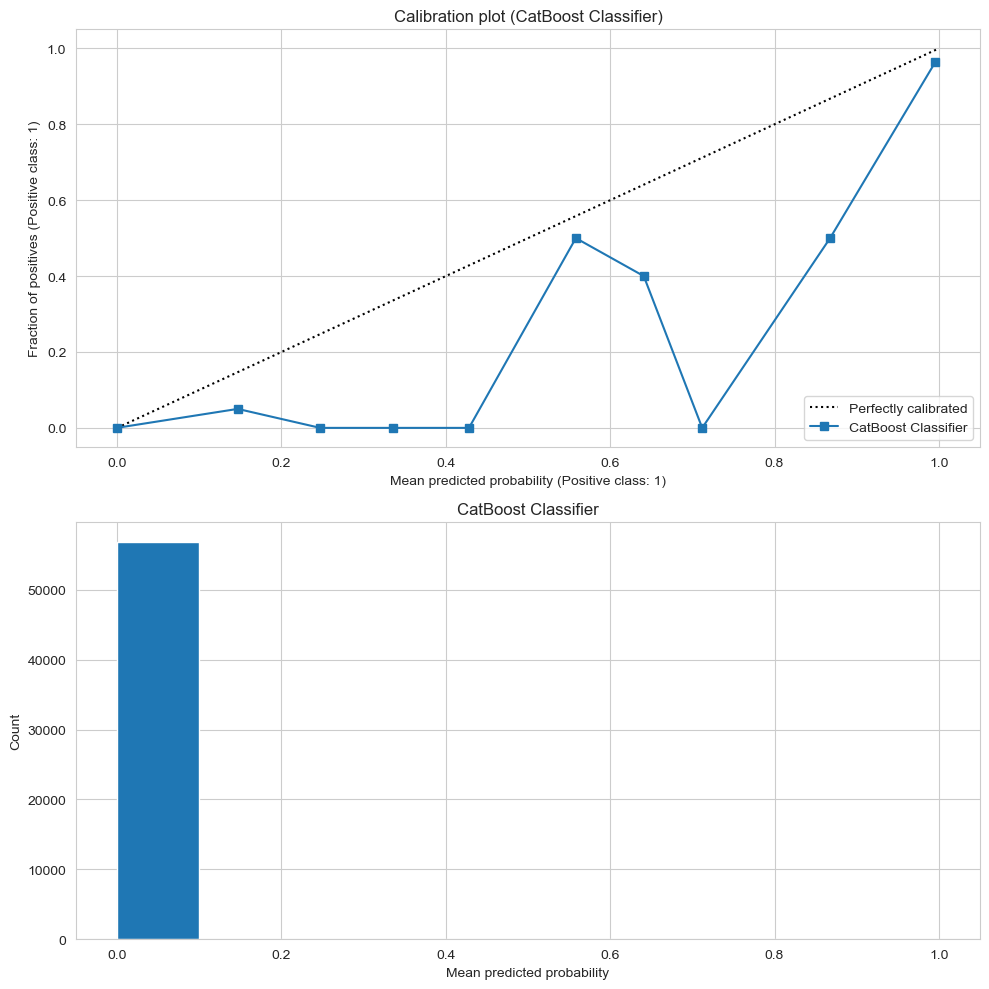

 14%|██████▍                                      | 1/7 [00:09<00:59,  9.84s/it]

Technique: SMOTE


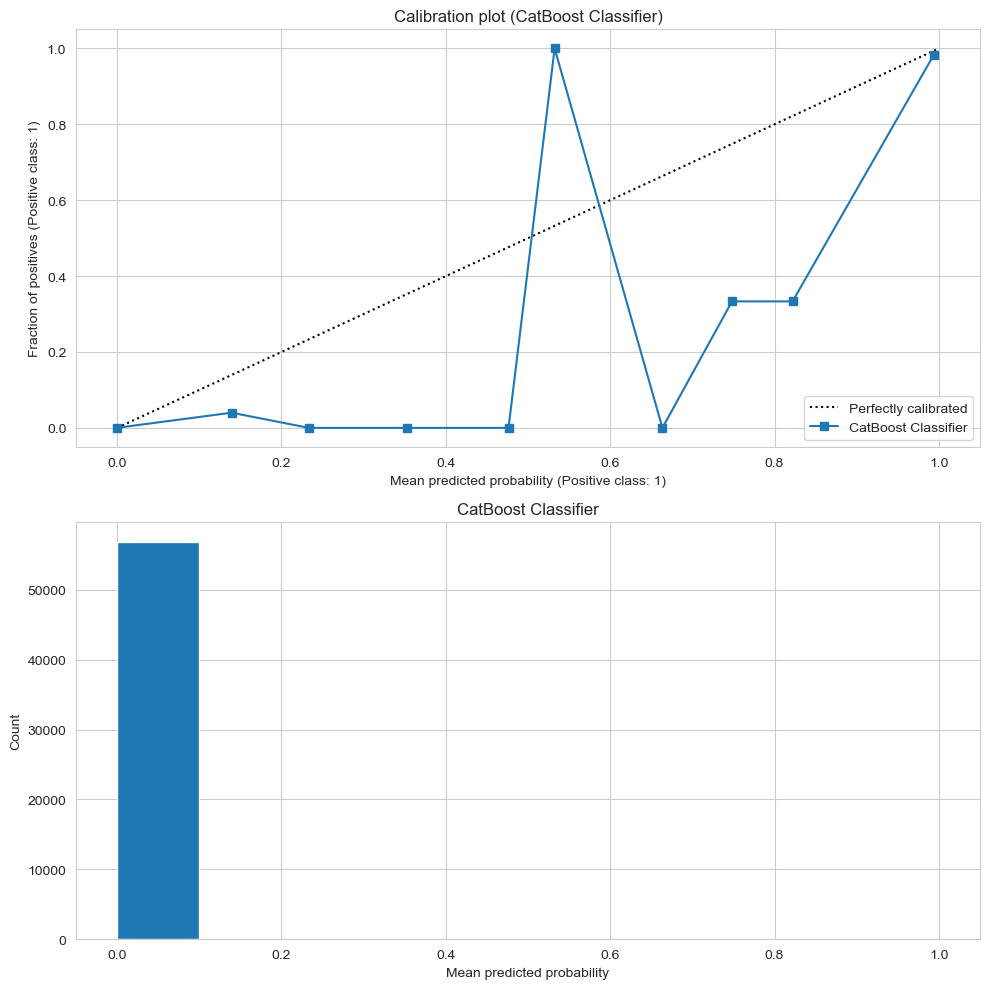

 29%|████████████▊                                | 2/7 [00:19<00:49,  9.92s/it]

Technique: ADASYN


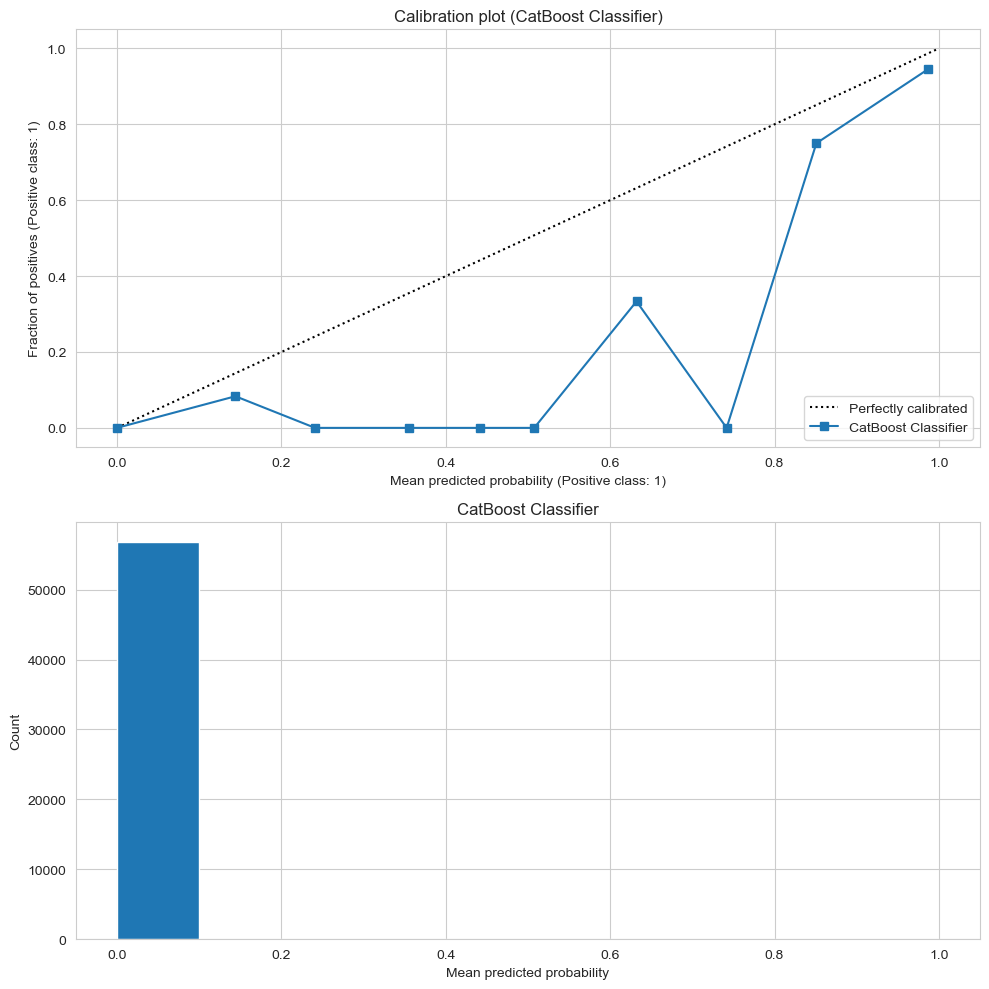

 43%|███████████████████▎                         | 3/7 [00:30<00:40, 10.15s/it]

Technique: RandomUnderSampler


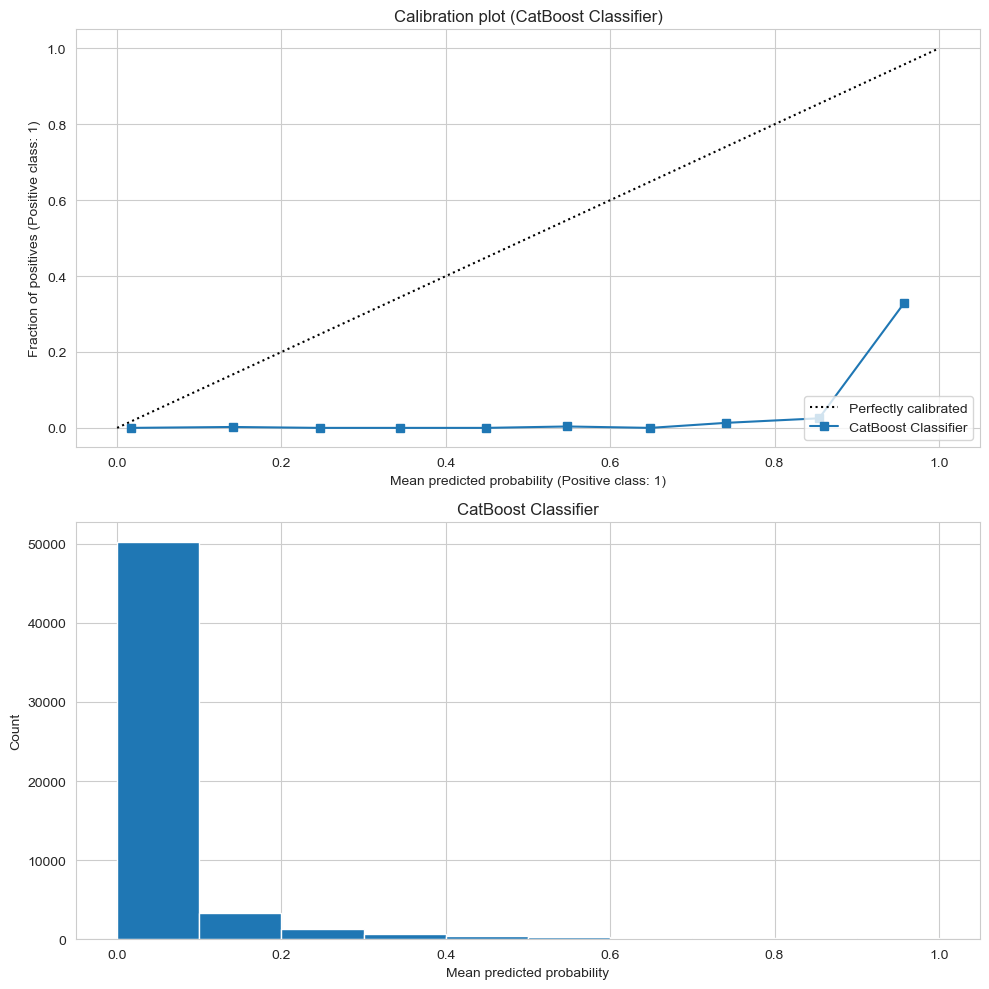

 57%|█████████████████████████▋                   | 4/7 [00:32<00:21,  7.01s/it]

Technique: NearMiss


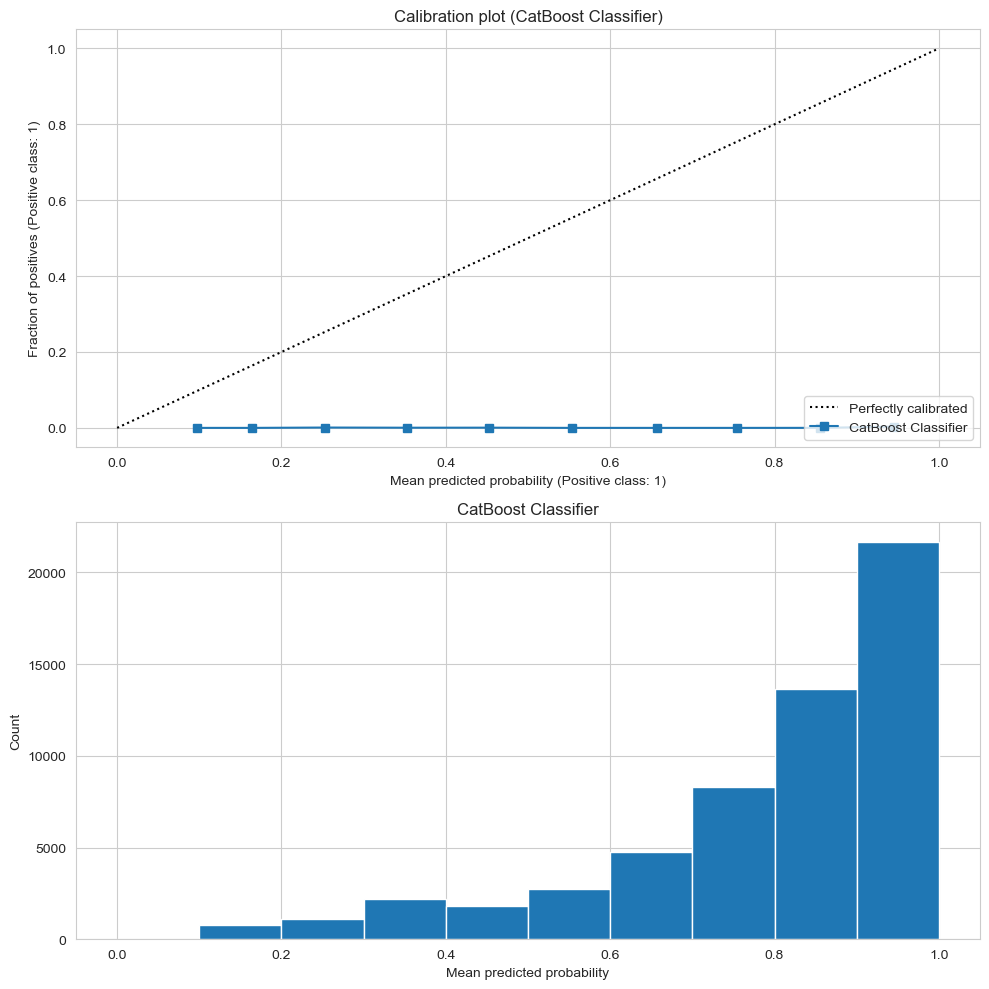

 71%|████████████████████████████████▏            | 5/7 [00:34<00:10,  5.29s/it]

Technique: TomekLinks


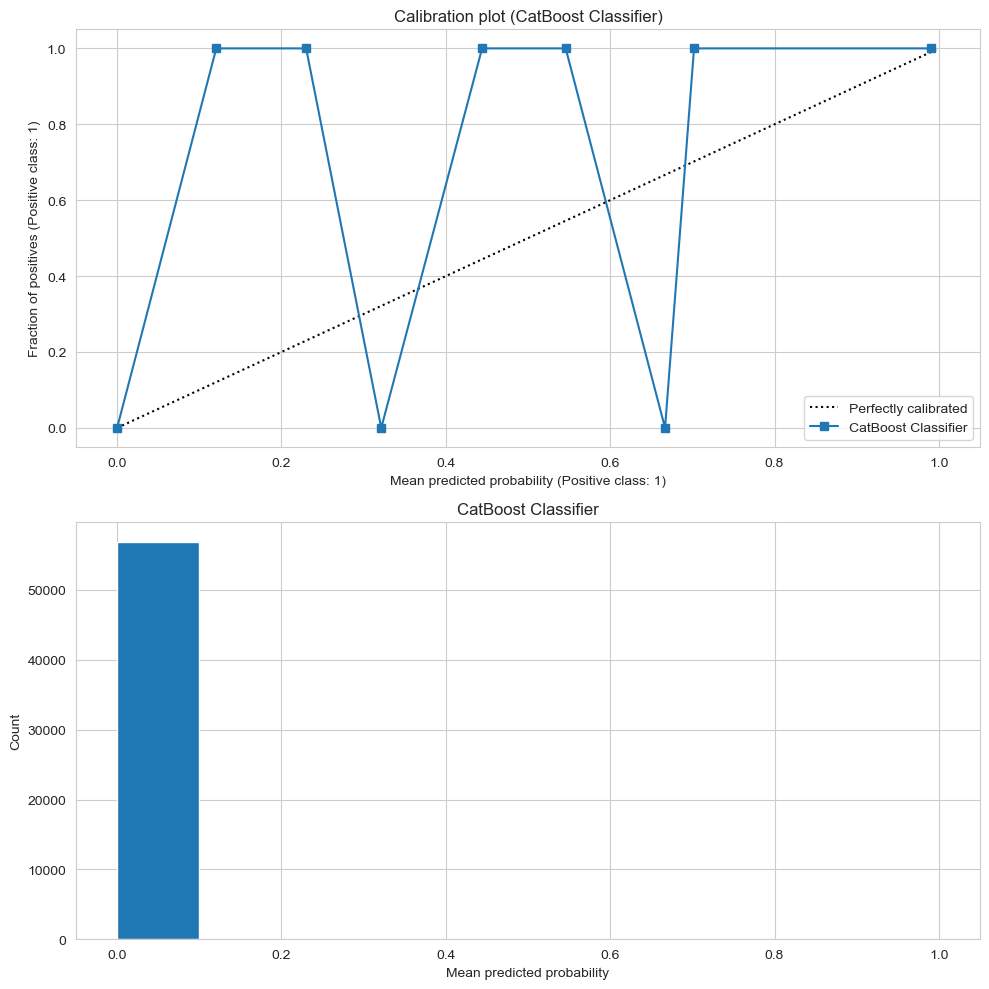

 86%|██████████████████████████████████████▌      | 6/7 [00:52<00:09,  9.60s/it]

Technique: EditedNearestNeighbours


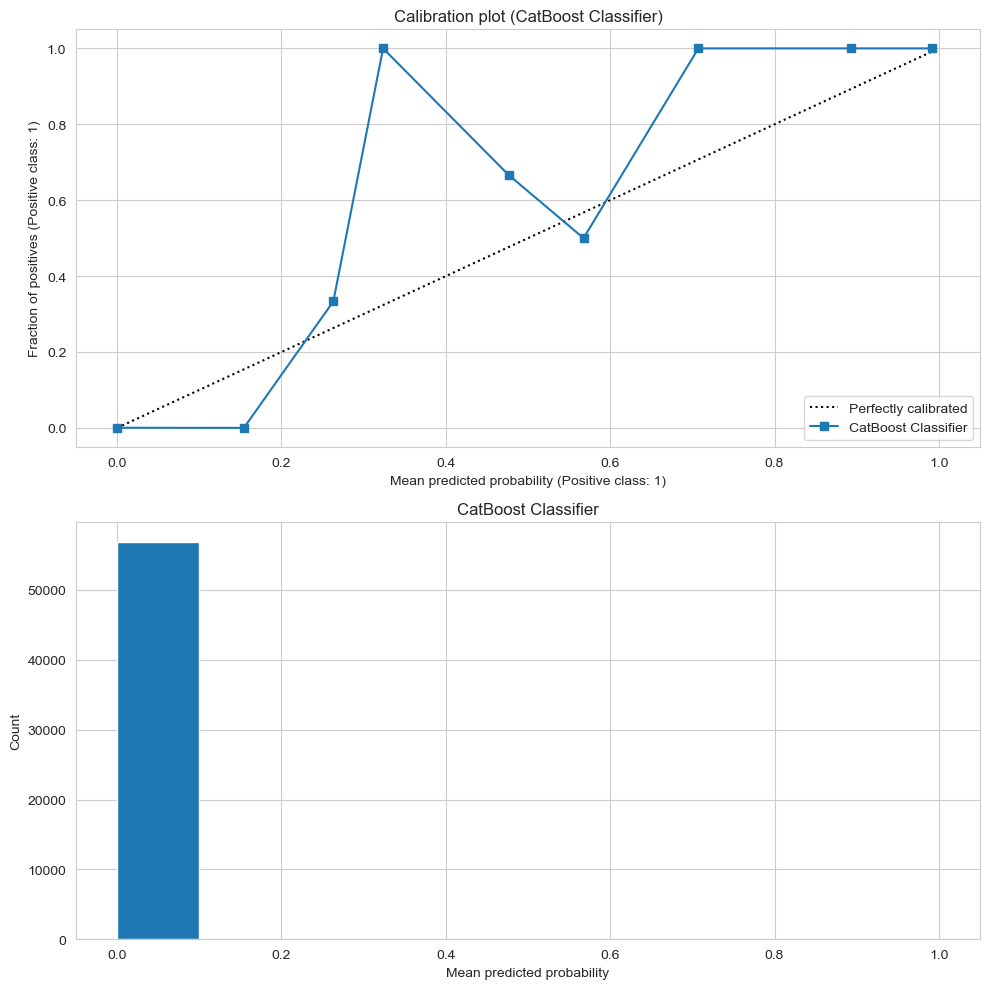

100%|█████████████████████████████████████████████| 7/7 [01:10<00:00, 10.12s/it]


In [113]:
for sampler in tqdm(techniques):
    technique = sampler.__class__.__name__

    print(f'Technique: {technique}')

    catboost_model  = CatBoostClassifier(
    task_type="CPU",       
    thread_count=-1,       
    verbose=0,
    random_state=RANDOM_STATE
    )
    calibrated_performance_df,_ = evaluate_resampled_calibrated_model_performance(catboost_model,'CatBoost Classifier',
                                                                                  sampler = sampler,
                                                                                  verbose=True)

In [114]:
catboost_calibrated_resampling_performance_df = calibrated_performance_df.copy()

catboost_calibrated_resampling_performance_df.to_csv('catboost_calibrated_resampling_performance.csv')

In [115]:
catboost_calibrated_resampling_performance_df.head()

RandomOverSampler     SMOTE    ADASYN  RandomUnderSampler  \
Accuracy            0.999579  0.999596  0.999491            0.999438   
Precision           0.947368  0.948276  0.859375            0.890909   
Recall              0.720000  0.733333  0.733333            0.653333   
F1                  0.818182  0.827068  0.791367            0.753846   
ROC AUC             0.958985  0.956954  0.967820            0.987168   

           NearMiss  TomekLinks  EditedNearestNeighbours  
Accuracy   0.999386    0.999596                 0.999596  
Precision  0.976190    0.948276                 0.964286  
Recall     0.546667    0.733333                 0.720000  
F1         0.700855    0.827068                 0.824427  
ROC AUC    0.931368    0.975415                 0.972289

In [116]:
catboost_performance_resampling_methods_df.head()

RandomOverSampler     SMOTE    ADASYN  RandomUnderSampler  \
Accuracy            0.999544  0.999280  0.999350            0.989783   
Precision           0.888889  0.717949  0.756757            0.102041   
Recall              0.746667  0.746667  0.746667            0.866667   
F1                  0.811594  0.732026  0.751678            0.182584   
ROC AUC             0.958781  0.955473  0.956895            0.986646   

           NearMiss  TomekLinks  EditedNearestNeighbours  
Accuracy   0.104754    0.999544                 0.999579  
Precision  0.001410    0.980392                 0.981132  
Recall     0.960000    0.666667                 0.693333  
F1         0.002816    0.793651                 0.812500  
ROC AUC    0.931923    0.976085                 0.973874